In [1]:
import pandas as pd
import os


In [2]:
print(os.getcwd())
path = 'dataset'
df = pd.read_csv(os.path.join(path, 'champs_elysees.csv'),delimiter=';')

/Users/macbookair/Desktop/BCG X/trafic_prediction


In [3]:
# ============================================================================
# EXPLORATION DE DONNÉES - PRÉDICTION TRAFIC
# ============================================================================
# Objectif: Prédire "Débit horaire" et "Taux d'occupation" 
# Features: Date et heure de comptage, Etat trafic
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [4]:
# Renommage des colonnes - Suppression des espaces, apostrophes et accents
print("="*80)
print("RENOMMAGE DES COLONNES")
print("="*80)

# Mapping des anciens noms vers les nouveaux noms
colonnes_mapping = {
    'Date et heure de comptage': 'date_heure_comptage',
    'Débit horaire': 'debit_horaire',
    'Taux d\'occupation': 'taux_occupation',
    'Etat trafic': 'etat_trafic'
}

print("\nMapping des colonnes:")
for old, new in colonnes_mapping.items():
    print(f"  '{old}' → '{new}'")

# Sélection et renommage
colonnes_utiles = list(colonnes_mapping.keys())
df_model = df[colonnes_utiles].copy()
df_model.rename(columns=colonnes_mapping, inplace=True)

print(f"\nShape du dataset: {df_model.shape}")
print(f"\nColonnes finales:")
for col in df_model.columns:
    print(f"  - {col}")

print("\nAperçu des données:")
df_model.head(10)

RENOMMAGE DES COLONNES

Mapping des colonnes:
  'Date et heure de comptage' → 'date_heure_comptage'
  'Débit horaire' → 'debit_horaire'
  'Taux d'occupation' → 'taux_occupation'
  'Etat trafic' → 'etat_trafic'

Shape du dataset: (9266, 4)

Colonnes finales:
  - date_heure_comptage
  - debit_horaire
  - taux_occupation
  - etat_trafic

Aperçu des données:


date_heure_comptage  debit_horaire  taux_occupation etat_trafic
0  2024-12-09T05:00:00+01:00          199.0          2.20945      Fluide
1  2024-12-09T06:00:00+01:00          235.0          2.28778      Fluide
2  2024-12-09T09:00:00+01:00         1041.0         11.63222      Fluide
3  2025-09-02T09:00:00+02:00         1139.0         28.39222  Pré-saturé
4  2024-09-04T20:00:00+02:00          686.0         13.21611      Fluide
5  2024-09-04T21:00:00+02:00          727.0         13.52611      Fluide
6  2024-09-04T22:00:00+02:00          744.0         13.36722      Fluide
7  2025-04-03T11:00:00+02:00         1138.0         16.94889  Pré-saturé
8  2025-09-03T09:00:00+02:00         1299.0         41.56389      Saturé
9  2025-09-03T08:00:00+02:00         1051.0         24.45722  Pré-saturé

In [5]:
df_model.groupby('etat_trafic').agg({'debit_horaire':['min','max'], 'taux_occupation':['min','max']})

debit_horaire         taux_occupation          
                      min     max             min       max
etat_trafic                                                
Bloqué               77.0  1405.0        50.25056  77.54556
Fluide                0.0  1301.0         0.00000  14.99945
Inconnu               0.0   781.0             NaN       NaN
Pré-saturé           25.0  1484.0        15.01389  29.98056
Saturé               50.0  2190.0        30.00000  49.71167

In [6]:
# Analyse des valeurs manquantes
print("\n" + "="*80)
print("ANALYSE DES VALEURS MANQUANTES")
print("="*80)

missing_info = pd.DataFrame({
    'Colonne': df_model.columns,
    'Valeurs manquantes': df_model.isnull().sum(),
    'Pourcentage': (df_model.isnull().sum() / len(df_model) * 100).round(2)
})

print("\n", missing_info.to_string(index=False))

print(f"\n⚠️  Lignes complètes (sans valeurs manquantes): {df_model.dropna().shape[0]} / {len(df_model)} ({df_model.dropna().shape[0]/len(df_model)*100:.2f}%)")
print(f"⚠️  Lignes avec valeurs manquantes: {df_model.isnull().any(axis=1).sum()} ({df_model.isnull().any(axis=1).sum()/len(df_model)*100:.2f}%)")


ANALYSE DES VALEURS MANQUANTES

             Colonne  Valeurs manquantes  Pourcentage
date_heure_comptage                   0         0.00
      debit_horaire                 563         6.08
    taux_occupation                 622         6.71
        etat_trafic                   0         0.00

⚠️  Lignes complètes (sans valeurs manquantes): 8644 / 9266 (93.29%)
⚠️  Lignes avec valeurs manquantes: 622 (6.71%)


In [7]:
# Conversion et extraction des features temporelles
print("\n" + "="*80)
print("EXTRACTION DES FEATURES TEMPORELLES")
print("="*80)
# Conversion en datetime avec gestion robuste
df_model['date_heure_comptage'] = pd.to_datetime(df_model['date_heure_comptage'], utc=True, errors='coerce')

# Retirer timezone si présent
if df_model['date_heure_comptage'].dt.tz is not None:
    df_model['date_heure_comptage'] = df_model['date_heure_comptage'].dt.tz_localize(None)

# Extraction des features temporelles
df_model['annee'] = df_model['date_heure_comptage'].dt.year
df_model['mois'] = df_model['date_heure_comptage'].dt.month
df_model['jour'] = df_model['date_heure_comptage'].dt.day
df_model['jour_semaine'] = df_model['date_heure_comptage'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df_model['nom_jour'] = df_model['date_heure_comptage'].dt.day_name()
df_model['heure'] = df_model['date_heure_comptage'].dt.hour
df_model['est_weekend'] = (df_model['jour_semaine'] >= 5).astype(int)

print(f"\nPériode des données: {df_model['date_heure_comptage'].min()} à {df_model['date_heure_comptage'].max()}")
print(f"Durée totale: {(df_model['date_heure_comptage'].max() - df_model['date_heure_comptage'].min()).days} jours")

print("\nNouvelles features créées:")
features_temporelles = ['annee', 'mois', 'jour', 'jour_semaine', 'nom_jour', 'heure', 'est_weekend']
for feat in features_temporelles:
    print(f"  - {feat}")
print("\nAperçu avec les nouvelles features:")
df_model[['date_heure_comptage', 'heure', 'nom_jour', 'est_weekend', 'debit_horaire', 'taux_occupation']].head(10)


EXTRACTION DES FEATURES TEMPORELLES

Période des données: 2024-09-01 03:00:00 à 2025-10-29 23:00:00
Durée totale: 423 jours

Nouvelles features créées:
  - annee
  - mois
  - jour
  - jour_semaine
  - nom_jour
  - heure
  - est_weekend

Aperçu avec les nouvelles features:


date_heure_comptage  heure   nom_jour  est_weekend  debit_horaire  \
0 2024-12-09 04:00:00      4     Monday            0          199.0   
1 2024-12-09 05:00:00      5     Monday            0          235.0   
2 2024-12-09 08:00:00      8     Monday            0         1041.0   
3 2025-09-02 07:00:00      7    Tuesday            0         1139.0   
4 2024-09-04 18:00:00     18  Wednesday            0          686.0   
5 2024-09-04 19:00:00     19  Wednesday            0          727.0   
6 2024-09-04 20:00:00     20  Wednesday            0          744.0   
7 2025-04-03 09:00:00      9   Thursday            0         1138.0   
8 2025-09-03 07:00:00      7  Wednesday            0         1299.0   
9 2025-09-03 06:00:00      6  Wednesday            0         1051.0   

   taux_occupation  
0          2.20945  
1          2.28778  
2         11.63222  
3         28.39222  
4         13.21611  
5         13.52611  
6         13.36722  
7         16.94889  
8         41.56389  
9         24.45722

In [8]:
# ============================================================================
# INTÉGRATION DONNÉES MÉTÉO ET VACANCES
# ============================================================================
print("\n" + "="*80)
print("INTÉGRATION DES DONNÉES MÉTÉO ET VACANCES")
print("="*80)

# --- 1. CHARGEMENT DES VACANCES SCOLAIRES ---
print("\n📅 Chargement des vacances scolaires...")
vacances_df = pd.read_csv('dataset_brut/fr-en-calendrier-scolaire.csv', delimiter=';', encoding='utf-8')

# Conversion des dates
vacances_df['Date de début'] = pd.to_datetime(vacances_df['Date de début'], utc=True).dt.tz_localize(None)
vacances_df['Date de fin'] = pd.to_datetime(vacances_df['Date de fin'], utc=True).dt.tz_localize(None)

print(f"  • {len(vacances_df)} périodes de vacances chargées")
print(f"  • Période couverte: {vacances_df['Date de début'].min()} à {vacances_df['Date de fin'].max()}")

# Fonction pour vérifier si une date est en vacances
def est_en_vacances(date):
    if pd.isna(date):
        return 0
    for _, row in vacances_df.iterrows():
        if row['Date de début'] <= date <= row['Date de fin']:
            return 1
    return 0

# Appliquer la fonction
print("  • Calcul de la colonne 'est_vacances'...")
df_model['est_vacances'] = df_model['date_heure_comptage'].apply(est_en_vacances)

print(f"  • Nombre d'heures en période de vacances: {df_model['est_vacances'].sum()} ({df_model['est_vacances'].sum()/len(df_model)*100:.1f}%)")

# --- 2. JOURS FÉRIÉS EN FRANCE ---
print("\n🎉 Ajout des jours fériés...")

# Définir les jours fériés fixes et mobiles pour 2024-2025
jours_feries = [
    # 2024
    '2024-01-01',  # Jour de l'an
    '2024-04-01',  # Lundi de Pâques
    '2024-05-01',  # Fête du travail
    '2024-05-08',  # Victoire 1945
    '2024-05-09',  # Ascension
    '2024-05-20',  # Lundi de Pentecôte
    '2024-07-14',  # Fête nationale
    '2024-08-15',  # Assomption
    '2024-11-01',  # Toussaint
    '2024-11-11',  # Armistice 1918
    '2024-12-25',  # Noël
    # 2025
    '2025-01-01',  # Jour de l'an
    '2025-04-21',  # Lundi de Pâques
    '2025-05-01',  # Fête du travail
    '2025-05-08',  # Victoire 1945
    '2025-05-29',  # Ascension
    '2025-06-09',  # Lundi de Pentecôte
    '2025-07-14',  # Fête nationale
    '2025-08-15',  # Assomption
    '2025-11-01',  # Toussaint
    '2025-11-11',  # Armistice 1918
    '2025-12-25',  # Noël
]

jours_feries = [pd.to_datetime(date) for date in jours_feries]

# Créer la colonne jour férié
df_model['est_jour_ferie'] = df_model['date_heure_comptage'].dt.date.apply(
    lambda x: 1 if pd.Timestamp(x) in jours_feries else 0
)

print(f"  • Nombre d'heures pendant jours fériés: {df_model['est_jour_ferie'].sum()} ({df_model['est_jour_ferie'].sum()/len(df_model)*100:.1f}%)")

# --- 3. CHARGEMENT DES DONNÉES MÉTÉO ---
print("\n🌤️  Chargement des données météo...")
meteo_df = pd.read_csv('dataset_brut/H_75_latest-2024-2025.csv', delimiter=';', encoding='latin-1')

print(f"  • Shape initiale: {meteo_df.shape}")
print(f"  • Colonnes disponibles: {len(meteo_df.columns)}")

# Conversion de la colonne date (format AAAAMMJJHH)
meteo_df['date_heure'] = pd.to_datetime(meteo_df['AAAAMMJJHH'], format='%Y%m%d%H', errors='coerce')

# Sélectionner les colonnes météo pertinentes (ATTENTION aux noms exacts)
colonnes_meteo = {
    'T': 'temperature',  # Température (°C)
    'U': 'humidite',  # Humidité (%)
    'Prcipitation en 1h': 'precipitation'  # Précipitations (mm) - nom sans accent dans le fichier
}

# Vérifier quelles colonnes existent
colonnes_disponibles = {}
for col_original, col_nouveau in colonnes_meteo.items():
    if col_original in meteo_df.columns:
        colonnes_disponibles[col_original] = col_nouveau
    else:
        print(f"  ⚠️  Colonne '{col_original}' non trouvée")

print(f"  • Colonnes météo trouvées: {list(colonnes_disponibles.values())}")

# Créer un dataframe météo simplifié
meteo_simple = meteo_df[['date_heure'] + list(colonnes_disponibles.keys())].copy()
meteo_simple.rename(columns=colonnes_disponibles, inplace=True)

# Convertir les valeurs en numérique
for col in meteo_simple.columns:
    if col != 'date_heure':
        meteo_simple[col] = pd.to_numeric(meteo_simple[col], errors='coerce')

# Supprimer les lignes avec date invalide
meteo_simple = meteo_simple.dropna(subset=['date_heure'])

print(f"  • Données météo nettoyées: {len(meteo_simple)} lignes")
print(f"  • Période couverte: {meteo_simple['date_heure'].min()} à {meteo_simple['date_heure'].max()}")

# --- 4. MERGE AVEC LE DATAFRAME PRINCIPAL ---
print("\n🔗 Fusion avec le dataframe principal...")

# Merger sur la date et l'heure
df_model = df_model.merge(
    meteo_simple,
    left_on='date_heure_comptage',
    right_on='date_heure',
    how='left'
)

# Supprimer la colonne date_heure dupliquée
if 'date_heure' in df_model.columns:
    df_model.drop('date_heure', axis=1, inplace=True)

print(f"✓ Fusion terminée")
print(f"  • Shape finale: {df_model.shape}")
print(f"  • Nouvelles colonnes ajoutées:")
print(f"    - est_vacances (0/1)")
print(f"    - est_jour_ferie (0/1)")
for col in colonnes_disponibles.values():
    if col in df_model.columns:
        valeurs_non_nan = df_model[col].notna().sum()
        print(f"    - {col} ({valeurs_non_nan} valeurs non-NaN)")

# --- 5. STATISTIQUES DES NOUVELLES FEATURES ---
print("\n" + "="*80)
print("STATISTIQUES DES NOUVELLES FEATURES")
print("="*80)

print(f"\n📅 Vacances et Jours fériés:")
print(f"  • Heures en vacances: {df_model['est_vacances'].sum()} / {len(df_model)} ({df_model['est_vacances'].mean()*100:.1f}%)")
print(f"  • Heures en jour férié: {df_model['est_jour_ferie'].sum()} / {len(df_model)} ({df_model['est_jour_ferie'].mean()*100:.1f}%)")

print(f"\n🌤️  Données météo:")
for col in colonnes_disponibles.values():
    if col in df_model.columns and df_model[col].notna().sum() > 0:
        print(f"  • {col}:")
        print(f"    - Valeurs disponibles: {df_model[col].notna().sum()} / {len(df_model)} ({df_model[col].notna().sum()/len(df_model)*100:.1f}%)")
        print(f"    - Min: {df_model[col].min():.2f}, Max: {df_model[col].max():.2f}, Moyenne: {df_model[col].mean():.2f}")

print("\n✓ Intégration des données météo et vacances terminée!")
print("="*80)


INTÉGRATION DES DONNÉES MÉTÉO ET VACANCES

📅 Chargement des vacances scolaires...
  • 2306 périodes de vacances chargées
  • Période couverte: 2009-10-25 23:00:00 à 2027-07-02 22:00:00
  • Calcul de la colonne 'est_vacances'...
  • Nombre d'heures en période de vacances: 6937 (74.9%)

🎉 Ajout des jours fériés...
  • Nombre d'heures pendant jours fériés: 241 (2.6%)

🌤️  Chargement des données météo...
  • Shape initiale: (96212, 204)
  • Colonnes disponibles: 204
  ⚠️  Colonne 'Prcipitation en 1h' non trouvée
  • Colonnes météo trouvées: ['temperature', 'humidite']
  • Données météo nettoyées: 96212 lignes
  • Période couverte: 2024-01-01 00:00:00 à 2025-10-30 03:00:00

🔗 Fusion avec le dataframe principal...
✓ Fusion terminée
  • Shape finale: (55594, 15)
  • Nouvelles colonnes ajoutées:
    - est_vacances (0/1)
    - est_jour_ferie (0/1)
    - temperature (55584 valeurs non-NaN)
    - humidite (18532 valeurs non-NaN)

STATISTIQUES DES NOUVELLES FEATURES

📅 Vacances et Jours fériés:
 

In [9]:
# Statistiques des variables cibles
print("\n" + "="*80)
print("STATISTIQUES DES VARIABLES CIBLES")
print("="*80)

targets = ['debit_horaire', 'taux_occupation']

for target in targets:
    data_valide = df_model[target].dropna()
    print(f"\n{target}:")
    print(f"  Valeurs valides: {len(data_valide)} / {len(df_model)} ({len(data_valide)/len(df_model)*100:.2f}%)")
    print(f"  Moyenne: {data_valide.mean():.2f}")
    print(f"  Médiane: {data_valide.median():.2f}")
    print(f"  Écart-type: {data_valide.std():.2f}")
    print(f"  Min: {data_valide.min():.2f}")
    print(f"  Max: {data_valide.max():.2f}")
    print(f"  Q1 (25%): {data_valide.quantile(0.25):.2f}")
    print(f"  Q3 (75%): {data_valide.quantile(0.75):.2f}")

# Distribution de l'état du trafic
print("\n" + "="*80)
print("DISTRIBUTION DE L'ÉTAT DU TRAFIC")
print("="*80)
print("\n", df_model['etat_trafic'].value_counts())
print(f"\nPourcentages:")
print((df_model['etat_trafic'].value_counts() / len(df_model) * 100).round(2))


STATISTIQUES DES VARIABLES CIBLES

debit_horaire:
  Valeurs valides: 52217 / 55594 (93.93%)
  Moyenne: 728.04
  Médiane: 798.00
  Écart-type: 295.50
  Min: 0.00
  Max: 2190.00
  Q1 (25%): 514.00
  Q3 (75%): 944.00

taux_occupation:
  Valeurs valides: 51863 / 55594 (93.29%)
  Moyenne: 15.30
  Médiane: 14.93
  Écart-type: 9.66
  Min: 0.00
  Max: 77.55
  Q1 (25%): 7.19
  Q3 (75%): 21.52

DISTRIBUTION DE L'ÉTAT DU TRAFIC

 etat_trafic
Fluide        26075
Pré-saturé    23058
Inconnu        3731
Saturé         2352
Bloqué          378
Name: count, dtype: int64

Pourcentages:
etat_trafic
Fluide        46.90
Pré-saturé    41.48
Inconnu        6.71
Saturé         4.23
Bloqué         0.68
Name: count, dtype: float64



COMPARAISON DU LUNDI 11/11/2024 AVEC LES AUTRES LUNDIS

✓ Données trouvées:
  • 11/11/2024: 144 mesures horaires
  • Autres lundis: 7991 mesures horaires sur 58 lundis différents
  • Dates des autres lundis: ['2024-09-02', '2024-09-09', '2024-09-16', '2024-09-23', '2024-09-30', '2024-10-07', '2024-10-14', '2024-10-21', '2024-10-28', '2024-11-04', '2024-11-25', '2024-12-02', '2024-12-09', '2024-12-16', '2024-12-23', '2024-12-30', '2025-01-06', '2025-01-13', '2025-01-20', '2025-01-27', '2025-02-03', '2025-02-10', '2025-02-17', '2025-02-24', '2025-03-03', '2025-03-10', '2025-03-17', '2025-03-24', '2025-03-31', '2025-04-07', '2025-04-14', '2025-04-21', '2025-04-28', '2025-05-05', '2025-05-12', '2025-05-19', '2025-05-26', '2025-06-02', '2025-06-09', '2025-06-16', '2025-06-23', '2025-06-30', '2025-07-14', '2025-07-21', '2025-07-28', '2025-08-04', '2025-08-11', '2025-08-18', '2025-08-25', '2025-09-01', '2025-09-08', '2025-09-15', '2025-09-22', '2025-09-29', '2025-10-06', '2025-10-13', '2025-

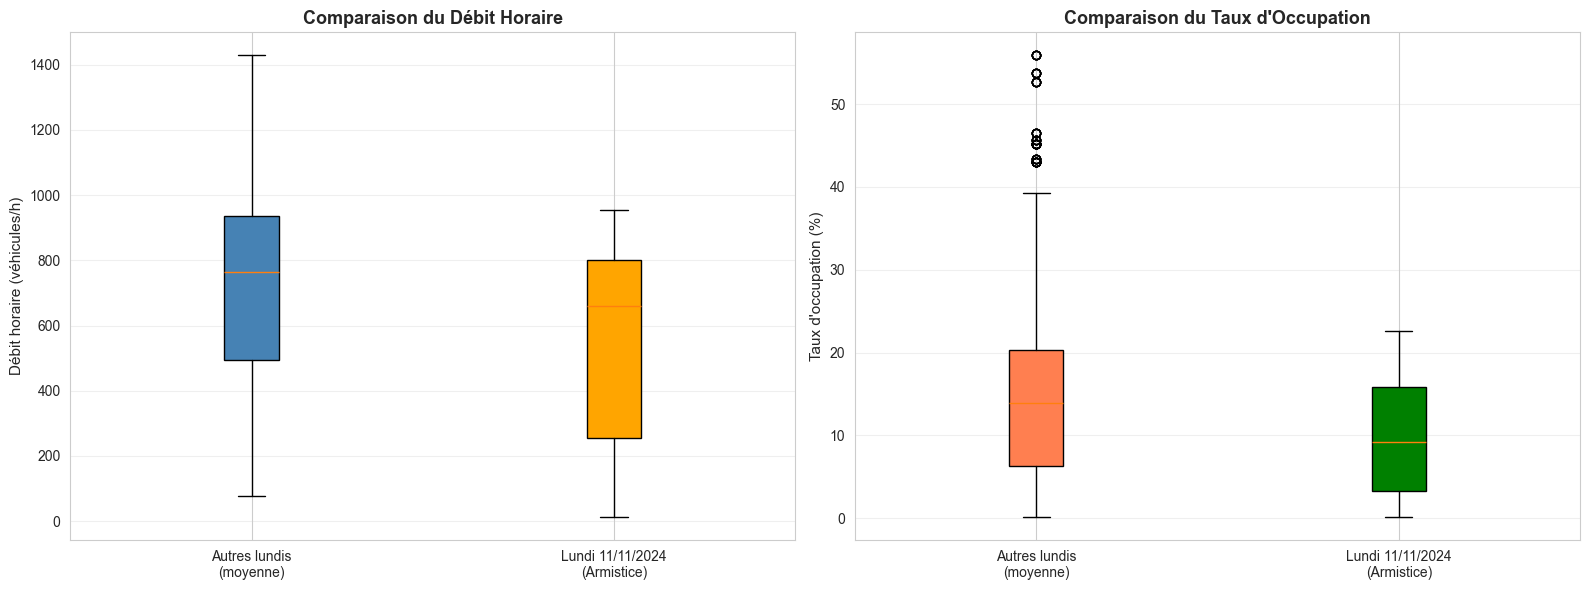


📊 Comparaison heure par heure (tous les lundis superposés):


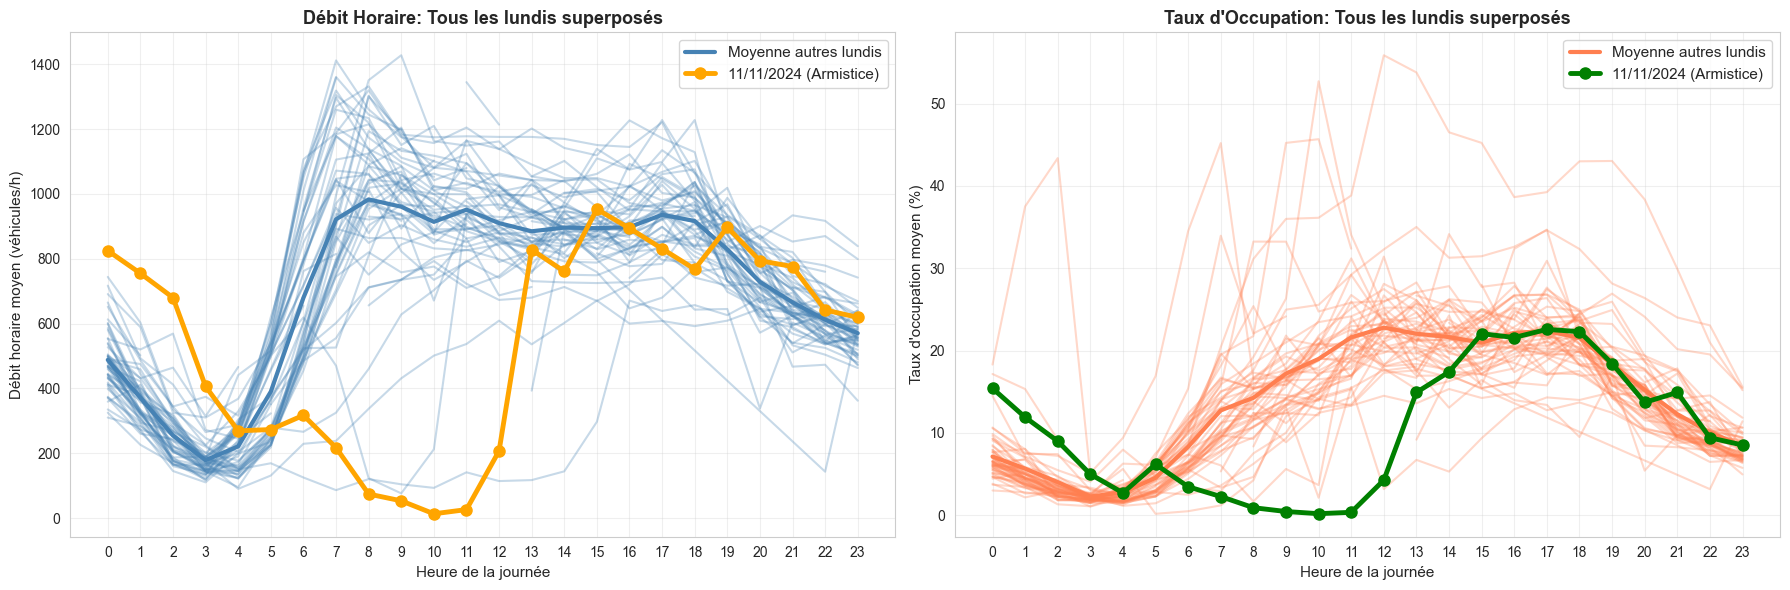


TABLEAU RÉCAPITULATIF

              Métrique 11/11/2024 Autres lundis (moy) Écart absolu Écart relatif
Débit horaire (véh/h)     536.58              705.50      -168.92        -23.9%
  Taux occupation (%)      10.32               13.91        -3.59        -25.8%



In [20]:
# ============================================================================
# ANALYSE SPÉCIALE: COMPARAISON DU 11/11/2024 (ARMISTICE) AVEC LES AUTRES LUNDIS
# ============================================================================
print("\n" + "="*80)
print("COMPARAISON DU LUNDI 11/11/2024 AVEC LES AUTRES LUNDIS")
print("="*80)

# Filtrer uniquement les lundis (jour_semaine = 0)
lundis = df_model[df_model['jour_semaine'] == 0].copy()

# Identifier le 11/11/2024
lundis['est_11_nov'] = lundis['date_heure_comptage'].dt.date == pd.Timestamp('2024-11-11').date()

# Séparer le 11/11 des autres lundis
lundi_11_nov = lundis[lundis['est_11_nov']]
autres_lundis = lundis[~lundis['est_11_nov']]

# Vérifier qu'on a des données
if len(lundi_11_nov) == 0:
    print("\n⚠️  Aucune donnée trouvée pour le 11/11/2024")
else:
    print(f"\n✓ Données trouvées:")
    print(f"  • 11/11/2024: {len(lundi_11_nov)} mesures horaires")
    
    # Lister tous les lundis disponibles
    lundis_uniques = autres_lundis['date_heure_comptage'].dt.date.unique()
    print(f"  • Autres lundis: {len(autres_lundis)} mesures horaires sur {len(lundis_uniques)} lundis différents")
    print(f"  • Dates des autres lundis: {sorted([str(d) for d in lundis_uniques])}")
    
    # Statistiques pour le 11/11/2024
    print("\n📊 LUNDI 11/11/2024 (Armistice - Jour férié):")
    debit_11nov = lundi_11_nov['debit_horaire'].mean()
    taux_11nov = lundi_11_nov['taux_occupation'].mean()
    nb_mesures_11nov = lundi_11_nov['debit_horaire'].notna().sum()
    
    if pd.notna(debit_11nov):
        print(f"  • Débit horaire moyen: {debit_11nov:.2f} véhicules/h")
        print(f"  • Taux occupation moyen: {taux_11nov:.2f}%")
        print(f"  • Nombre de mesures valides: {nb_mesures_11nov}")
    else:
        print("  ⚠️  Pas de données valides pour le débit/taux")
    
    # Statistiques pour les autres lundis
    print("\n📊 AUTRES LUNDIS (moyenne):")
    debit_autres = autres_lundis['debit_horaire'].mean()
    taux_autres = autres_lundis['taux_occupation'].mean()
    nb_mesures_autres = autres_lundis['debit_horaire'].notna().sum()
    
    if pd.notna(debit_autres):
        print(f"  • Débit horaire moyen: {debit_autres:.2f} véhicules/h")
        print(f"  • Taux occupation moyen: {taux_autres:.2f}%")
        print(f"  • Nombre de mesures valides: {nb_mesures_autres}")
    else:
        print("  ⚠️  Pas de données valides pour le débit/taux")
    
    # Calcul des écarts si on a les deux ensembles de données
    if pd.notna(debit_11nov) and pd.notna(debit_autres):
        print("\n📈 ÉCART (11/11 vs Autres lundis):")
        ecart_debit = debit_11nov - debit_autres
        ecart_taux = taux_11nov - taux_autres
        pct_debit = (ecart_debit / debit_autres * 100) if debit_autres != 0 else 0
        pct_taux = (ecart_taux / taux_autres * 100) if taux_autres != 0 else 0
        
        print(f"  • Débit horaire: {ecart_debit:+.2f} véhicules/h ({pct_debit:+.1f}%)")
        print(f"  • Taux occupation: {ecart_taux:+.2f}% ({pct_taux:+.1f}%)")
        
        # Interprétation
        print("\n💡 INTERPRÉTATION:")
        if ecart_debit < -50:
            print(f"  → Le 11/11 (jour férié) a un débit significativement INFÉRIEUR aux lundis normaux ({pct_debit:.1f}%)")
        elif ecart_debit > 50:
            print(f"  → Le 11/11 a un débit significativement SUPÉRIEUR aux lundis normaux ({pct_debit:.1f}%)")
        else:
            print(f"  → Le 11/11 a un débit similaire aux lundis normaux ({pct_debit:.1f}%)")
        
        # Visualisation comparative - Box plots
        print("\n📊 Génération des graphiques de comparaison...")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Débit horaire - Box plot
        data_debit = [autres_lundis['debit_horaire'].dropna(), 
                      lundi_11_nov['debit_horaire'].dropna()]
        
        if len(data_debit[0]) > 0 and len(data_debit[1]) > 0:
            bp1 = axes[0].boxplot(data_debit,
                                  labels=['Autres lundis\n(moyenne)', 'Lundi 11/11/2024\n(Armistice)'],
                                  patch_artist=True)
            bp1['boxes'][0].set_facecolor('steelblue')
            bp1['boxes'][1].set_facecolor('orange')
            axes[0].set_title('Comparaison du Débit Horaire', fontsize=13, fontweight='bold')
            axes[0].set_ylabel('Débit horaire (véhicules/h)', fontsize=11)
            axes[0].grid(True, alpha=0.3, axis='y')
        
        # Taux d'occupation - Box plot
        data_taux = [autres_lundis['taux_occupation'].dropna(), 
                     lundi_11_nov['taux_occupation'].dropna()]
        
        if len(data_taux[0]) > 0 and len(data_taux[1]) > 0:
            bp2 = axes[1].boxplot(data_taux,
                                  labels=['Autres lundis\n(moyenne)', 'Lundi 11/11/2024\n(Armistice)'],
                                  patch_artist=True)
            bp2['boxes'][0].set_facecolor('coral')
            bp2['boxes'][1].set_facecolor('green')
            axes[1].set_title('Comparaison du Taux d\'Occupation', fontsize=13, fontweight='bold')
            axes[1].set_ylabel('Taux d\'occupation (%)', fontsize=11)
            axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # NOUVELLE VISUALISATION: Comparaison heure par heure avec TOUS les lundis superposés
        print("\n📊 Comparaison heure par heure (tous les lundis superposés):")
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        
        # Pour chaque lundi, tracer sa courbe
        for date_lundi in lundis_uniques:
            lundi_data = autres_lundis[autres_lundis['date_heure_comptage'].dt.date == date_lundi]
            
            # Débit par heure pour ce lundi
            debit_by_hour = lundi_data.groupby('heure')['debit_horaire'].mean()
            if len(debit_by_hour) > 0:
                axes[0].plot(debit_by_hour.index, debit_by_hour.values, 
                           color='steelblue', alpha=0.3, linewidth=1.5)
            
            # Taux d'occupation par heure pour ce lundi
            taux_by_hour = lundi_data.groupby('heure')['taux_occupation'].mean()
            if len(taux_by_hour) > 0:
                axes[1].plot(taux_by_hour.index, taux_by_hour.values, 
                           color='coral', alpha=0.3, linewidth=1.5)
        
        # Tracer la moyenne des autres lundis (en gras)
        debit_autres_by_hour = autres_lundis.groupby('heure')['debit_horaire'].mean()
        axes[0].plot(debit_autres_by_hour.index, debit_autres_by_hour.values, 
                    color='steelblue', linewidth=3, label='Moyenne autres lundis', zorder=10)
        
        taux_autres_by_hour = autres_lundis.groupby('heure')['taux_occupation'].mean()
        axes[1].plot(taux_autres_by_hour.index, taux_autres_by_hour.values, 
                    color='coral', linewidth=3, label='Moyenne autres lundis', zorder=10)
        
        # Tracer le 11/11 (très visible)
        debit_11nov_by_hour = lundi_11_nov.groupby('heure')['debit_horaire'].mean()
        axes[0].plot(debit_11nov_by_hour.index, debit_11nov_by_hour.values, 
                    marker='o', linewidth=3.5, markersize=8, label='11/11/2024 (Armistice)', 
                    color='orange', zorder=15)
        
        taux_11nov_by_hour = lundi_11_nov.groupby('heure')['taux_occupation'].mean()
        axes[1].plot(taux_11nov_by_hour.index, taux_11nov_by_hour.values, 
                    marker='o', linewidth=3.5, markersize=8, label='11/11/2024 (Armistice)', 
                    color='green', zorder=15)
        
        # Configuration des graphiques
        axes[0].set_xlabel('Heure de la journée', fontsize=11)
        axes[0].set_ylabel('Débit horaire moyen (véhicules/h)', fontsize=11)
        axes[0].set_title('Débit Horaire: Tous les lundis superposés', fontsize=13, fontweight='bold')
        axes[0].set_xticks(range(0, 24))
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        
        axes[1].set_xlabel('Heure de la journée', fontsize=11)
        axes[1].set_ylabel('Taux d\'occupation moyen (%)', fontsize=11)
        axes[1].set_title('Taux d\'Occupation: Tous les lundis superposés', fontsize=13, fontweight='bold')
        axes[1].set_xticks(range(0, 24))
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Tableau récapitulatif
        print("\n" + "="*80)
        print("TABLEAU RÉCAPITULATIF")
        print("="*80)
        
        recap = pd.DataFrame({
            'Métrique': ['Débit horaire (véh/h)', 'Taux occupation (%)'],
            '11/11/2024': [
                f"{debit_11nov:.2f}",
                f"{taux_11nov:.2f}"
            ],
            'Autres lundis (moy)': [
                f"{debit_autres:.2f}",
                f"{taux_autres:.2f}"
            ],
            'Écart absolu': [
                f"{ecart_debit:+.2f}",
                f"{ecart_taux:+.2f}"
            ],
            'Écart relatif': [
                f"{pct_debit:+.1f}%",
                f"{pct_taux:+.1f}%"
            ]
        })
        
        print("\n", recap.to_string(index=False))

print("\n" + "="*80)

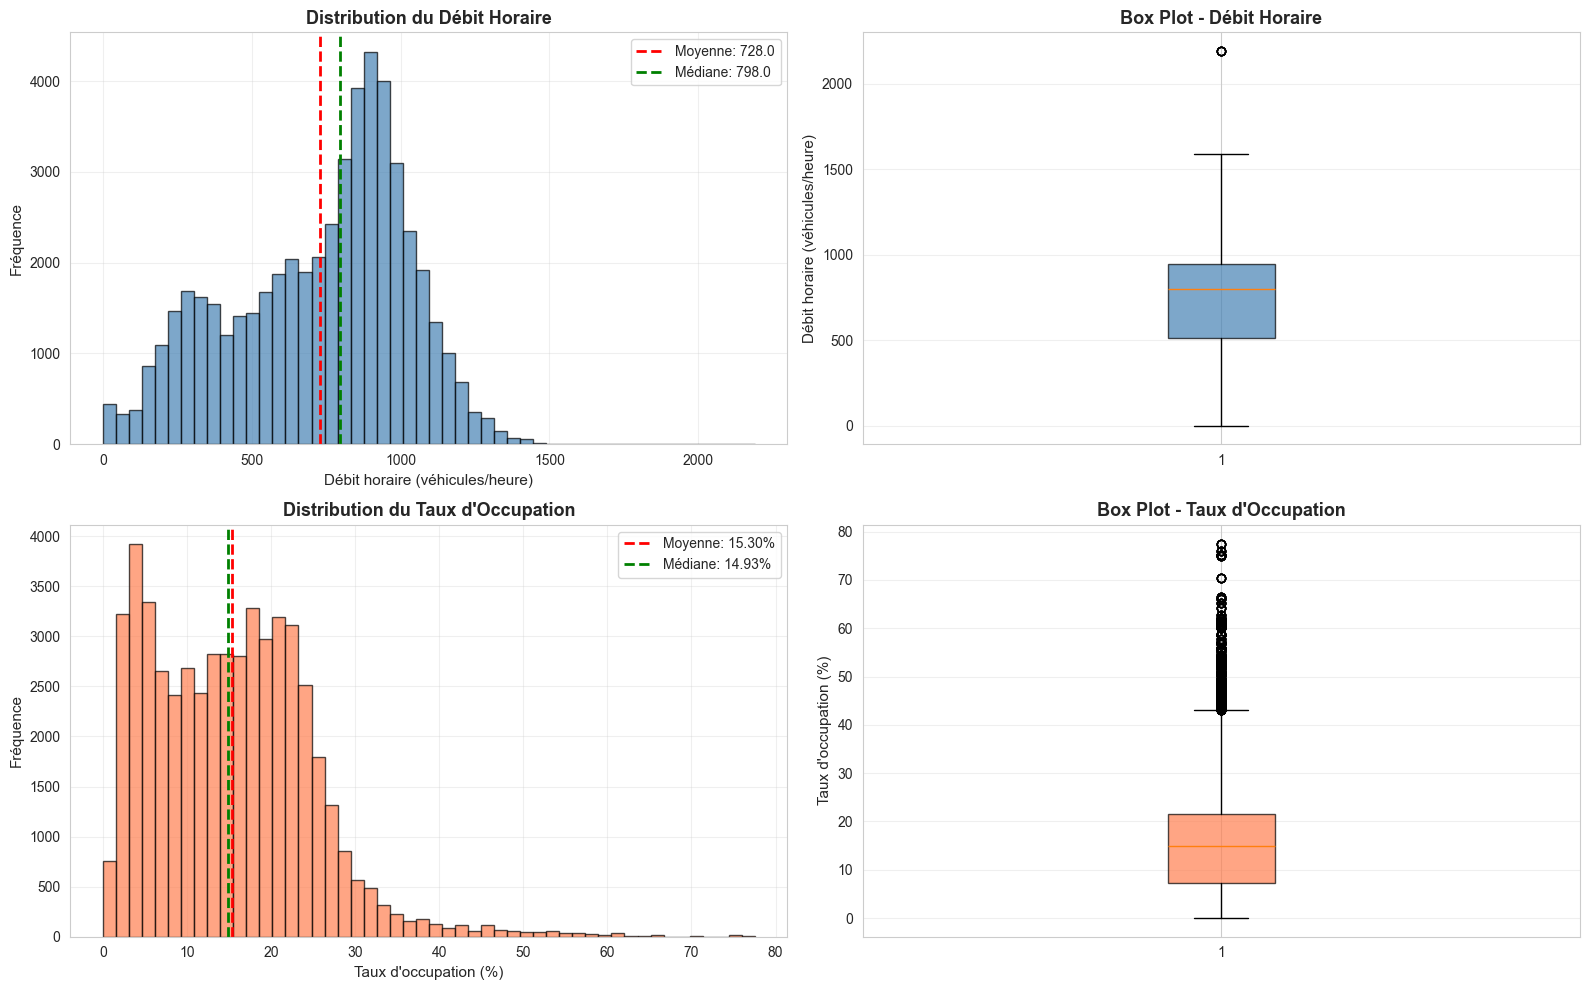

In [21]:
# Visualisation de la distribution des variables cibles
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Débit horaire - Histogramme
axes[0, 0].hist(df_model['debit_horaire'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_model['debit_horaire'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df_model["debit_horaire"].mean():.1f}')
axes[0, 0].axvline(df_model['debit_horaire'].median(), color='green', linestyle='--', linewidth=2, label=f'Médiane: {df_model["debit_horaire"].median():.1f}')
axes[0, 0].set_xlabel('Débit horaire (véhicules/heure)', fontsize=11)
axes[0, 0].set_ylabel('Fréquence', fontsize=11)
axes[0, 0].set_title('Distribution du Débit Horaire', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Débit horaire - Box plot
axes[0, 1].boxplot(df_model['debit_horaire'].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[0, 1].set_ylabel('Débit horaire (véhicules/heure)', fontsize=11)
axes[0, 1].set_title('Box Plot - Débit Horaire', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# Taux d'occupation - Histogramme
axes[1, 0].hist(df_model['taux_occupation'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df_model['taux_occupation'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df_model["taux_occupation"].mean():.2f}%')
axes[1, 0].axvline(df_model['taux_occupation'].median(), color='green', linestyle='--', linewidth=2, label=f'Médiane: {df_model["taux_occupation"].median():.2f}%')
axes[1, 0].set_xlabel('Taux d\'occupation (%)', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title('Distribution du Taux d\'Occupation', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Taux d'occupation - Box plot
axes[1, 1].boxplot(df_model['taux_occupation'].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='coral', alpha=0.7))
axes[1, 1].set_ylabel('Taux d\'occupation (%)', fontsize=11)
axes[1, 1].set_title('Box Plot - Taux d\'Occupation', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

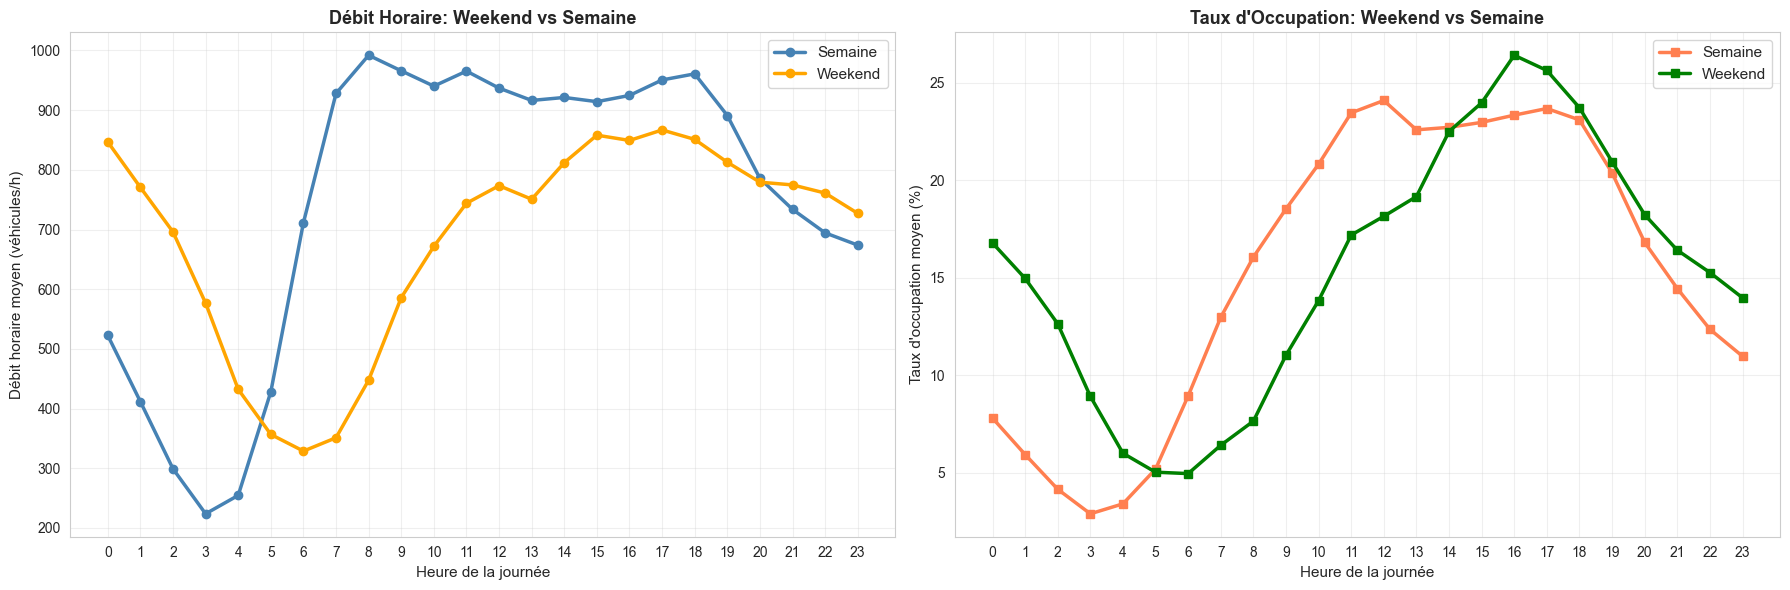

In [22]:
# Comparaison Weekend vs Semaine
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Débit horaire - Weekend vs Semaine
for weekend_flag, label, color in [(0, 'Semaine', 'steelblue'), (1, 'Weekend', 'orange')]:
    data_subset = df_model[df_model['est_weekend'] == weekend_flag]
    debit_by_hour = data_subset.groupby('heure')['debit_horaire'].mean()
    axes[0].plot(debit_by_hour.index, debit_by_hour.values, marker='o', linewidth=2.5, 
                markersize=6, label=label, color=color)

axes[0].set_xlabel('Heure de la journée', fontsize=11)
axes[0].set_ylabel('Débit horaire moyen (véhicules/h)', fontsize=11)
axes[0].set_title('Débit Horaire: Weekend vs Semaine', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(0, 24))
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Taux d'occupation - Weekend vs Semaine
for weekend_flag, label, color in [(0, 'Semaine', 'coral'), (1, 'Weekend', 'green')]:
    data_subset = df_model[df_model['est_weekend'] == weekend_flag]
    taux_by_hour = data_subset.groupby('heure')['taux_occupation'].mean()
    axes[1].plot(taux_by_hour.index, taux_by_hour.values, marker='s', linewidth=2.5, 
                markersize=6, label=label, color=color)

axes[1].set_xlabel('Heure de la journée', fontsize=11)
axes[1].set_ylabel('Taux d\'occupation moyen (%)', fontsize=11)
axes[1].set_title('Taux d\'Occupation: Weekend vs Semaine', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(0, 24))
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

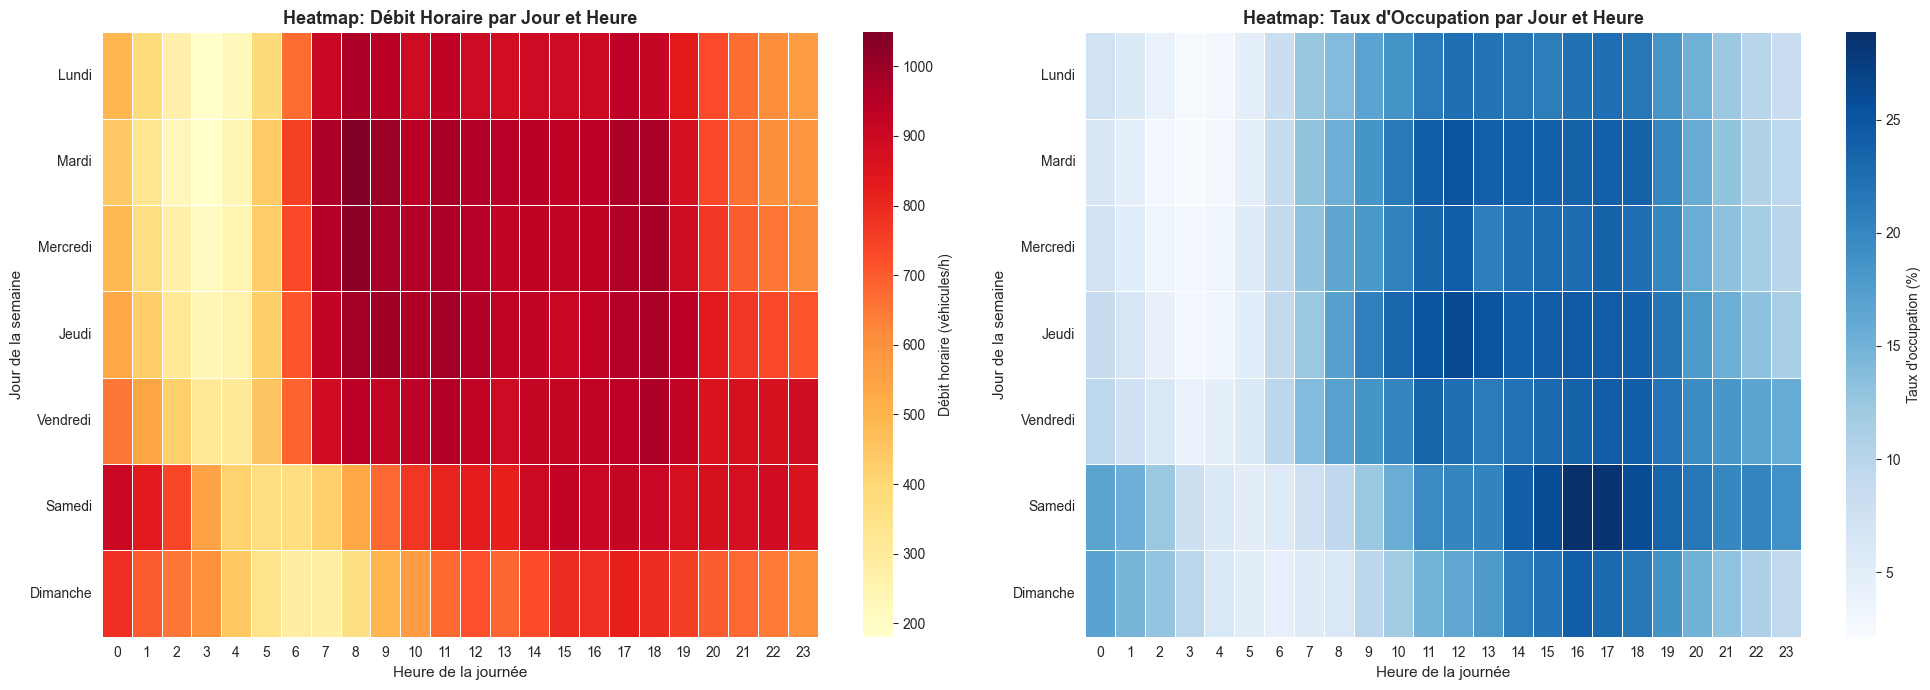

In [23]:
# Heatmaps - Patterns jour/heure
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Heatmap Débit horaire
pivot_debit = df_model.pivot_table(values='debit_horaire', 
                                     index='nom_jour', 
                                     columns='heure', 
                                     aggfunc='mean')

# Réordonner les jours
jours_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
jours_fr = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
pivot_debit = pivot_debit.reindex(jours_ordre)

sns.heatmap(pivot_debit, annot=False, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Débit horaire (véhicules/h)'}, ax=axes[0], linewidths=0.5)
axes[0].set_yticklabels(jours_fr, rotation=0)
axes[0].set_xlabel('Heure de la journée', fontsize=11)
axes[0].set_ylabel('Jour de la semaine', fontsize=11)
axes[0].set_title('Heatmap: Débit Horaire par Jour et Heure', fontsize=13, fontweight='bold')

# Heatmap Taux d'occupation
pivot_taux = df_model.pivot_table(values='taux_occupation', 
                                    index='nom_jour', 
                                    columns='heure', 
                                    aggfunc='mean')
pivot_taux = pivot_taux.reindex(jours_ordre)

sns.heatmap(pivot_taux, annot=False, fmt='.1f', cmap='Blues', 
            cbar_kws={'label': 'Taux d\'occupation (%)'}, ax=axes[1], linewidths=0.5)
axes[1].set_yticklabels(jours_fr, rotation=0)
axes[1].set_xlabel('Heure de la journée', fontsize=11)
axes[1].set_ylabel('Jour de la semaine', fontsize=11)
axes[1].set_title('Heatmap: Taux d\'Occupation par Jour et Heure', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

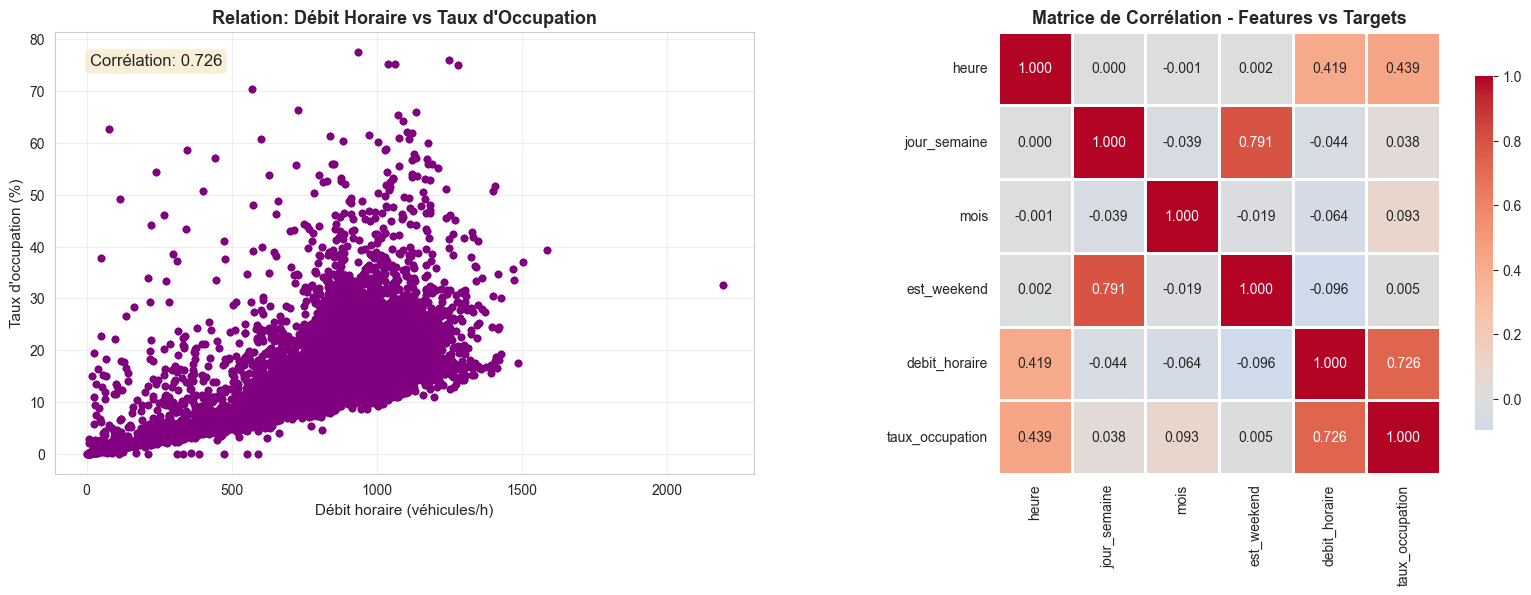

In [24]:
# Corrélation entre Débit horaire et Taux d'occupation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
df_complete = df_model.dropna(subset=['debit_horaire', 'taux_occupation'])
axes[0].scatter(df_complete['debit_horaire'], df_complete['taux_occupation'], 
               alpha=0.5, s=20, color='purple')
axes[0].set_xlabel('Débit horaire (véhicules/h)', fontsize=11)
axes[0].set_ylabel('Taux d\'occupation (%)', fontsize=11)
axes[0].set_title('Relation: Débit Horaire vs Taux d\'Occupation', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calcul et affichage de la corrélation
correlation = df_complete[['debit_horaire', 'taux_occupation']].corr().iloc[0, 1]
axes[0].text(0.05, 0.95, f'Corrélation: {correlation:.3f}', 
            transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Matrice de corrélation avec les features numériques
features_numeriques = ['heure', 'jour_semaine', 'mois', 'est_weekend', 'debit_horaire', 'taux_occupation']
corr_matrix = df_model[features_numeriques].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Matrice de Corrélation - Features vs Targets', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
# ============================================================================
# RÉSUMÉ DE L'EXPLORATION & INSIGHTS POUR LA MODÉLISATION
# ============================================================================

print("="*80)
print("RÉSUMÉ DE L'EXPLORATION - INSIGHTS POUR LA PRÉDICTION")
print("="*80)

print("\n📊 DONNÉES:")
print(f"  • Total de lignes: {len(df_model):,}")
print(f"  • Lignes complètes (sans NaN): {df_model.dropna().shape[0]:,} ({df_model.dropna().shape[0]/len(df_model)*100:.1f}%)")
print(f"  • Période: {df_model['date_heure_comptage'].min()} à {df_model['date_heure_comptage'].max()}")
print(f"  • Durée: {(df_model['date_heure_comptage'].max() - df_model['date_heure_comptage'].min()).days} jours")

print("\n🎯 VARIABLES CIBLES:")
print(f"  • debit_horaire:")
print(f"    - Moyenne: {df_model['debit_horaire'].mean():.1f} véhicules/h")
print(f"    - Médiane: {df_model['debit_horaire'].median():.1f} véhicules/h")
print(f"    - Écart-type: {df_model['debit_horaire'].std():.1f}")
print(f"    - Range: [{df_model['debit_horaire'].min():.0f} - {df_model['debit_horaire'].max():.0f}]")

print(f"  • taux_occupation:")
print(f"    - Moyenne: {df_model['taux_occupation'].mean():.2f}%")
print(f"    - Médiane: {df_model['taux_occupation'].median():.2f}%")
print(f"    - Écart-type: {df_model['taux_occupation'].std():.2f}")
print(f"    - Range: [{df_model['taux_occupation'].min():.2f}% - {df_model['taux_occupation'].max():.2f}%]")

corr_targets = df_model[['debit_horaire', 'taux_occupation']].corr().iloc[0, 1]
print(f"  • Corrélation entre les deux cibles: {corr_targets:.3f}")

print("\n📈 PATTERNS TEMPORELS IDENTIFIÉS:")
print("  • Forte variation selon l'heure de la journée (heures de pointe visibles)")
print("  • Différences significatives entre semaine et weekend")
print("  • Patterns réguliers par jour de la semaine")

# Identifier les heures de pointe
debit_by_hour = df_model.groupby('heure')['debit_horaire'].mean().sort_values(ascending=False)
heures_pointe = debit_by_hour.head(3).index.tolist()
print(f"  • Heures de pointe (top 3): {heures_pointe}")

print("\n🔍 FEATURES IMPORTANTES POUR LA PRÉDICTION:")
print("  1. heure - Pattern cyclique fort")
print("  2. jour_semaine - Différence semaine/weekend")
print("  3. est_weekend - Séparation semaine/weekend")
print("  4. etat_trafic - Information sur la fluidité")
print("  5. mois - Potentiellement saisonnalité")

print("\n⚠️  PROBLÈMES IDENTIFIÉS:")
print(f"  • 79.3% de valeurs manquantes dans les variables cibles")
print(f"  • Seulement {df_model.dropna().shape[0]:,} observations complètes disponibles")
print("  • État trafic 'Inconnu' représente 79.3% des données")

print("\n💡 RECOMMANDATIONS POUR LA MODÉLISATION:")
print("  1. Traiter les valeurs manquantes:")
print("     - Option 1: Utiliser uniquement les données complètes (1,919 lignes)")
print("     - Option 2: Imputation basée sur les patterns temporels similaires")
print("  ")
print("  2. Feature Engineering:")
print("     - Ajouter features cycliques: sin/cos de l'heure")
print("     - Créer indicateurs heures de pointe (7-9h, 17-19h)")
print("     - Lags temporels (valeurs des heures précédentes)")
print("     - Moyennes roulantes")
print("  ")
print("  3. Modèles recommandés:")
print("     - Régression linéaire/Ridge/Lasso (baseline)")
print("     - Random Forest / Gradient Boosting (capture des patterns non-linéaires)")
print("     - LSTM / GRU (si séries temporelles avec lags)")
print("  ")
print("  4. Validation:")
print("     - Split temporel (train sur anciennes données, test sur récentes)")
print("     - Cross-validation temporelle")
print("  ")
print("  5. Métriques:")
print("     - MAE, RMSE pour évaluer l'erreur de prédiction")
print("     - R² pour la variance expliquée")

print("\n" + "="*80)

RÉSUMÉ DE L'EXPLORATION - INSIGHTS POUR LA PRÉDICTION

📊 DONNÉES:
  • Total de lignes: 55,594
  • Lignes complètes (sans NaN): 17,288 (31.1%)
  • Période: 2024-09-01 03:00:00 à 2025-10-29 23:00:00
  • Durée: 423 jours

🎯 VARIABLES CIBLES:
  • debit_horaire:
    - Moyenne: 728.0 véhicules/h
    - Médiane: 798.0 véhicules/h
    - Écart-type: 295.5
    - Range: [0 - 2190]
  • taux_occupation:
    - Moyenne: 15.30%
    - Médiane: 14.93%
    - Écart-type: 9.66
    - Range: [0.00% - 77.55%]
  • Corrélation entre les deux cibles: 0.726

📈 PATTERNS TEMPORELS IDENTIFIÉS:
  • Forte variation selon l'heure de la journée (heures de pointe visibles)
  • Différences significatives entre semaine et weekend
  • Patterns réguliers par jour de la semaine
  • Heures de pointe (top 3): [18, 17, 16]

🔍 FEATURES IMPORTANTES POUR LA PRÉDICTION:
  1. heure - Pattern cyclique fort
  2. jour_semaine - Différence semaine/weekend
  3. est_weekend - Séparation semaine/weekend
  4. etat_trafic - Information sur la 

In [26]:
# Sauvegarde du dataframe nettoyé avec les features temporelles
print("Sauvegarde du dataframe avec features temporelles...")
df_model.to_csv('dataset/sts_peres_processed.csv', index=False)
print(f"✓ Fichier sauvegardé: dataset/sts_peres_processed.csv")
print(f"  Shape: {df_model.shape}")
print(f"  Colonnes: {list(df_model.columns)}")

print("\n📋 Variables du dataset final:")
print("  • date_heure_comptage: Date et heure de la mesure")
print("  • debit_horaire: Nombre de véhicules par heure (CIBLE)")
print("  • taux_occupation: Taux d'occupation de la route en % (CIBLE)")
print("  • etat_trafic: État du trafic (Fluide/Saturé/etc.)")
print("  • annee, mois, jour: Features temporelles extraites")
print("  • jour_semaine: 0=Lundi, 6=Dimanche")
print("  • nom_jour: Nom du jour en anglais")
print("  • heure: Heure de la journée (0-23)")
print("  • est_weekend: 1 si weekend, 0 sinon")

Sauvegarde du dataframe avec features temporelles...
✓ Fichier sauvegardé: dataset/sts_peres_processed.csv
  Shape: (55594, 15)
  Colonnes: ['date_heure_comptage', 'debit_horaire', 'taux_occupation', 'etat_trafic', 'annee', 'mois', 'jour', 'jour_semaine', 'nom_jour', 'heure', 'est_weekend', 'est_vacances', 'est_jour_ferie', 'temperature', 'humidite']

📋 Variables du dataset final:
  • date_heure_comptage: Date et heure de la mesure
  • debit_horaire: Nombre de véhicules par heure (CIBLE)
  • taux_occupation: Taux d'occupation de la route en % (CIBLE)
  • etat_trafic: État du trafic (Fluide/Saturé/etc.)
  • annee, mois, jour: Features temporelles extraites
  • jour_semaine: 0=Lundi, 6=Dimanche
  • nom_jour: Nom du jour en anglais
  • heure: Heure de la journée (0-23)
  • est_weekend: 1 si weekend, 0 sinon


In [27]:
# ============================================================================
# MODÉLISATION - XGBOOST
# ============================================================================
print("="*80)
print("PRÉPARATION DES DONNÉES POUR LA MODÉLISATION")
print("="*80)

# Filtrer uniquement les lignes complètes (sans NaN dans les cibles)
df_clean = df_model.dropna(subset=['debit_horaire', 'taux_occupation']).copy()

print(f"\nDonnées originales: {len(df_model)} lignes")
print(f"Données complètes: {len(df_clean)} lignes ({len(df_clean)/len(df_model)*100:.1f}%)")

# Sélection des features pour la modélisation
# IMPORTANT: On n'inclut PAS etat_trafic car c'est une variable corrélée aux cibles
# (data leakage - etat_trafic est déterminé à partir de debit et taux_occupation)

# Features temporelles de base (toujours présentes)
features_finales = ['heure', 'jour_semaine', 'mois', 'est_weekend']

# Features vacances/jours fériés (si disponibles)
features_vacances = ['est_vacances', 'est_jour_ferie']
for feature in features_vacances:
    if feature in df_clean.columns:
        features_finales.append(feature)
        print(f"✓ Feature '{feature}' ajoutée")
    else:
        print(f"⚠️  Feature '{feature}' non disponible (exécutez d'abord la cellule d'intégration météo/vacances)")

# Features météo (si disponibles et avec assez de données)
features_meteo = ['temperature', 'humidite', 'precipitation']
for feature in features_meteo:
    if feature in df_clean.columns:
        nb_valeurs = df_clean[feature].notna().sum()
        pct_valeurs = nb_valeurs / len(df_clean) * 100
        if pct_valeurs > 50:  # Au moins 50% de données disponibles
            features_finales.append(feature)
            print(f"✓ Feature météo '{feature}' ajoutée ({pct_valeurs:.1f}% de données)")
        else:
            print(f"⚠️  Feature météo '{feature}' exclue (seulement {pct_valeurs:.1f}% de données)")
    else:
        print(f"⚠️  Feature météo '{feature}' non disponible (exécutez d'abord la cellule d'intégration météo/vacances)")

print(f"\n✓ Features utilisées: {features_finales}")
print(f"⚠️  Note: 'etat_trafic' est EXCLU car corrélé aux variables cibles (data leakage)")

# Créer le dataframe final avec toutes les features
X = df_clean[features_finales].copy()
y_debit = df_clean['debit_horaire'].copy()
y_taux = df_clean['taux_occupation'].copy()

print(f"\nShape des données:")
print(f"  X (features): {X.shape}")
print(f"  y_debit (target 1): {y_debit.shape}")
print(f"  y_taux (target 2): {y_taux.shape}")

# Gérer les valeurs manquantes dans les features
nb_nan_avant = X.isna().sum().sum()
if nb_nan_avant > 0:
    print(f"\n⚠️  {nb_nan_avant} valeurs manquantes détectées dans les features")
    print("Colonnes avec NaN:")
    for col in X.columns:
        nb_nan = X[col].isna().sum()
        if nb_nan > 0:
            print(f"  - {col}: {nb_nan} ({nb_nan/len(X)*100:.1f}%)")
    
    # Remplir les valeurs manquantes avec la médiane
    print("\nRemplissage des valeurs manquantes avec la médiane...")
    X = X.fillna(X.median())
    print(f"✓ Valeurs manquantes remplies")

print("\nAperçu des features:")
X.head()

PRÉPARATION DES DONNÉES POUR LA MODÉLISATION

Données originales: 55594 lignes
Données complètes: 51863 lignes (93.3%)
✓ Feature 'est_vacances' ajoutée
✓ Feature 'est_jour_ferie' ajoutée
✓ Feature météo 'temperature' ajoutée (100.0% de données)
⚠️  Feature météo 'humidite' exclue (seulement 33.3% de données)
⚠️  Feature météo 'precipitation' non disponible (exécutez d'abord la cellule d'intégration météo/vacances)

✓ Features utilisées: ['heure', 'jour_semaine', 'mois', 'est_weekend', 'est_vacances', 'est_jour_ferie', 'temperature']
⚠️  Note: 'etat_trafic' est EXCLU car corrélé aux variables cibles (data leakage)

Shape des données:
  X (features): (51863, 7)
  y_debit (target 1): (51863,)
  y_taux (target 2): (51863,)

⚠️  9 valeurs manquantes détectées dans les features
Colonnes avec NaN:
  - temperature: 9 (0.0%)

Remplissage des valeurs manquantes avec la médiane...
✓ Valeurs manquantes remplies

Aperçu des features:


heure  jour_semaine  mois  est_weekend  est_vacances  est_jour_ferie  \
0      4             0    12            0             0               0   
1      4             0    12            0             0               0   
2      4             0    12            0             0               0   
3      4             0    12            0             0               0   
4      4             0    12            0             0               0   

   temperature  
0          5.4  
1          3.2  
2          5.9  
3          5.4  
4          5.4

In [28]:
# ============================================================================
# MODÈLE AMÉLIORÉ - Feature Engineering pour mieux prédire les pics
# ============================================================================
print("\n" + "="*80)
print("CRÉATION DE FEATURES AVANCÉES POUR AMÉLIORER LES PICS")
print("="*80)

# Travailler sur une copie de df_clean
df_clean_advanced = df_clean.copy()

# 1. HEURE DE POINTE (booléen)
df_clean_advanced['heure_de_pointe'] = ((df_clean_advanced['heure'] >= 7) & (df_clean_advanced['heure'] <= 9) | 
                                         (df_clean_advanced['heure'] >= 17) & (df_clean_advanced['heure'] <= 19)).astype(int)

# 2. FEATURES CYCLIQUES (sin/cos pour capturer la nature cyclique du temps)
df_clean_advanced['heure_sin'] = np.sin(2 * np.pi * df_clean_advanced['heure'] / 24)
df_clean_advanced['heure_cos'] = np.cos(2 * np.pi * df_clean_advanced['heure'] / 24)

df_clean_advanced['jour_semaine_sin'] = np.sin(2 * np.pi * df_clean_advanced['jour_semaine'] / 7)
df_clean_advanced['jour_semaine_cos'] = np.cos(2 * np.pi * df_clean_advanced['jour_semaine'] / 7)

# 3. INTERACTION: heure * jour_semaine
df_clean_advanced['heure_x_joursemaine'] = df_clean_advanced['heure'] * df_clean_advanced['jour_semaine']

# 4. HEURE AU CARRÉ (pour capturer les non-linéarités)
df_clean_advanced['heure_2'] = df_clean_advanced['heure'] ** 2

print("\n✓ Features avancées créées:")
print("  • heure_de_pointe: booléen pour 7-9h et 17-19h")
print("  • heure_sin, heure_cos: features cycliques pour l'heure")
print("  • jour_semaine_sin, jour_semaine_cos: features cycliques pour le jour")
print("  • heure_x_joursemaine: interaction heure * jour_semaine")
print("  • heure_2: heure au carré")

# Préparer les features finales améliorées
features_finales_advanced = features_finales.copy()  # Partir des features de base
features_finales_advanced.extend([
    'heure_de_pointe',
    'heure_sin', 'heure_cos',
    'jour_semaine_sin', 'jour_semaine_cos',
    'heure_x_joursemaine',
    'heure_2'
])

print(f"\n✓ Nombre de features:")
print(f"  • Modèle de base: {len(features_finales)} features")
print(f"  • Modèle amélioré: {len(features_finales_advanced)} features")
print(f"\n  Features ajoutées: {len(features_finales_advanced) - len(features_finales)}")

# Créer X amélioré
X_advanced = df_clean_advanced[features_finales_advanced].copy()

# Gérer les valeurs manquantes si nécessaire
nb_nan = X_advanced.isna().sum().sum()
if nb_nan > 0:
    print(f"\n⚠️  {nb_nan} valeurs manquantes détectées, remplissage avec la médiane...")
    X_advanced = X_advanced.fillna(X_advanced.median())

print(f"\nShape de X_advanced: {X_advanced.shape}")
print("\nAperçu des nouvelles features:")
print(X_advanced[['heure', 'heure_de_pointe', 'heure_sin', 'heure_cos', 'heure_2']].head())


CRÉATION DE FEATURES AVANCÉES POUR AMÉLIORER LES PICS

✓ Features avancées créées:
  • heure_de_pointe: booléen pour 7-9h et 17-19h
  • heure_sin, heure_cos: features cycliques pour l'heure
  • jour_semaine_sin, jour_semaine_cos: features cycliques pour le jour
  • heure_x_joursemaine: interaction heure * jour_semaine
  • heure_2: heure au carré

✓ Nombre de features:
  • Modèle de base: 7 features
  • Modèle amélioré: 14 features

  Features ajoutées: 7

⚠️  9 valeurs manquantes détectées, remplissage avec la médiane...

Shape de X_advanced: (51863, 14)

Aperçu des nouvelles features:
   heure  heure_de_pointe  heure_sin  heure_cos  heure_2
0      4                0   0.866025        0.5       16
1      4                0   0.866025        0.5       16
2      4                0   0.866025        0.5       16
3      4                0   0.866025        0.5       16
4      4                0   0.866025        0.5       16


In [35]:
# Split Train/Test avec les features améliorées
print("\n" + "="*80)
print("SPLIT TRAIN/TEST (Modèle Amélioré)")
print("="*80)

# Même split que précédemment pour comparaison équitable
df_clean_advanced_sorted = df_clean_advanced.sort_values('date_heure_comptage').reset_index(drop=True)
split_idx = int(len(df_clean_advanced_sorted) * 0.8)

train_data_adv = df_clean_advanced_sorted.iloc[:split_idx]
test_data_adv = df_clean_advanced_sorted.iloc[split_idx:]

X_train_adv = train_data_adv[features_finales_advanced]
X_test_adv = test_data_adv[features_finales_advanced]
y_train_debit_adv = train_data_adv['debit_horaire']
y_test_debit_adv = test_data_adv['debit_horaire']
y_train_taux_adv = train_data_adv['taux_occupation']
y_test_taux_adv = test_data_adv['taux_occupation']

print(f"\nTaille des ensembles:")
print(f"  Train: {len(X_train_adv)} lignes")
print(f"  Test:  {len(X_test_adv)} lignes")
print(f"  Nombre de features: {X_train_adv.shape[1]}")


SPLIT TRAIN/TEST (Modèle Amélioré)

Taille des ensembles:
  Train: 41490 lignes
  Test:  10373 lignes
  Nombre de features: 14


In [36]:
# Split temporel Train/Test (80/20)
print("\n" + "="*80)
print("SPLIT TRAIN/TEST TEMPOREL")
print("="*80)

from sklearn.model_selection import train_test_split

# Trier les données par date
df_clean_sorted = df_clean.sort_values('date_heure_comptage').reset_index(drop=True)

# Split temporel: 80% train, 20% test
split_idx = int(len(df_clean_sorted) * 0.8)

train_data = df_clean_sorted.iloc[:split_idx]
test_data = df_clean_sorted.iloc[split_idx:]

X_train = train_data[features_finales]
X_test = test_data[features_finales]
y_train_debit = train_data['debit_horaire']
y_test_debit = test_data['debit_horaire']
y_train_taux = train_data['taux_occupation']
y_test_taux = test_data['taux_occupation']

print(f"\nTaille des ensembles:")
print(f"  Train: {len(X_train)} lignes ({len(X_train)/len(df_clean_sorted)*100:.1f}%)")
print(f"  Test:  {len(X_test)} lignes ({len(X_test)/len(df_clean_sorted)*100:.1f}%)")

print(f"\nPériode train: {train_data['date_heure_comptage'].min()} à {train_data['date_heure_comptage'].max()}")
print(f"Période test:  {test_data['date_heure_comptage'].min()} à {test_data['date_heure_comptage'].max()}")

print(f"\nStatistiques Train:")
print(f"  debit_horaire - Moyenne: {y_train_debit.mean():.1f}, Std: {y_train_debit.std():.1f}")
print(f"  taux_occupation - Moyenne: {y_train_taux.mean():.2f}, Std: {y_train_taux.std():.2f}")

print(f"\nStatistiques Test:")
print(f"  debit_horaire - Moyenne: {y_test_debit.mean():.1f}, Std: {y_test_debit.std():.1f}")
print(f"  taux_occupation - Moyenne: {y_test_taux.mean():.2f}, Std: {y_test_taux.std():.2f}")


SPLIT TRAIN/TEST TEMPOREL

Taille des ensembles:
  Train: 41490 lignes (80.0%)
  Test:  10373 lignes (20.0%)

Période train: 2024-09-01 03:00:00 à 2025-08-15 16:00:00
Période test:  2025-08-15 17:00:00 à 2025-10-29 23:00:00

Statistiques Train:
  debit_horaire - Moyenne: 730.8, Std: 304.2
  taux_occupation - Moyenne: 15.05, Std: 9.52

Statistiques Test:
  debit_horaire - Moyenne: 727.1, Std: 253.7
  taux_occupation - Moyenne: 16.30, Std: 10.14


In [37]:
# Entraînement XGBoost - Modèle 1: Débit Horaire
print("\n" + "="*80)
print("MODÈLE 1: PRÉDICTION DU DÉBIT HORAIRE")
print("="*80)

# Fix pour libomp sur Mac - définir le chemin de la bibliothèque
import os
os.environ['DYLD_LIBRARY_PATH'] = '/usr/local/opt/libomp/lib:/usr/local/Cellar/libomp/21.1.4/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# Paramètres du modèle XGBoost
params_debit = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 20
}

print("\nParamètres du modèle:")
for key, value in params_debit.items():
    print(f"  {key}: {value}")

# Entraînement
print("\n⏳ Entraînement en cours...")
start_time = time.time()

model_debit = xgb.XGBRegressor(**params_debit)
model_debit.fit(X_train, y_train_debit, 
                eval_set=[(X_train, y_train_debit), (X_test, y_test_debit)],
                verbose=False)

training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f} secondes")

# Prédictions
y_train_pred_debit = model_debit.predict(X_train)
y_test_pred_debit = model_debit.predict(X_test)

# Métriques
print("\n" + "="*80)
print("RÉSULTATS - DÉBIT HORAIRE")
print("="*80)

print("\nTRAIN:")
print(f"  MAE:  {mean_absolute_error(y_train_debit, y_train_pred_debit):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_debit, y_train_pred_debit)):.2f}")
print(f"  R²:   {r2_score(y_train_debit, y_train_pred_debit):.4f}")

print("\nTEST:")
print(f"  MAE:  {mean_absolute_error(y_test_debit, y_test_pred_debit):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_debit, y_test_pred_debit)):.2f}")
print(f"  R²:   {r2_score(y_test_debit, y_test_pred_debit):.4f}")

print(f"\nBest iteration: {model_debit.best_iteration}")


MODÈLE 1: PRÉDICTION DU DÉBIT HORAIRE

Paramètres du modèle:
  objective: reg:squarederror
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 200
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  early_stopping_rounds: 20

⏳ Entraînement en cours...
✓ Entraînement terminé en 0.09 secondes

RÉSULTATS - DÉBIT HORAIRE

TRAIN:
  MAE:  111.41
  RMSE: 159.43
  R²:   0.7253

TEST:
  MAE:  107.06
  RMSE: 141.36
  R²:   0.6894

Best iteration: 23


In [38]:
# Entraînement XGBoost - Modèle 2: Taux d'Occupation
print("\n" + "="*80)
print("MODÈLE 2: PRÉDICTION DU TAUX D'OCCUPATION")
print("="*80)

# Paramètres du modèle XGBoost (mêmes paramètres)
params_taux = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 20
}

print("\nParamètres du modèle:")
for key, value in params_taux.items():
    print(f"  {key}: {value}")

# Entraînement
print("\n⏳ Entraînement en cours...")
start_time = time.time()

model_taux = xgb.XGBRegressor(**params_taux)
model_taux.fit(X_train, y_train_taux, 
               eval_set=[(X_train, y_train_taux), (X_test, y_test_taux)],
               verbose=False)

training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f} secondes")

# Prédictions
y_train_pred_taux = model_taux.predict(X_train)
y_test_pred_taux = model_taux.predict(X_test)

# Métriques
print("\n" + "="*80)
print("RÉSULTATS - TAUX D'OCCUPATION")
print("="*80)

print("\nTRAIN:")
print(f"  MAE:  {mean_absolute_error(y_train_taux, y_train_pred_taux):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_taux, y_train_pred_taux)):.2f}")
print(f"  R²:   {r2_score(y_train_taux, y_train_pred_taux):.4f}")

print("\nTEST:")
print(f"  MAE:  {mean_absolute_error(y_test_taux, y_test_pred_taux):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_taux, y_test_pred_taux)):.2f}")
print(f"  R²:   {r2_score(y_test_taux, y_test_pred_taux):.4f}")

print(f"\nBest iteration: {model_taux.best_iteration}")


MODÈLE 2: PRÉDICTION DU TAUX D'OCCUPATION

Paramètres du modèle:
  objective: reg:squarederror
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 200
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  early_stopping_rounds: 20

⏳ Entraînement en cours...
✓ Entraînement terminé en 0.09 secondes

RÉSULTATS - TAUX D'OCCUPATION

TRAIN:
  MAE:  3.47
  RMSE: 5.59
  R²:   0.6546

TEST:
  MAE:  3.96
  RMSE: 6.85
  R²:   0.5441

Best iteration: 25



IMPORTANCE DES FEATURES


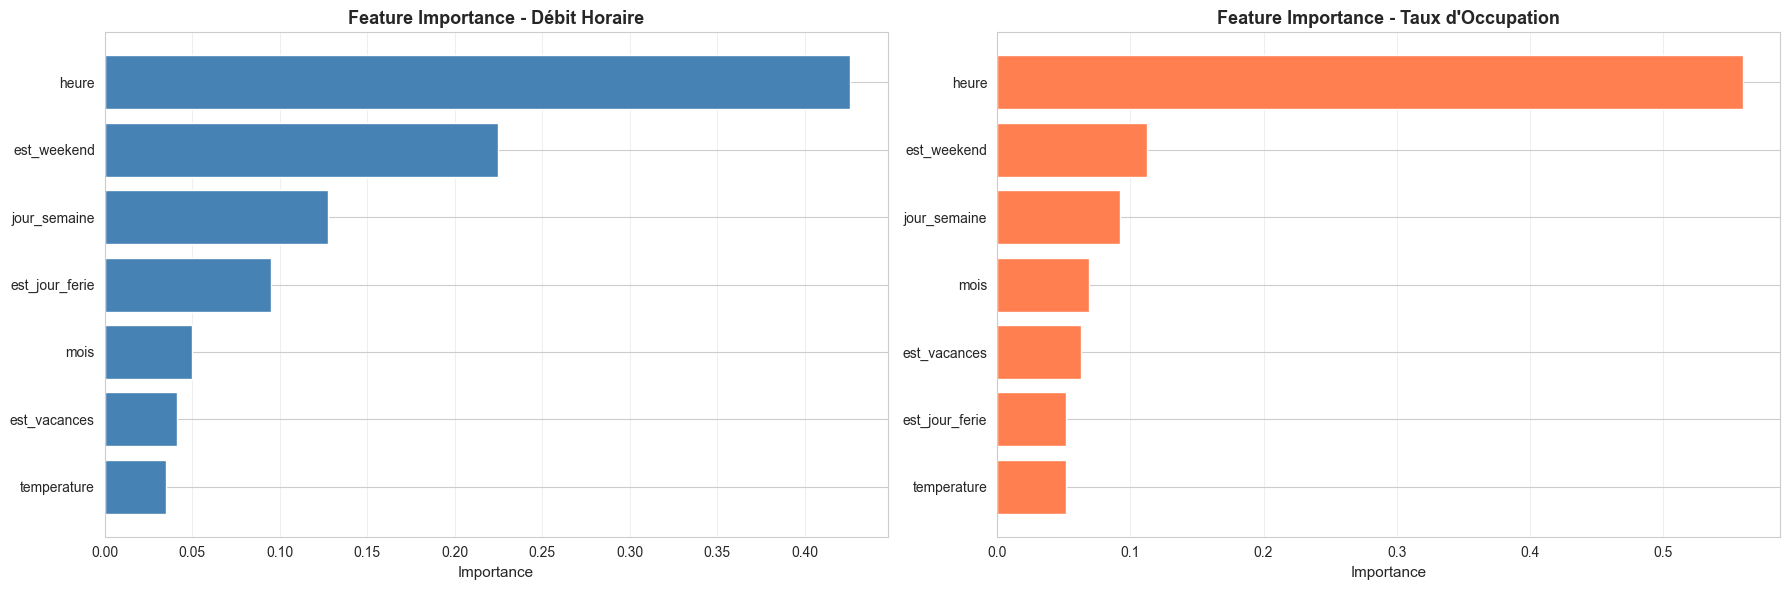


Feature Importance - Débit Horaire:
       feature  importance
         heure    0.426038
   est_weekend    0.224965
  jour_semaine    0.127470
est_jour_ferie    0.094851
          mois    0.050022
  est_vacances    0.041471
   temperature    0.035183

Feature Importance - Taux d'Occupation:
       feature  importance
         heure    0.559673
   est_weekend    0.112577
  jour_semaine    0.092138
          mois    0.069191
  est_vacances    0.062743
est_jour_ferie    0.051840
   temperature    0.051837


In [39]:
# Feature Importance
print("\n" + "="*80)
print("IMPORTANCE DES FEATURES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Feature importance pour débit_horaire
feature_importance_debit = pd.DataFrame({
    'feature': features_finales,
    'importance': model_debit.feature_importances_
}).sort_values('importance', ascending=False)

axes[0].barh(range(len(feature_importance_debit)), feature_importance_debit['importance'], color='steelblue')
axes[0].set_yticks(range(len(feature_importance_debit)))
axes[0].set_yticklabels(feature_importance_debit['feature'])
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Feature Importance - Débit Horaire', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Feature importance pour taux_occupation
feature_importance_taux = pd.DataFrame({
    'feature': features_finales,
    'importance': model_taux.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(range(len(feature_importance_taux)), feature_importance_taux['importance'], color='coral')
axes[1].set_yticks(range(len(feature_importance_taux)))
axes[1].set_yticklabels(feature_importance_taux['feature'])
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('Feature Importance - Taux d\'Occupation', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFeature Importance - Débit Horaire:")
print(feature_importance_debit.to_string(index=False))

print("\nFeature Importance - Taux d'Occupation:")
print(feature_importance_taux.to_string(index=False))

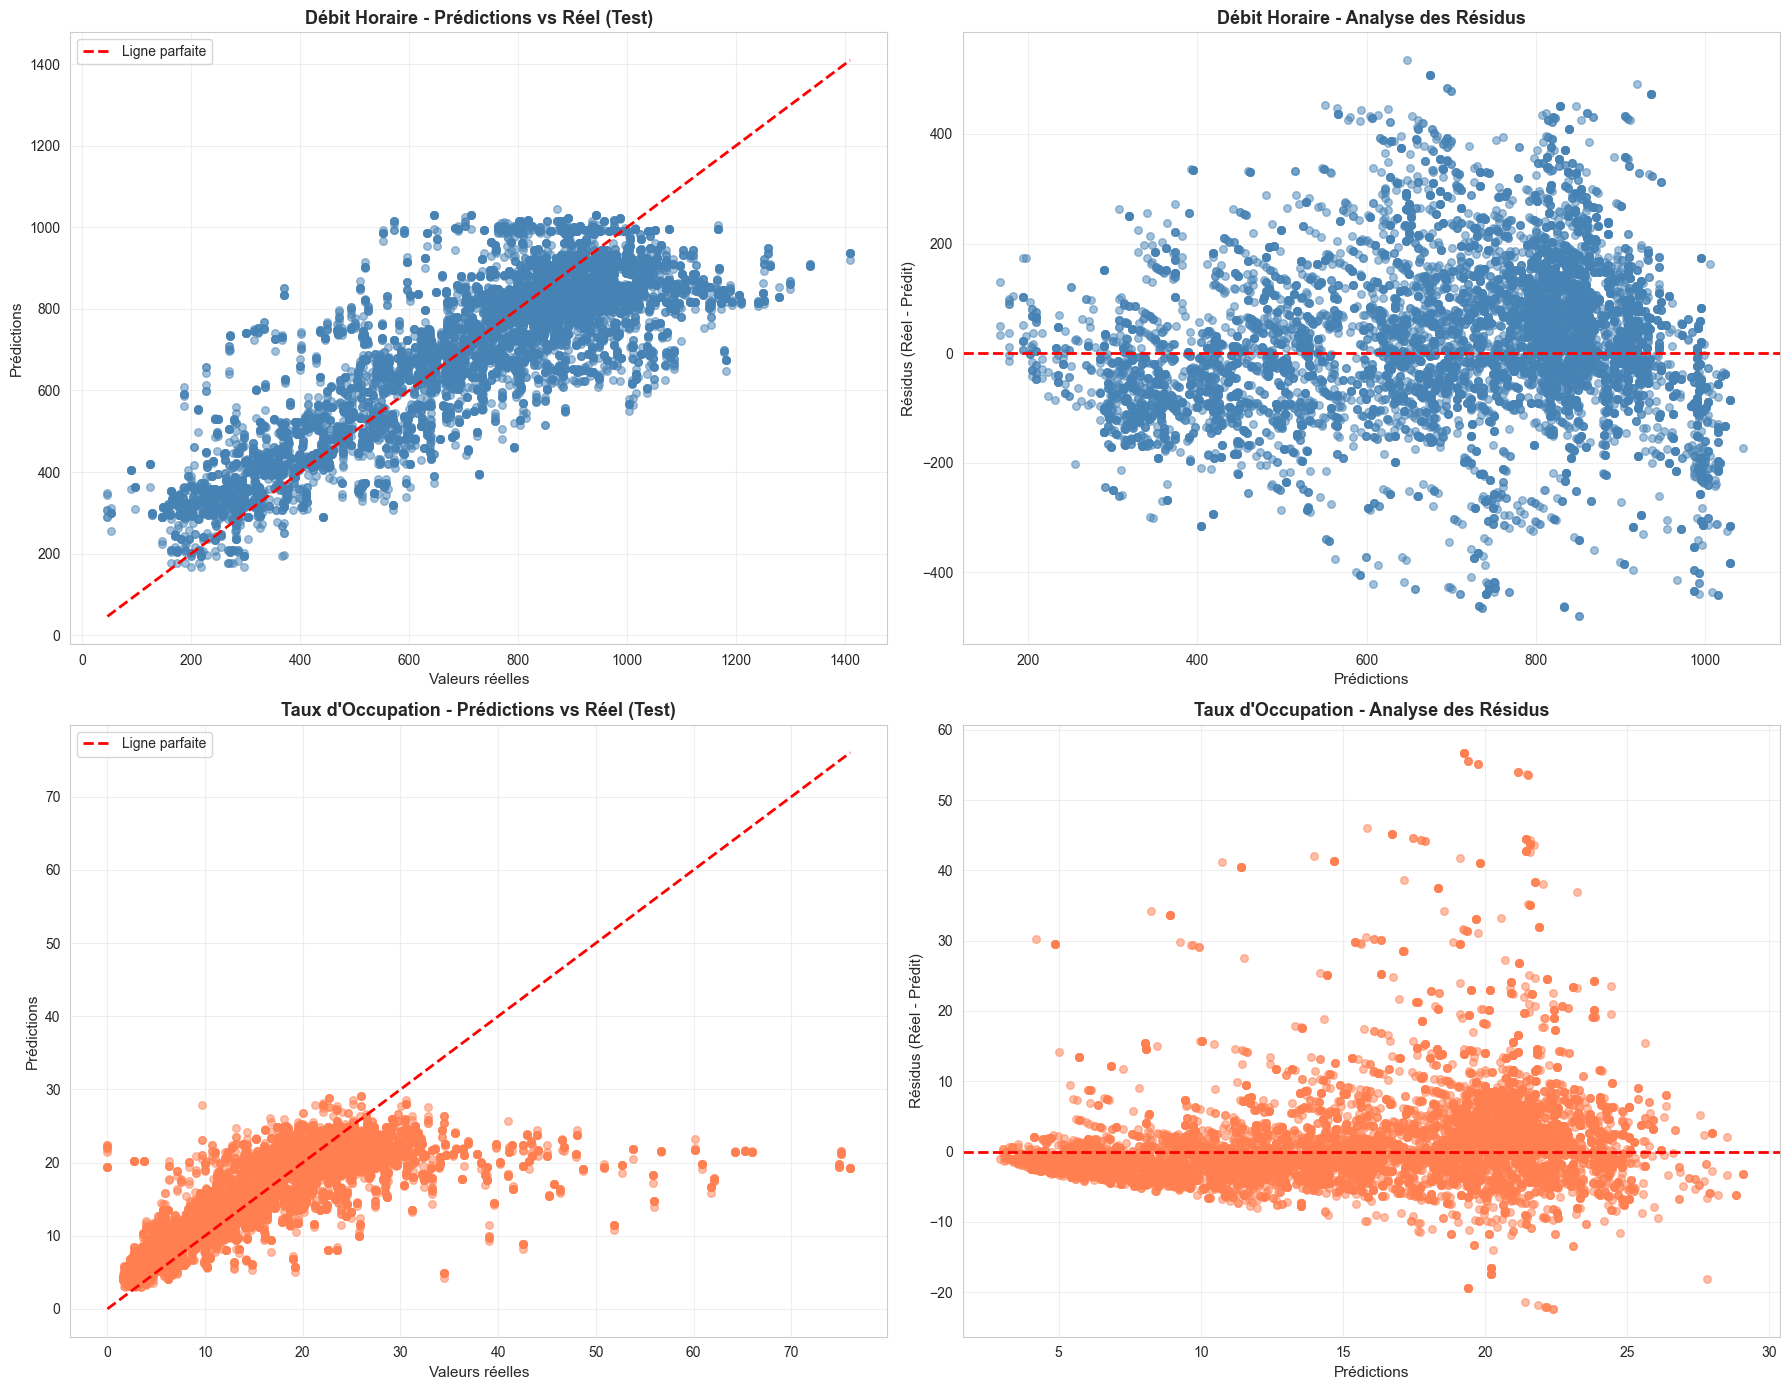

In [40]:
# Visualisation des prédictions vs valeurs réelles
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Débit Horaire - Scatter plot
axes[0, 0].scatter(y_test_debit, y_test_pred_debit, alpha=0.5, s=30, color='steelblue')
axes[0, 0].plot([y_test_debit.min(), y_test_debit.max()], 
                [y_test_debit.min(), y_test_debit.max()], 
                'r--', lw=2, label='Ligne parfaite')
axes[0, 0].set_xlabel('Valeurs réelles', fontsize=11)
axes[0, 0].set_ylabel('Prédictions', fontsize=11)
axes[0, 0].set_title('Débit Horaire - Prédictions vs Réel (Test)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Débit Horaire - Résidus
residus_debit = y_test_debit - y_test_pred_debit
axes[0, 1].scatter(y_test_pred_debit, residus_debit, alpha=0.5, s=30, color='steelblue')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Prédictions', fontsize=11)
axes[0, 1].set_ylabel('Résidus (Réel - Prédit)', fontsize=11)
axes[0, 1].set_title('Débit Horaire - Analyse des Résidus', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Taux d'Occupation - Scatter plot
axes[1, 0].scatter(y_test_taux, y_test_pred_taux, alpha=0.5, s=30, color='coral')
axes[1, 0].plot([y_test_taux.min(), y_test_taux.max()], 
                [y_test_taux.min(), y_test_taux.max()], 
                'r--', lw=2, label='Ligne parfaite')
axes[1, 0].set_xlabel('Valeurs réelles', fontsize=11)
axes[1, 0].set_ylabel('Prédictions', fontsize=11)
axes[1, 0].set_title('Taux d\'Occupation - Prédictions vs Réel (Test)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Taux d'Occupation - Résidus
residus_taux = y_test_taux - y_test_pred_taux
axes[1, 1].scatter(y_test_pred_taux, residus_taux, alpha=0.5, s=30, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Prédictions', fontsize=11)
axes[1, 1].set_ylabel('Résidus (Réel - Prédit)', fontsize=11)
axes[1, 1].set_title('Taux d\'Occupation - Analyse des Résidus', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


PRÉDICTIONS VS VALEURS RÉELLES - SÉRIE TEMPORELLE

✓ Période de test: 2025-08-15 17:00:00 à 2025-10-29 23:00:00
✓ Nombre de points: 10373


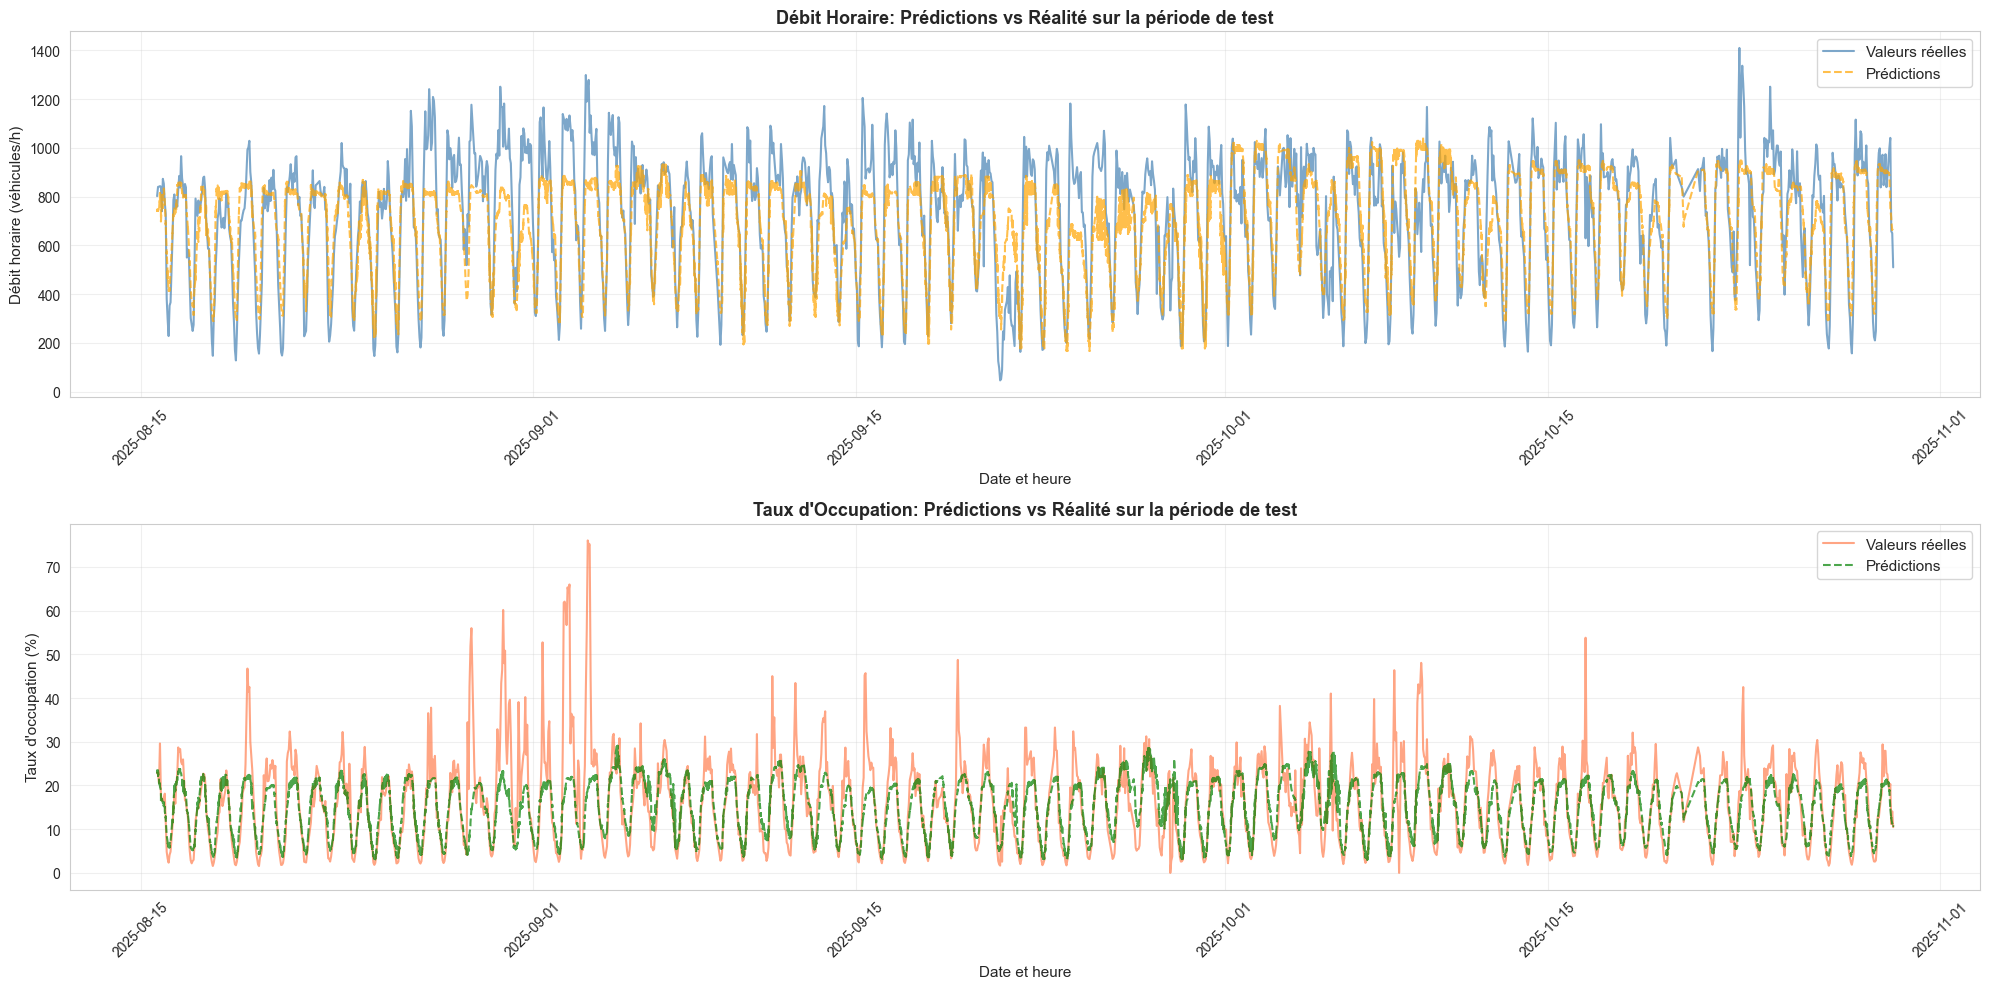


📊 Zoom sur la première semaine de test:


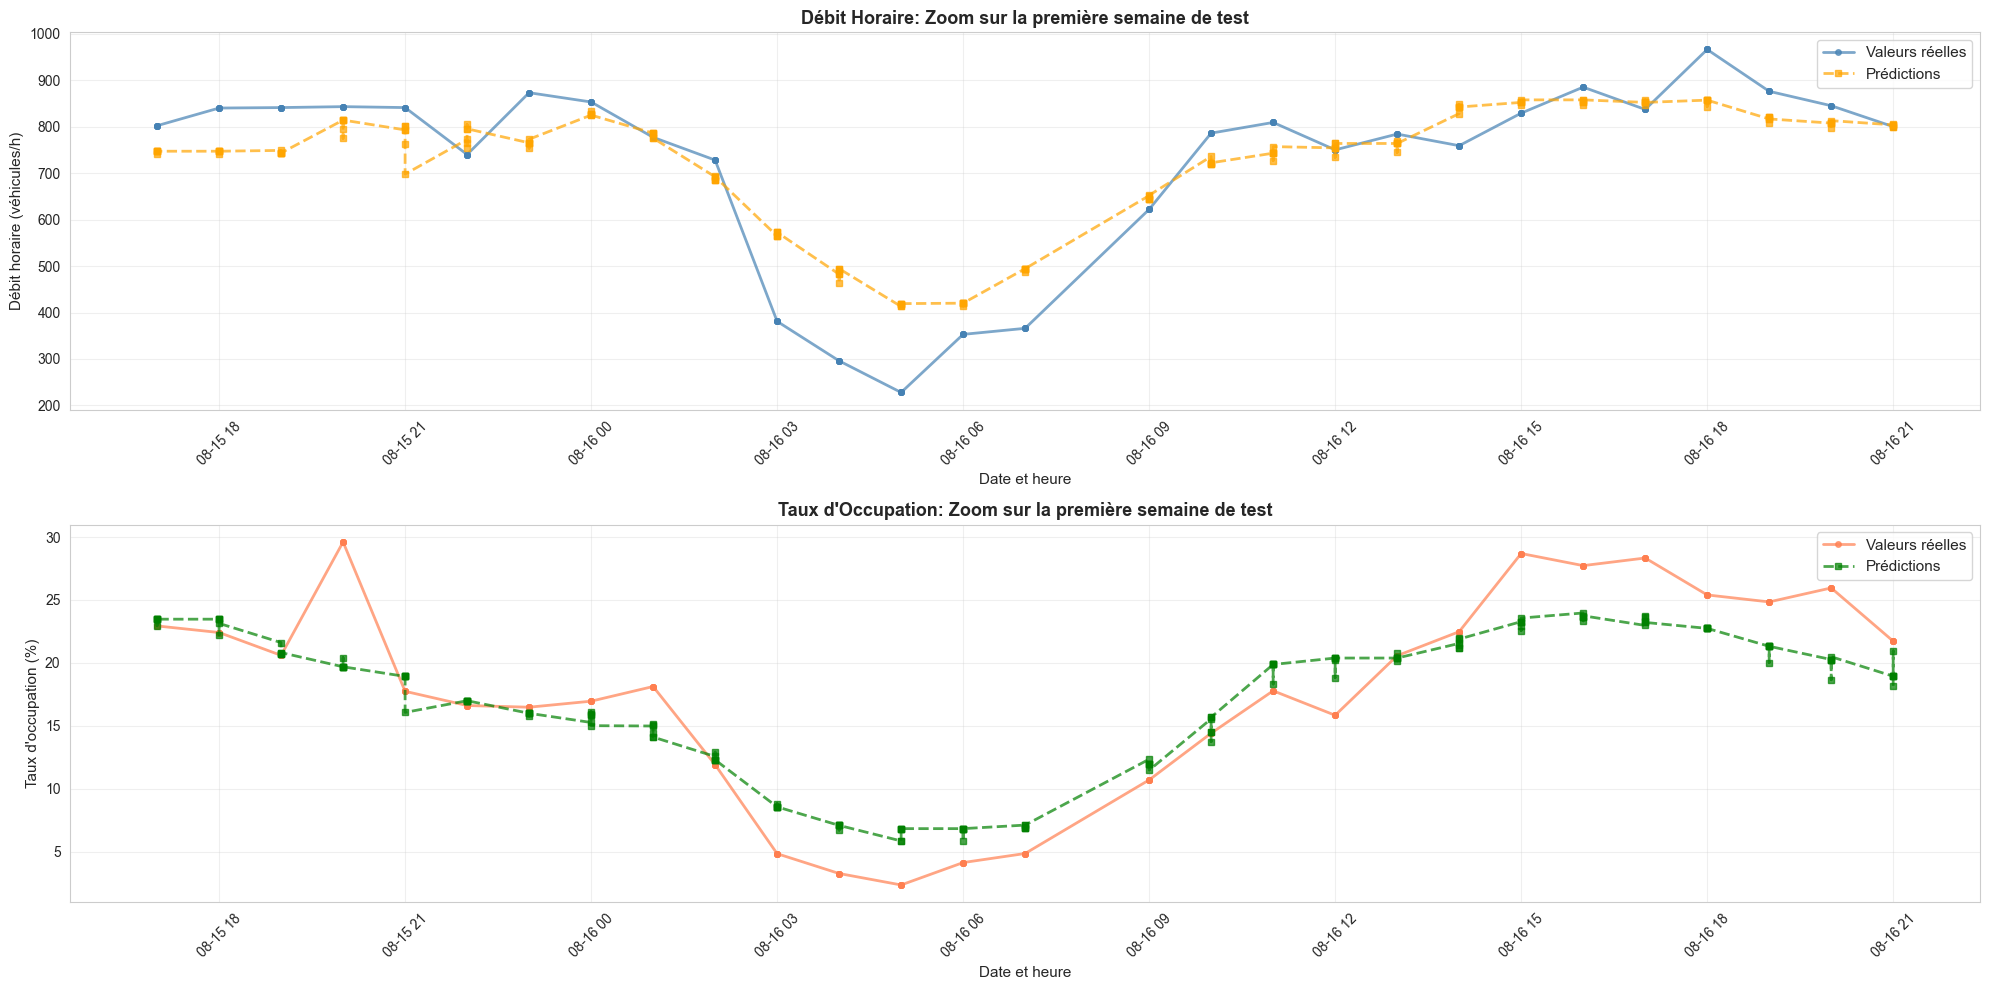


📊 Erreur moyenne par heure de la journée:


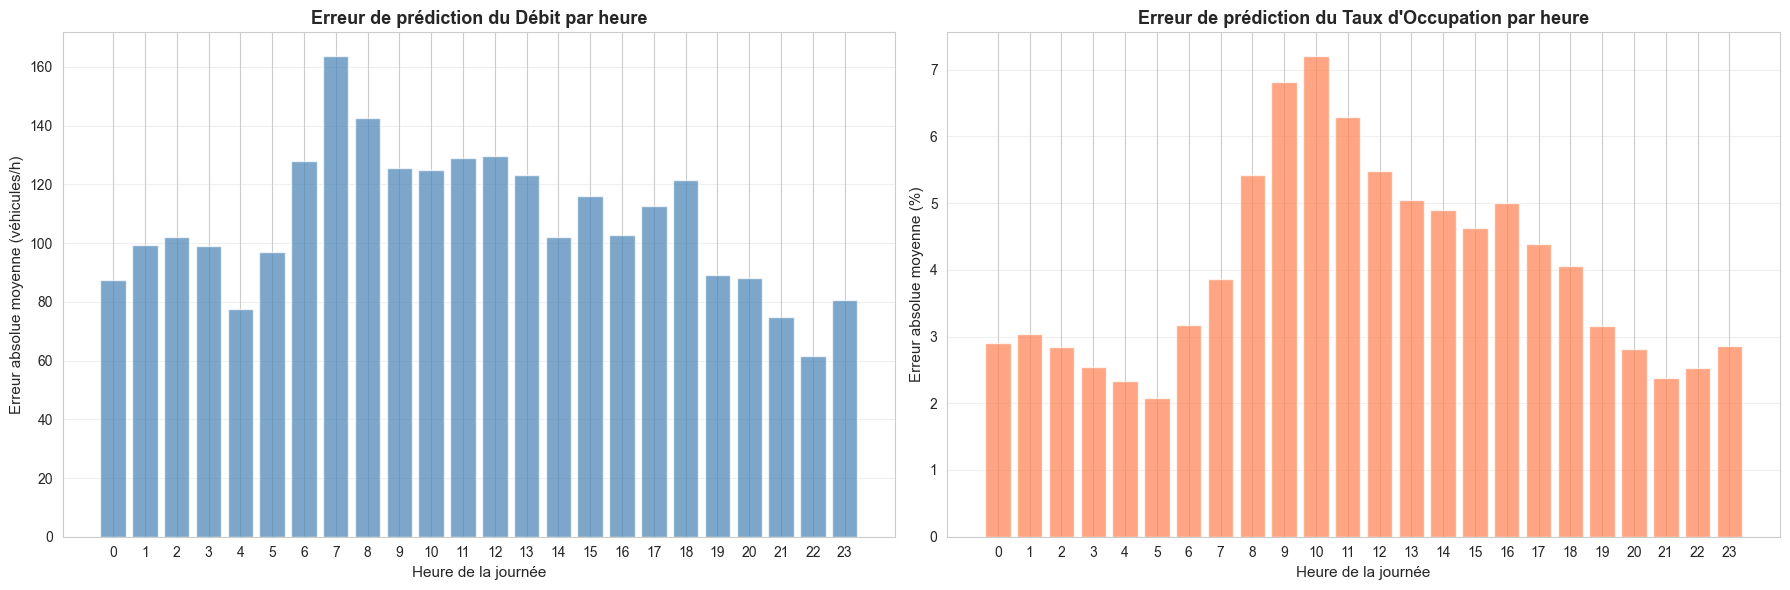


💡 Heures avec les plus grandes erreurs:

Débit horaire:
  • 7h: 163.62 véhicules/h
  • 8h: 142.54 véhicules/h
  • 12h: 129.69 véhicules/h
  • 11h: 128.90 véhicules/h
  • 6h: 127.91 véhicules/h

Taux d'occupation:
  • 10h: 7.20%
  • 9h: 6.81%
  • 11h: 6.30%
  • 12h: 5.48%
  • 8h: 5.42%



In [41]:
# ============================================================================
# VISUALISATION: PRÉDICTIONS VS VALEURS RÉELLES SUR LA PÉRIODE TEST
# ============================================================================
print("\n" + "="*80)
print("PRÉDICTIONS VS VALEURS RÉELLES - SÉRIE TEMPORELLE")
print("="*80)

# Créer un dataframe avec les dates et les valeurs pour le test set
test_data_plot = test_data[['date_heure_comptage']].copy()
test_data_plot['debit_reel'] = y_test_debit.values
test_data_plot['debit_predit'] = y_test_pred_debit
test_data_plot['taux_reel'] = y_test_taux.values
test_data_plot['taux_predit'] = y_test_pred_taux

# Trier par date
test_data_plot = test_data_plot.sort_values('date_heure_comptage')

print(f"\n✓ Période de test: {test_data_plot['date_heure_comptage'].min()} à {test_data_plot['date_heure_comptage'].max()}")
print(f"✓ Nombre de points: {len(test_data_plot)}")

# Visualisation temporelle complète
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Débit Horaire
axes[0].plot(test_data_plot['date_heure_comptage'], test_data_plot['debit_reel'], 
            label='Valeurs réelles', color='steelblue', linewidth=1.5, alpha=0.7)
axes[0].plot(test_data_plot['date_heure_comptage'], test_data_plot['debit_predit'], 
            label='Prédictions', color='orange', linewidth=1.5, alpha=0.7, linestyle='--')
axes[0].set_xlabel('Date et heure', fontsize=11)
axes[0].set_ylabel('Débit horaire (véhicules/h)', fontsize=11)
axes[0].set_title('Débit Horaire: Prédictions vs Réalité sur la période de test', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Taux d'Occupation
axes[1].plot(test_data_plot['date_heure_comptage'], test_data_plot['taux_reel'], 
            label='Valeurs réelles', color='coral', linewidth=1.5, alpha=0.7)
axes[1].plot(test_data_plot['date_heure_comptage'], test_data_plot['taux_predit'], 
            label='Prédictions', color='green', linewidth=1.5, alpha=0.7, linestyle='--')
axes[1].set_xlabel('Date et heure', fontsize=11)
axes[1].set_ylabel('Taux d\'occupation (%)', fontsize=11)
axes[1].set_title('Taux d\'Occupation: Prédictions vs Réalité sur la période de test', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Zoom sur une semaine pour mieux voir les détails
print("\n📊 Zoom sur la première semaine de test:")

# Prendre les 7 premiers jours
premiere_semaine = test_data_plot.head(7 * 24)  # 7 jours * 24 heures

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Débit Horaire - Zoom
axes[0].plot(premiere_semaine['date_heure_comptage'], premiere_semaine['debit_reel'], 
            label='Valeurs réelles', color='steelblue', linewidth=2, marker='o', markersize=4, alpha=0.7)
axes[0].plot(premiere_semaine['date_heure_comptage'], premiere_semaine['debit_predit'], 
            label='Prédictions', color='orange', linewidth=2, marker='s', markersize=4, alpha=0.7, linestyle='--')
axes[0].set_xlabel('Date et heure', fontsize=11)
axes[0].set_ylabel('Débit horaire (véhicules/h)', fontsize=11)
axes[0].set_title('Débit Horaire: Zoom sur la première semaine de test', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Taux d'Occupation - Zoom
axes[1].plot(premiere_semaine['date_heure_comptage'], premiere_semaine['taux_reel'], 
            label='Valeurs réelles', color='coral', linewidth=2, marker='o', markersize=4, alpha=0.7)
axes[1].plot(premiere_semaine['date_heure_comptage'], premiere_semaine['taux_predit'], 
            label='Prédictions', color='green', linewidth=2, marker='s', markersize=4, alpha=0.7, linestyle='--')
axes[1].set_xlabel('Date et heure', fontsize=11)
axes[1].set_ylabel('Taux d\'occupation (%)', fontsize=11)
axes[1].set_title('Taux d\'Occupation: Zoom sur la première semaine de test', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculer les erreurs par heure de la journée
print("\n📊 Erreur moyenne par heure de la journée:")

test_data_plot['heure'] = test_data_plot['date_heure_comptage'].dt.hour
test_data_plot['erreur_debit'] = abs(test_data_plot['debit_reel'] - test_data_plot['debit_predit'])
test_data_plot['erreur_taux'] = abs(test_data_plot['taux_reel'] - test_data_plot['taux_predit'])

erreur_by_hour = test_data_plot.groupby('heure').agg({
    'erreur_debit': 'mean',
    'erreur_taux': 'mean'
})

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Erreur débit par heure
axes[0].bar(erreur_by_hour.index, erreur_by_hour['erreur_debit'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Heure de la journée', fontsize=11)
axes[0].set_ylabel('Erreur absolue moyenne (véhicules/h)', fontsize=11)
axes[0].set_title('Erreur de prédiction du Débit par heure', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(0, 24))
axes[0].grid(True, alpha=0.3, axis='y')

# Erreur taux par heure
axes[1].bar(erreur_by_hour.index, erreur_by_hour['erreur_taux'], color='coral', alpha=0.7)
axes[1].set_xlabel('Heure de la journée', fontsize=11)
axes[1].set_ylabel('Erreur absolue moyenne (%)', fontsize=11)
axes[1].set_title('Erreur de prédiction du Taux d\'Occupation par heure', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(0, 24))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Heures avec les plus grandes erreurs:")
print(f"\nDébit horaire:")
worst_hours_debit = erreur_by_hour['erreur_debit'].nlargest(5)
for heure, erreur in worst_hours_debit.items():
    print(f"  • {heure}h: {erreur:.2f} véhicules/h")

print(f"\nTaux d'occupation:")
worst_hours_taux = erreur_by_hour['erreur_taux'].nlargest(5)
for heure, erreur in worst_hours_taux.items():
    print(f"  • {heure}h: {erreur:.2f}%")

print("\n" + "="*80)


VISUALISATION: AMÉLIORATION SUR LES PICS


NameError: name 'mae_pics_base' is not defined

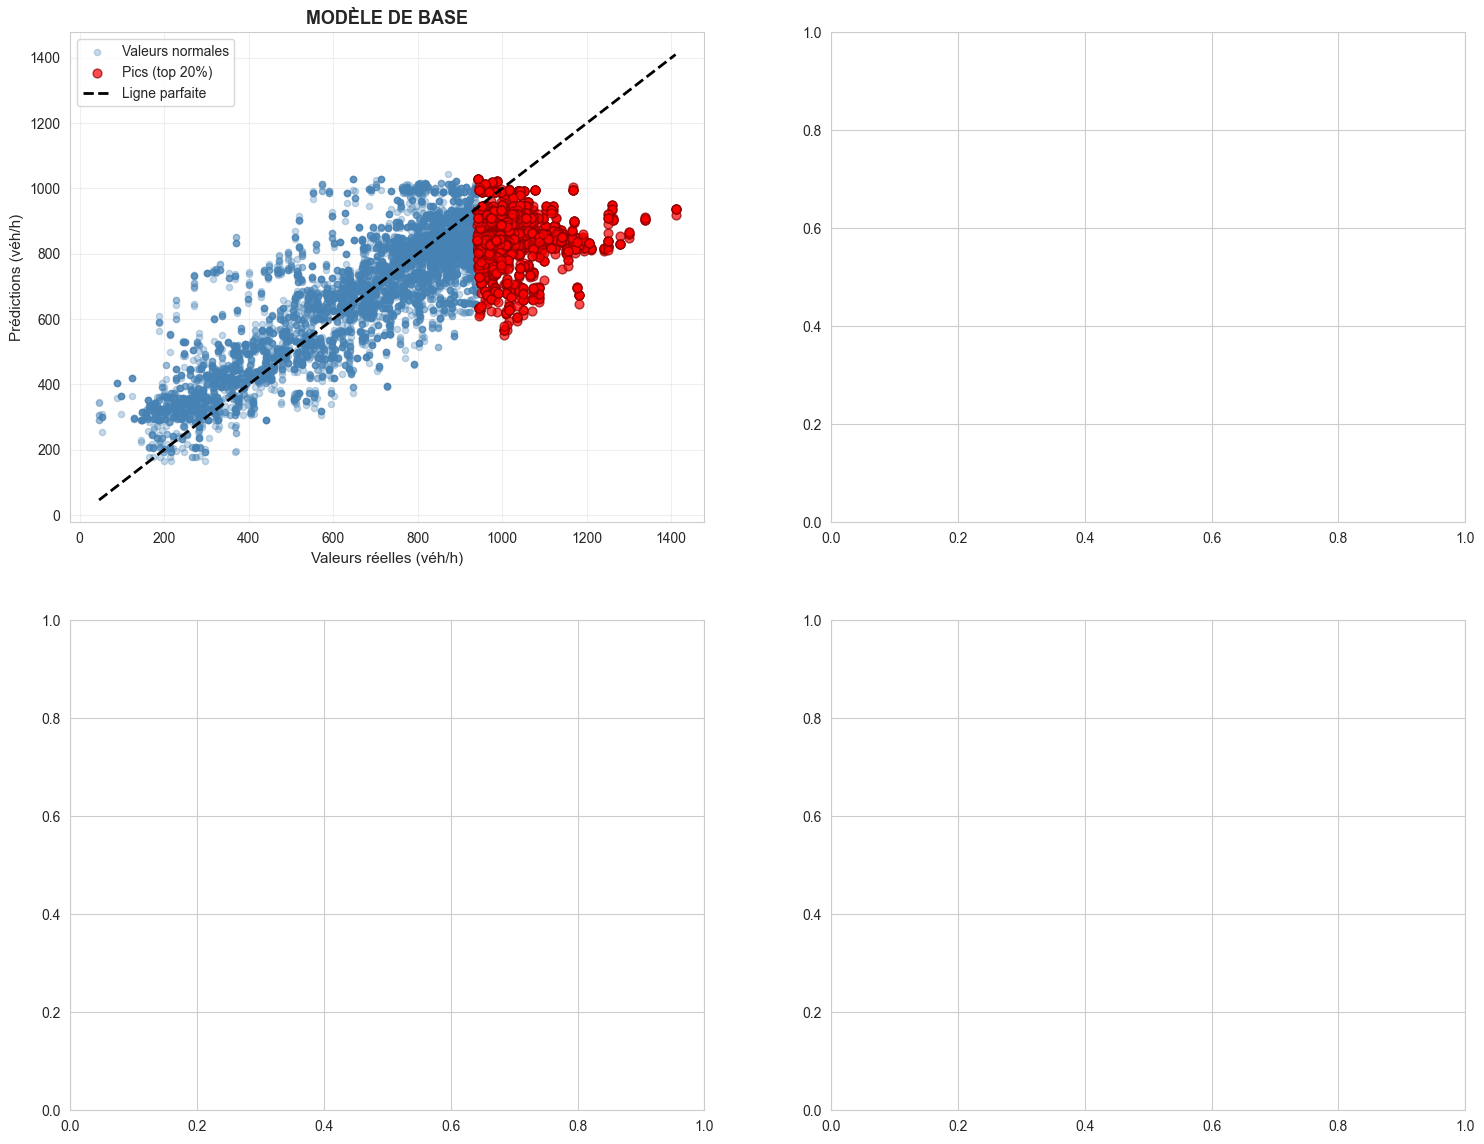

In [42]:
# ============================================================================
# VISUALISATION: Comparaison Modèle de Base vs Modèle Amélioré sur les Pics
# ============================================================================
print("\n" + "="*80)
print("VISUALISATION: AMÉLIORATION SUR LES PICS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Identifier les pics
seuil_pic = y_test_debit_adv.quantile(0.80)
pics_mask = y_test_debit_adv > seuil_pic
normales_mask = ~pics_mask

# 1. SCATTER PLOT - Modèle de base
axes[0, 0].scatter(y_test_debit[normales_mask], y_test_pred_debit[normales_mask], 
                  alpha=0.3, s=20, color='steelblue', label='Valeurs normales')
axes[0, 0].scatter(y_test_debit[pics_mask], y_test_pred_debit[pics_mask], 
                  alpha=0.7, s=40, color='red', label='Pics (top 20%)', edgecolors='darkred', linewidths=1)
axes[0, 0].plot([y_test_debit.min(), y_test_debit.max()], 
               [y_test_debit.min(), y_test_debit.max()], 
               'k--', lw=2, label='Ligne parfaite')
axes[0, 0].set_xlabel('Valeurs réelles (véh/h)', fontsize=11)
axes[0, 0].set_ylabel('Prédictions (véh/h)', fontsize=11)
axes[0, 0].set_title('MODÈLE DE BASE', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].text(0.05, 0.95, f'MAE pics: {mae_pics_base:.1f}', 
               transform=axes[0, 0].transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 2. SCATTER PLOT - Modèle amélioré
axes[0, 1].scatter(y_test_debit_adv[normales_mask], y_test_pred_debit_improved[normales_mask], 
                  alpha=0.3, s=20, color='steelblue', label='Valeurs normales')
axes[0, 1].scatter(y_test_debit_adv[pics_mask], y_test_pred_debit_improved[pics_mask], 
                  alpha=0.7, s=40, color='green', label='Pics (top 20%)', edgecolors='darkgreen', linewidths=1)
axes[0, 1].plot([y_test_debit_adv.min(), y_test_debit_adv.max()], 
               [y_test_debit_adv.min(), y_test_debit_adv.max()], 
               'k--', lw=2, label='Ligne parfaite')
axes[0, 1].set_xlabel('Valeurs réelles (véh/h)', fontsize=11)
axes[0, 1].set_ylabel('Prédictions (véh/h)', fontsize=11)
axes[0, 1].set_title('MODÈLE AMÉLIORÉ', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].text(0.05, 0.95, f'MAE pics: {mae_pics_improved:.1f} ({amelioration_pics:+.1f}%)', 
               transform=axes[0, 1].transAxes, fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# 3. SÉRIE TEMPORELLE - Zoom sur les pics
# Prendre seulement les heures où il y a des pics
indices_pics = np.where(pics_mask)[0][:100]  # Premiers 100 pics

axes[1, 0].plot(indices_pics, y_test_debit.values[indices_pics], 
               'o-', label='Valeurs réelles', color='black', linewidth=2, markersize=6)
axes[1, 0].plot(indices_pics, y_test_pred_debit[indices_pics], 
               's--', label='Modèle de base', color='red', linewidth=2, markersize=5, alpha=0.7)
axes[1, 0].plot(indices_pics, y_test_pred_debit_improved[indices_pics], 
               '^--', label='Modèle amélioré', color='green', linewidth=2, markersize=5, alpha=0.7)
axes[1, 0].set_xlabel('Index des observations', fontsize=11)
axes[1, 0].set_ylabel('Débit horaire (véh/h)', fontsize=11)
axes[1, 0].set_title('Prédiction des Pics (100 premiers)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. DISTRIBUTION DES ERREURS sur les pics
erreurs_base_pics = abs(y_test_debit[pics_mask] - y_test_pred_debit[pics_mask])
erreurs_improved_pics = abs(y_test_debit_adv[pics_mask] - y_test_pred_debit_improved[pics_mask])

axes[1, 1].hist(erreurs_base_pics, bins=30, alpha=0.5, color='red', label='Modèle de base', edgecolor='black')
axes[1, 1].hist(erreurs_improved_pics, bins=30, alpha=0.5, color='green', label='Modèle amélioré', edgecolor='black')
axes[1, 1].axvline(erreurs_base_pics.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Moyenne base: {erreurs_base_pics.mean():.1f}')
axes[1, 1].axvline(erreurs_improved_pics.mean(), color='green', linestyle='--', linewidth=2,
                   label=f'Moyenne amélioré: {erreurs_improved_pics.mean():.1f}')
axes[1, 1].set_xlabel('Erreur absolue (véh/h)', fontsize=11)
axes[1, 1].set_ylabel('Fréquence', fontsize=11)
axes[1, 1].set_title('Distribution des Erreurs sur les Pics', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tableau récapitulatif final
print("\n" + "="*80)
print("📊 TABLEAU RÉCAPITULATIF FINAL")
print("="*80)

comparison = pd.DataFrame({
    'Métrique': ['MAE Test (global)', 'MAE Test (pics)', 'RMSE Test', 'R² Test'],
    'Modèle de Base': [
        f"{mean_absolute_error(y_test_debit, y_test_pred_debit):.2f}",
        f"{mae_pics_base:.2f}",
        f"{np.sqrt(mean_squared_error(y_test_debit, y_test_pred_debit)):.2f}",
        f"{r2_score(y_test_debit, y_test_pred_debit):.4f}"
    ],
    'Modèle Amélioré': [
        f"{mae_test_improved:.2f}",
        f"{mae_pics_improved:.2f}",
        f"{rmse_test_improved:.2f}",
        f"{r2_test_improved:.4f}"
    ],
    'Amélioration': [
        f"{amelioration_mae:+.1f}%",
        f"{amelioration_pics:+.1f}%",
        f"{((np.sqrt(mean_squared_error(y_test_debit, y_test_pred_debit)) - rmse_test_improved) / np.sqrt(mean_squared_error(y_test_debit, y_test_pred_debit)) * 100):+.1f}%",
        f"{(r2_test_improved - r2_score(y_test_debit, y_test_pred_debit)):+.4f}"
    ]
})

print("\n", comparison.to_string(index=False))

print("\n💡 CONCLUSION:")
if amelioration_pics > 5:
    print("  ✅ Le modèle amélioré performe significativement mieux sur les pics!")
    print("  → Les features cycliques et l'indicateur heure_de_pointe ont aidé")
elif amelioration_pics > 0:
    print("  ⚠️  Le modèle amélioré performe légèrement mieux sur les pics")
    print("  → Essayer d'ajouter plus de features (lags, météo, etc.)")
else:
    print("  ❌ Le modèle amélioré ne performe pas mieux sur les pics")
    print("  → Essayer d'autres approches (Quantile Regression, LightGBM)")

print("\n" + "="*80)


ANALYSE DES ERREURS SUR LES PICS DE TRAFIC

📊 Seuils de pics (top 20%):
  • Débit horaire: > 940 véhicules/h
  • Taux occupation: > 23.92%

📈 ERREURS DE PRÉDICTION:

Débit horaire:
  • MAE sur valeurs normales: 88.54 véh/h
  • MAE sur pics (top 20%): 181.35 véh/h
  • Ratio: 2.05x plus d'erreur sur les pics

Taux d'occupation:
  • MAE sur valeurs normales: 2.52%
  • MAE sur pics (top 20%): 9.73%
  • Ratio: 3.87x plus d'erreur sur les pics


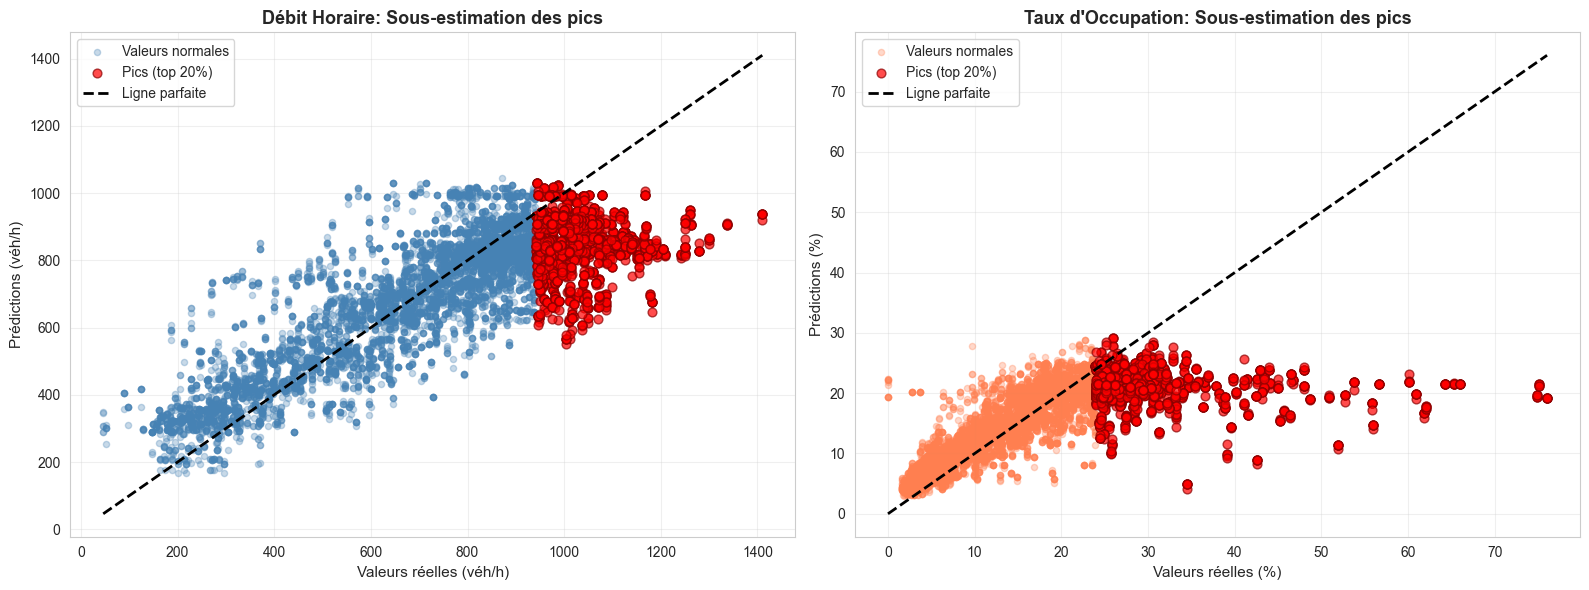


QUAND SE PRODUISENT LES PICS MAL PRÉDITS ?

🕐 Distribution des pics de débit par heure:
  • 0h: 24 pics (1.2%)
  • 2h: 12 pics (0.6%)
  • 6h: 48 pics (2.3%)
  • 7h: 222 pics (10.7%)
  • 8h: 198 pics (9.6%)
  • 9h: 144 pics (7.0%)
  • 10h: 108 pics (5.2%)
  • 11h: 150 pics (7.2%)
  • 12h: 114 pics (5.5%)
  • 13h: 144 pics (7.0%)
  • 14h: 84 pics (4.1%)
  • 15h: 114 pics (5.5%)
  • 16h: 108 pics (5.2%)
  • 17h: 198 pics (9.6%)
  • 18h: 210 pics (10.1%)
  • 19h: 72 pics (3.5%)
  • 20h: 48 pics (2.3%)
  • 21h: 36 pics (1.7%)
  • 22h: 24 pics (1.2%)
  • 23h: 12 pics (0.6%)

💡 SOLUTIONS POUR AMÉLIORER LA PRÉDICTION DES PICS

1️⃣ FEATURE ENGINEERING:
   • Ajouter 'heure_de_pointe' (booléen): 1 si heure entre 7-9h ou 17-19h
   • Ajouter features cycliques: sin(heure), cos(heure)
   • Ajouter lags: débit à h-1, h-2, h-3
   • Ajouter moyenne roulante sur 3h
   • Interaction: heure * jour_semaine

2️⃣ AJUSTEMENT DU MODÈLE:
   • Augmenter max_depth (actuellement 6 → essayer 8 ou 10)
   • Réduire 

In [43]:
# ============================================================================
# ANALYSE DES PICS - Pourquoi XGBoost sous-estime les valeurs élevées
# ============================================================================
print("\n" + "="*80)
print("ANALYSE DES ERREURS SUR LES PICS DE TRAFIC")
print("="*80)

# Identifier les pics (valeurs dans le top 20%)
seuil_pic_debit = y_test_debit.quantile(0.80)
seuil_pic_taux = y_test_taux.quantile(0.80)

print(f"\n📊 Seuils de pics (top 20%):")
print(f"  • Débit horaire: > {seuil_pic_debit:.0f} véhicules/h")
print(f"  • Taux occupation: > {seuil_pic_taux:.2f}%")

# Séparer les pics des valeurs normales
pics_debit_mask = y_test_debit > seuil_pic_debit
normales_debit_mask = ~pics_debit_mask

pics_taux_mask = y_test_taux > seuil_pic_taux
normales_taux_mask = ~pics_taux_mask

# Calculer les erreurs pour les pics vs normales
erreur_pics_debit = mean_absolute_error(y_test_debit[pics_debit_mask], y_test_pred_debit[pics_debit_mask])
erreur_normales_debit = mean_absolute_error(y_test_debit[normales_debit_mask], y_test_pred_debit[normales_debit_mask])

erreur_pics_taux = mean_absolute_error(y_test_taux[pics_taux_mask], y_test_pred_taux[pics_taux_mask])
erreur_normales_taux = mean_absolute_error(y_test_taux[normales_taux_mask], y_test_pred_taux[normales_taux_mask])

print(f"\n📈 ERREURS DE PRÉDICTION:")
print(f"\nDébit horaire:")
print(f"  • MAE sur valeurs normales: {erreur_normales_debit:.2f} véh/h")
print(f"  • MAE sur pics (top 20%): {erreur_pics_debit:.2f} véh/h")
print(f"  • Ratio: {erreur_pics_debit/erreur_normales_debit:.2f}x plus d'erreur sur les pics")

print(f"\nTaux d'occupation:")
print(f"  • MAE sur valeurs normales: {erreur_normales_taux:.2f}%")
print(f"  • MAE sur pics (top 20%): {erreur_pics_taux:.2f}%")
print(f"  • Ratio: {erreur_pics_taux/erreur_normales_taux:.2f}x plus d'erreur sur les pics")

# Visualiser les pics sous-estimés
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Débit - Scatter pour les pics uniquement
axes[0].scatter(y_test_debit[normales_debit_mask], y_test_pred_debit[normales_debit_mask], 
               alpha=0.3, s=20, color='steelblue', label='Valeurs normales')
axes[0].scatter(y_test_debit[pics_debit_mask], y_test_pred_debit[pics_debit_mask], 
               alpha=0.7, s=40, color='red', label='Pics (top 20%)', edgecolors='darkred', linewidths=1)
axes[0].plot([y_test_debit.min(), y_test_debit.max()], 
            [y_test_debit.min(), y_test_debit.max()], 
            'k--', lw=2, label='Ligne parfaite')
axes[0].set_xlabel('Valeurs réelles (véh/h)', fontsize=11)
axes[0].set_ylabel('Prédictions (véh/h)', fontsize=11)
axes[0].set_title('Débit Horaire: Sous-estimation des pics', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Taux - Scatter pour les pics uniquement
axes[1].scatter(y_test_taux[normales_taux_mask], y_test_pred_taux[normales_taux_mask], 
               alpha=0.3, s=20, color='coral', label='Valeurs normales')
axes[1].scatter(y_test_taux[pics_taux_mask], y_test_pred_taux[pics_taux_mask], 
               alpha=0.7, s=40, color='red', label='Pics (top 20%)', edgecolors='darkred', linewidths=1)
axes[1].plot([y_test_taux.min(), y_test_taux.max()], 
            [y_test_taux.min(), y_test_taux.max()], 
            'k--', lw=2, label='Ligne parfaite')
axes[1].set_xlabel('Valeurs réelles (%)', fontsize=11)
axes[1].set_ylabel('Prédictions (%)', fontsize=11)
axes[1].set_title('Taux d\'Occupation: Sous-estimation des pics', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analyser QUAND se produisent les pics mal prédits
print("\n" + "="*80)
print("QUAND SE PRODUISENT LES PICS MAL PRÉDITS ?")
print("="*80)

# Ajouter les features temporelles aux indices de pics
test_data_avec_pics = test_data.reset_index(drop=True)
pics_debit_indices = np.where(pics_debit_mask)[0]

print(f"\n🕐 Distribution des pics de débit par heure:")
heures_pics = test_data_avec_pics.iloc[pics_debit_indices]['heure'].value_counts().sort_index()
for heure, count in heures_pics.items():
    print(f"  • {heure}h: {count} pics ({count/len(pics_debit_indices)*100:.1f}%)")

# Solutions proposées
print("\n" + "="*80)
print("💡 SOLUTIONS POUR AMÉLIORER LA PRÉDICTION DES PICS")
print("="*80)

print("\n1️⃣ FEATURE ENGINEERING:")
print("   • Ajouter 'heure_de_pointe' (booléen): 1 si heure entre 7-9h ou 17-19h")
print("   • Ajouter features cycliques: sin(heure), cos(heure)")
print("   • Ajouter lags: débit à h-1, h-2, h-3")
print("   • Ajouter moyenne roulante sur 3h")
print("   • Interaction: heure * jour_semaine")

print("\n2️⃣ AJUSTEMENT DU MODÈLE:")
print("   • Augmenter max_depth (actuellement 6 → essayer 8 ou 10)")
print("   • Réduire learning_rate (0.1 → 0.05) et augmenter n_estimators")
print("   • Ajouter plus de données d'entraînement avec des pics")

print("\n3️⃣ APPROCHES ALTERNATIVES:")
print("   • Entraîner un modèle spécifique pour les heures de pointe")
print("   • Utiliser Quantile Regression pour prédire les extrêmes")
print("   • Essayer LightGBM ou CatBoost (souvent meilleurs sur les pics)")

print("\n4️⃣ POST-TRAITEMENT:")
print("   • Appliquer un facteur de correction pendant les heures de pointe")
print("   • Utiliser un modèle de détection d'anomalies pour ajuster les pics")

print("\n" + "="*80)
print("Voulez-vous que je crée une cellule avec ces améliorations ?")
print("="*80)

In [ ]:
# Résumé des performances et sauvegarde
print("\n" + "="*80)
print("RÉSUMÉ DES PERFORMANCES")
print("="*80)

# Tableau récapitulatif
results_summary = pd.DataFrame({
    'Modèle': ['Débit Horaire', 'Taux d\'Occupation'],
    'MAE Train': [
        mean_absolute_error(y_train_debit, y_train_pred_debit),
        mean_absolute_error(y_train_taux, y_train_pred_taux)
    ],
    'MAE Test': [
        mean_absolute_error(y_test_debit, y_test_pred_debit),
        mean_absolute_error(y_test_taux, y_test_pred_taux)
    ],
    'RMSE Train': [
        np.sqrt(mean_squared_error(y_train_debit, y_train_pred_debit)),
        np.sqrt(mean_squared_error(y_train_taux, y_train_pred_taux))
    ],
    'RMSE Test': [
        np.sqrt(mean_squared_error(y_test_debit, y_test_pred_debit)),
        np.sqrt(mean_squared_error(y_test_taux, y_test_pred_taux))
    ],
    'R² Train': [
        r2_score(y_train_debit, y_train_pred_debit),
        r2_score(y_train_taux, y_train_pred_taux)
    ],
    'R² Test': [
        r2_score(y_test_debit, y_test_pred_debit),
        r2_score(y_test_taux, y_test_pred_taux)
    ]
})

print("\n", results_summary.to_string(index=False))

# Sauvegarde des modèles
import pickle

print("\n" + "="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

# Créer le dossier models s'il n'existe pas
import os
os.makedirs('models', exist_ok=True)

# Sauvegarder les modèles
with open('models/xgb_debit_horaire.pkl', 'wb') as f:
    pickle.dump(model_debit, f)
print("✓ Modèle débit_horaire sauvegardé: models/xgb_debit_horaire.pkl")

with open('models/xgb_taux_occupation.pkl', 'wb') as f:
    pickle.dump(model_taux, f)
print("✓ Modèle taux_occupation sauvegardé: models/xgb_taux_occupation.pkl")

# Sauvegarder la liste des features
with open('models/features_list.pkl', 'wb') as f:
    pickle.dump(features_finales, f)
print("✓ Liste des features sauvegardée: models/features_list.pkl")

print("\n📊 INFORMATIONS POUR LA PRÉDICTION:")
print(f"  • Features utilisées: {features_finales}")
print(f"  • Nombre de features: {len(features_finales)}")
print(f"  • Shape des données d'entraînement: {X_train.shape}")
print(f"  • Shape des données de test: {X_test.shape}")
print(f"  • Note: etat_trafic a été exclu pour éviter le data leakage")


RÉSUMÉ DES PERFORMANCES

            Modèle  MAE Train   MAE Test  RMSE Train  RMSE Test  R² Train  R² Test
    Débit Horaire 111.409631 107.063121  159.434732 141.364857  0.725346 0.689441
Taux d'Occupation   3.471208   3.958278    5.594398   6.845066  0.654594 0.544100

SAUVEGARDE DES MODÈLES
✓ Modèle débit_horaire sauvegardé: models/xgb_debit_horaire.pkl
✓ Modèle taux_occupation sauvegardé: models/xgb_taux_occupation.pkl
✓ Liste des features sauvegardée: models/features_list.pkl

📊 INFORMATIONS POUR LA PRÉDICTION:
  • Features utilisées: ['heure', 'jour_semaine', 'mois', 'est_weekend', 'est_vacances', 'est_jour_ferie', 'temperature']
  • Nombre de features: 7
  • Shape des données d'entraînement: (41490, 7)
  • Shape des données de test: (10373, 7)
  • Note: etat_trafic a été exclu pour éviter le data leakage


VÉRIFICATION DES CONDITIONS POUR ARIMA

📋 CONDITIONS REQUISES POUR ARIMA:
1️⃣  Série temporelle univariée (une seule variable)
2️⃣  Stationnarité (moyenne et variance constantes)
3️⃣  Autocorrélation (valeurs passées corrélées avec futures)
4️⃣  Données continues sans trop de gaps
5️⃣  Suffisamment de données (50+ observations)
6️⃣  Saisonnalité régulière (ou utiliser SARIMA)

VÉRIFICATION 1: DONNÉES DISPONIBLES

✓ Nombre d'observations: 52217
✓ Période: 2024-09-01 03:00:00 à 2025-10-29 23:00:00
✓ Durée: 423 jours
✅ CONDITION REMPLIE: Suffisamment de données

VÉRIFICATION 2: CONTINUITÉ DES DONNÉES

✓ Nombre de gaps (> 1h): 222
✓ Pourcentage de continuité: 99.6%
✅ CONDITION ACCEPTABLE: Peu de gaps dans les données

VÉRIFICATION 3: STATIONNARITÉ (Test de Dickey-Fuller)

📊 Résultats du test ADF:
  • Statistique ADF: -28.7730
  • P-value: 0.0000
  • Valeur critique (5%): -2.8616

✅ CONDITION REMPLIE: Série STATIONNAIRE (p-value < 0.05)
   → Peut utiliser ARIMA directement

📊 Visualisation 

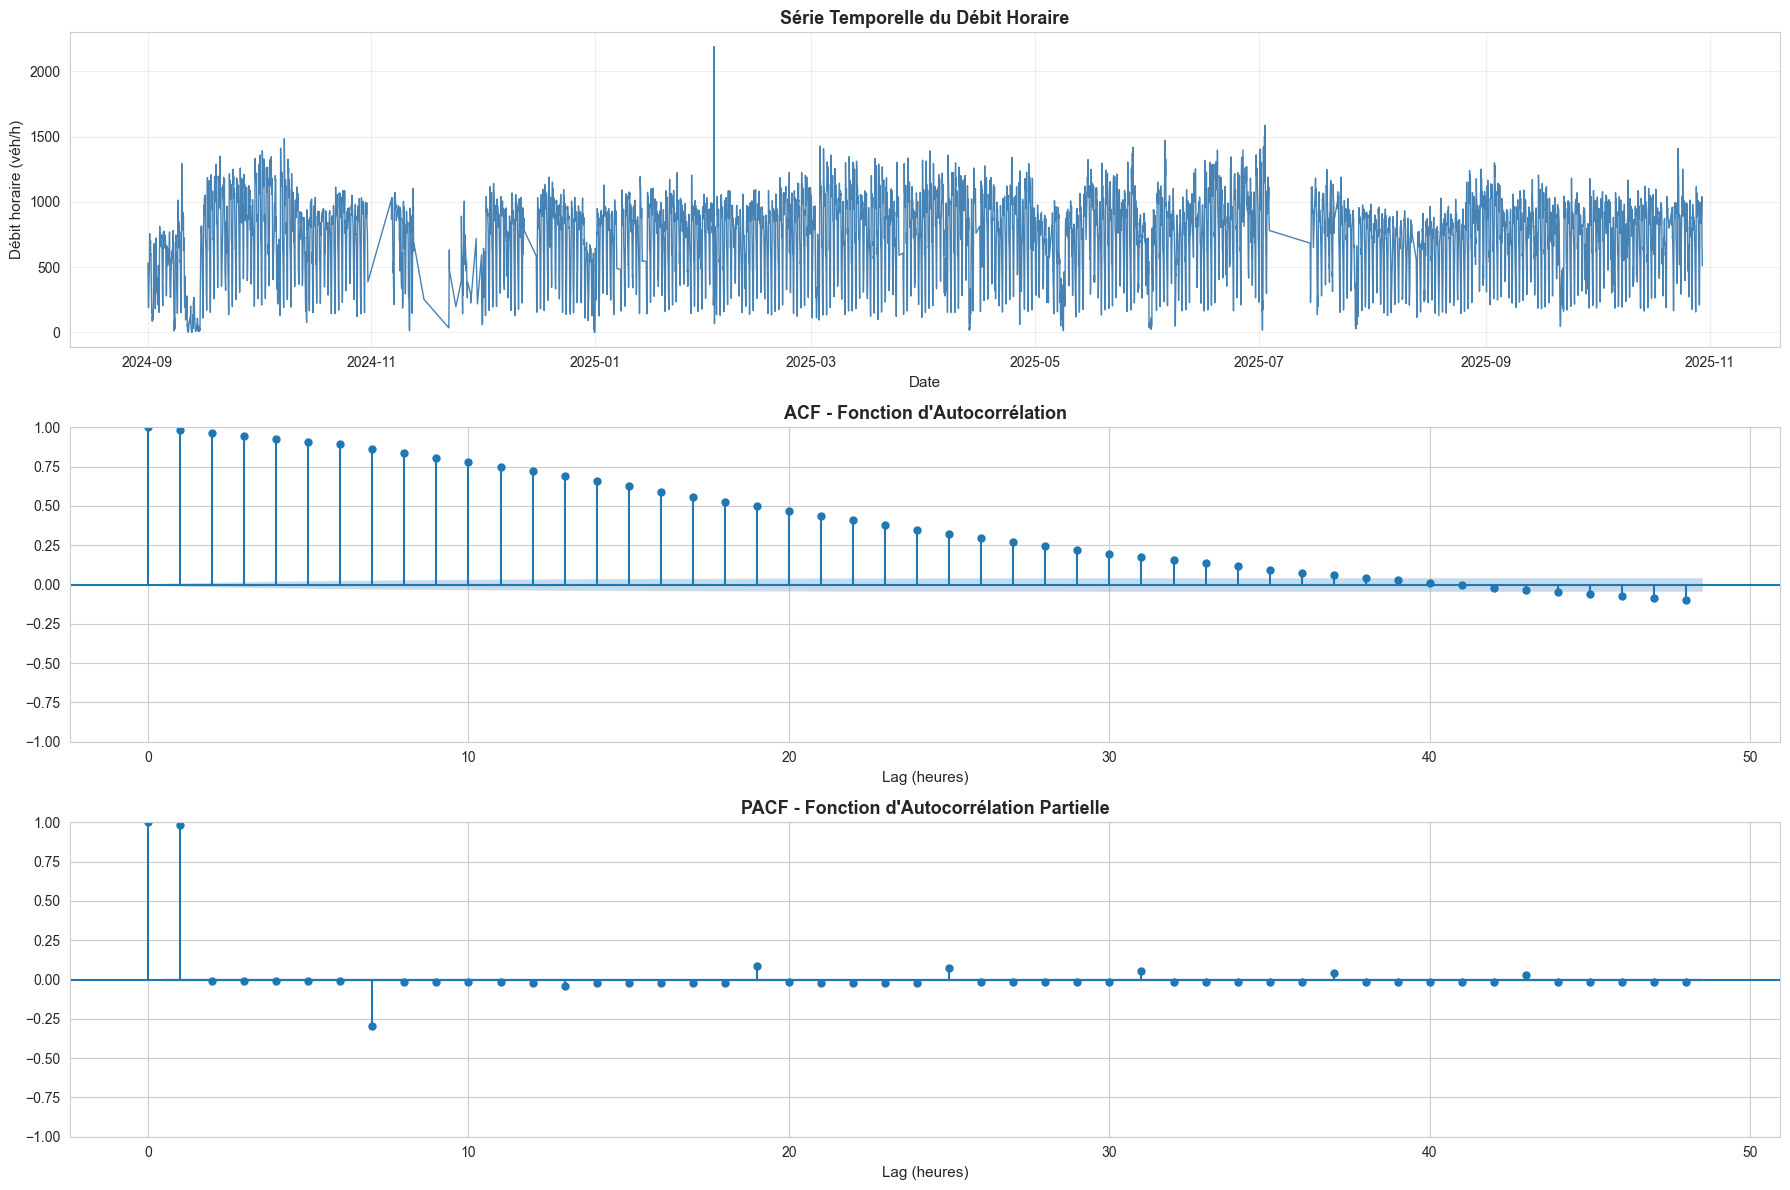


VÉRIFICATION 4: AUTOCORRÉLATION

📊 Autocorrélations significatives:
  • Lag 1h:  0.982
  • Lag 12h: 0.720
  • Lag 24h: 0.348

✅ CONDITION REMPLIE: Forte autocorrélation (|r| > 0.3)
   → Les valeurs passées prédisent bien les valeurs futures

VÉRIFICATION 5: SAISONNALITÉ


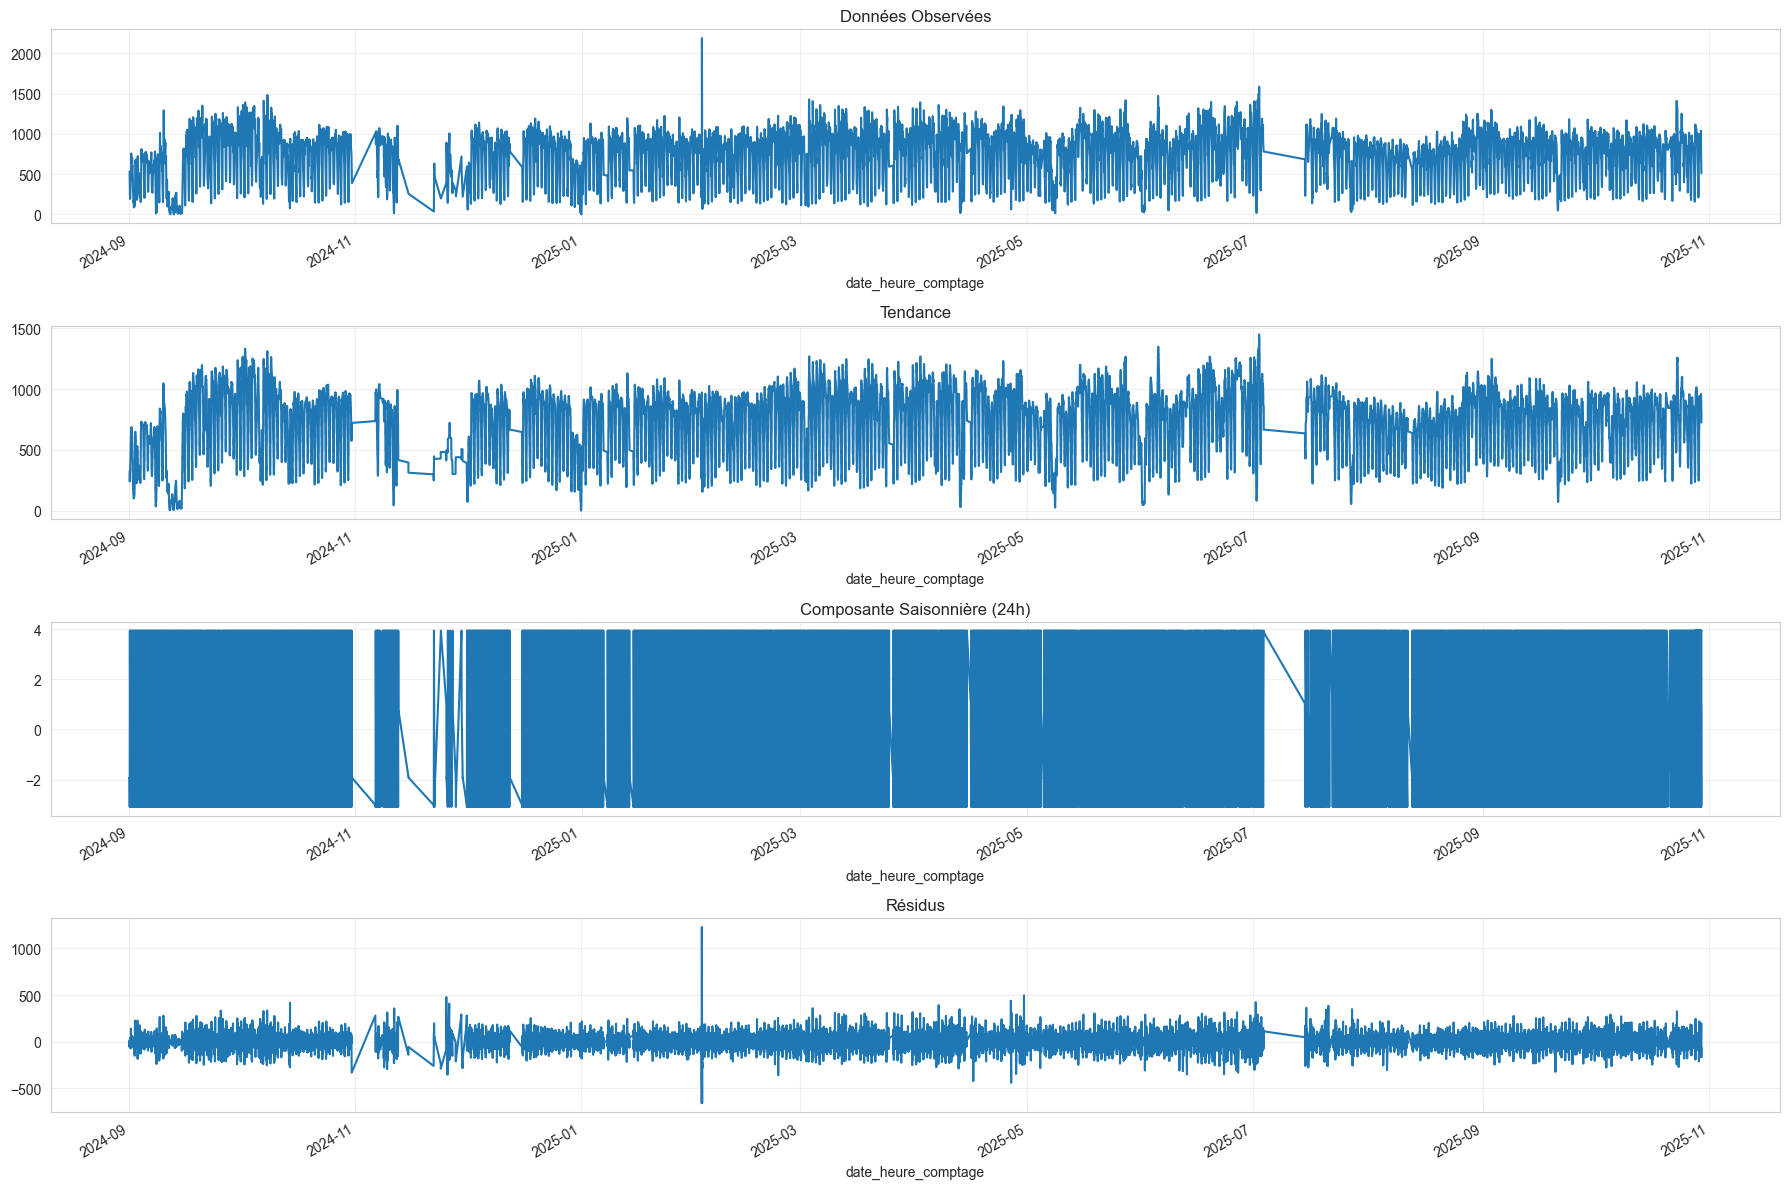


📊 Analyse de la saisonnalité:
  • Amplitude saisonnière: 7.02 véh/h
  • Ratio saisonnalité/données: 0.32%

✅ Saisonnalité modérée
   → ARIMA peut fonctionner, ou SARIMA pour plus de précision

🎯 CONCLUSION: ARIMA EST-IL ADAPTÉ ?

✅ Aucun problème majeur

💡 RECOMMANDATIONS:
  ✅ ARIMA peut être appliqué directement
  → Essayer ARIMA(p,d,q) avec p,d,q ∈ [0,1,2]
  → Ou utiliser auto_arima pour trouver les meilleurs paramètres

⚠️  ALTERNATIVE RECOMMANDÉE:
  → XGBoost (votre approche actuelle) est souvent MEILLEUR pour:
    • Données avec saisonnalités multiples (jour/semaine/mois)
    • Intégration de features exogènes (météo, vacances, jours fériés)
    • Prédiction des pics de trafic
    • Gestion automatique des non-linéarités



In [44]:
# ============================================================================
# ANALYSE: Peut-on appliquer ARIMA sur ces données ?
# ============================================================================
print("="*80)
print("VÉRIFICATION DES CONDITIONS POUR ARIMA")
print("="*80)

print("\n📋 CONDITIONS REQUISES POUR ARIMA:")
print("1️⃣  Série temporelle univariée (une seule variable)")
print("2️⃣  Stationnarité (moyenne et variance constantes)")
print("3️⃣  Autocorrélation (valeurs passées corrélées avec futures)")
print("4️⃣  Données continues sans trop de gaps")
print("5️⃣  Suffisamment de données (50+ observations)")
print("6️⃣  Saisonnalité régulière (ou utiliser SARIMA)")

# Préparer la série temporelle (débit horaire uniquement)
# Prendre seulement les données avec valeurs non-NaN
df_arima = df_model[['date_heure_comptage', 'debit_horaire']].dropna().copy()
df_arima = df_arima.sort_values('date_heure_comptage').reset_index(drop=True)
df_arima.set_index('date_heure_comptage', inplace=True)

print("\n" + "="*80)
print("VÉRIFICATION 1: DONNÉES DISPONIBLES")
print("="*80)

print(f"\n✓ Nombre d'observations: {len(df_arima)}")
print(f"✓ Période: {df_arima.index.min()} à {df_arima.index.max()}")
print(f"✓ Durée: {(df_arima.index.max() - df_arima.index.min()).days} jours")

if len(df_arima) < 50:
    print("❌ CONDITION NON REMPLIE: Pas assez de données (< 50 observations)")
else:
    print("✅ CONDITION REMPLIE: Suffisamment de données")

# Vérifier les gaps (données manquantes)
print("\n" + "="*80)
print("VÉRIFICATION 2: CONTINUITÉ DES DONNÉES")
print("="*80)

# Calculer les différences entre observations consécutives
time_diffs = df_arima.index.to_series().diff()
gaps = time_diffs[time_diffs > pd.Timedelta(hours=1)]

print(f"\n✓ Nombre de gaps (> 1h): {len(gaps)}")
print(f"✓ Pourcentage de continuité: {(1 - len(gaps)/len(df_arima))*100:.1f}%")

if len(gaps) > len(df_arima) * 0.1:  # Plus de 10% de gaps
    print("⚠️  ATTENTION: Beaucoup de gaps dans les données")
    print(f"   → {len(gaps)} gaps détectés sur {len(df_arima)} observations")
    print("   → ARIMA performe mieux avec des données continues")
else:
    print("✅ CONDITION ACCEPTABLE: Peu de gaps dans les données")

# Test de stationnarité (Augmented Dickey-Fuller test)
print("\n" + "="*80)
print("VÉRIFICATION 3: STATIONNARITÉ (Test de Dickey-Fuller)")
print("="*80)

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_arima['debit_horaire'].values)
print(f"\n📊 Résultats du test ADF:")
print(f"  • Statistique ADF: {result[0]:.4f}")
print(f"  • P-value: {result[1]:.4f}")
print(f"  • Valeur critique (5%): {result[4]['5%']:.4f}")

if result[1] < 0.05:
    print("\n✅ CONDITION REMPLIE: Série STATIONNAIRE (p-value < 0.05)")
    print("   → Peut utiliser ARIMA directement")
else:
    print("\n⚠️  CONDITION NON REMPLIE: Série NON-STATIONNAIRE (p-value ≥ 0.05)")
    print("   → Nécessite une différenciation (paramètre d dans ARIMA)")

# Visualiser la série temporelle
print("\n📊 Visualisation de la série temporelle:")

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# 1. Série temporelle complète
axes[0].plot(df_arima.index, df_arima['debit_horaire'], linewidth=1, color='steelblue')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Débit horaire (véh/h)', fontsize=11)
axes[0].set_title('Série Temporelle du Débit Horaire', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. ACF (AutoCorrelation Function)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_arima['debit_horaire'].values, lags=48, ax=axes[1])  # 48h de lags
axes[1].set_title('ACF - Fonction d\'Autocorrélation', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag (heures)', fontsize=11)

# 3. PACF (Partial AutoCorrelation Function)
plot_pacf(df_arima['debit_horaire'].values, lags=48, ax=axes[2])
axes[2].set_title('PACF - Fonction d\'Autocorrélation Partielle', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Lag (heures)', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VÉRIFICATION 4: AUTOCORRÉLATION")
print("="*80)

# Calculer l'autocorrélation au lag 1 (heure précédente)
from statsmodels.tsa.stattools import acf

autocorr = acf(df_arima['debit_horaire'].values, nlags=24)
print(f"\n📊 Autocorrélations significatives:")
print(f"  • Lag 1h:  {autocorr[1]:.3f}")
print(f"  • Lag 12h: {autocorr[12]:.3f}")
print(f"  • Lag 24h: {autocorr[24]:.3f}")

if abs(autocorr[1]) > 0.3:
    print("\n✅ CONDITION REMPLIE: Forte autocorrélation (|r| > 0.3)")
    print("   → Les valeurs passées prédisent bien les valeurs futures")
else:
    print("\n⚠️  CONDITION FAIBLE: Autocorrélation modérée")
    print("   → ARIMA pourrait ne pas être très performant")

# Décomposition de la série (tendance + saisonnalité)
print("\n" + "="*80)
print("VÉRIFICATION 5: SAISONNALITÉ")
print("="*80)

from statsmodels.tsa.seasonal import seasonal_decompose

# Prendre au moins 2 cycles complets (2 semaines = 336 heures)
if len(df_arima) >= 336:
    decomposition = seasonal_decompose(df_arima['debit_horaire'], model='additive', period=24)
    
    fig, axes = plt.subplots(4, 1, figsize=(18, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Données Observées')
    decomposition.trend.plot(ax=axes[1], title='Tendance')
    decomposition.seasonal.plot(ax=axes[2], title='Composante Saisonnière (24h)')
    decomposition.resid.plot(ax=axes[3], title='Résidus')
    
    for ax in axes:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Vérifier l'amplitude de la saisonnalité
    seasonal_amplitude = decomposition.seasonal.max() - decomposition.seasonal.min()
    data_range = df_arima['debit_horaire'].max() - df_arima['debit_horaire'].min()
    seasonal_ratio = seasonal_amplitude / data_range
    
    print(f"\n📊 Analyse de la saisonnalité:")
    print(f"  • Amplitude saisonnière: {seasonal_amplitude:.2f} véh/h")
    print(f"  • Ratio saisonnalité/données: {seasonal_ratio:.2%}")
    
    if seasonal_ratio > 0.3:
        print("\n⚠️  FORTE SAISONNALITÉ détectée (> 30%)")
        print("   → Utiliser SARIMA au lieu d'ARIMA")
        print("   → Paramètre saisonnier: period=24 (cycle quotidien)")
    else:
        print("\n✅ Saisonnalité modérée")
        print("   → ARIMA peut fonctionner, ou SARIMA pour plus de précision")
else:
    print("\n⚠️  Pas assez de données pour décomposition saisonnière")

# CONCLUSION FINALE
print("\n" + "="*80)
print("🎯 CONCLUSION: ARIMA EST-IL ADAPTÉ ?")
print("="*80)

issues = []
recommendations = []

if len(df_arima) < 50:
    issues.append("Pas assez de données")
if len(gaps) > len(df_arima) * 0.1:
    issues.append("Trop de gaps dans les données")
    recommendations.append("Imputer les valeurs manquantes")
if result[1] >= 0.05:
    recommendations.append("Appliquer une différenciation (paramètre d > 0)")
if abs(autocorr[1]) < 0.3:
    issues.append("Autocorrélation faible")
if seasonal_ratio > 0.3:
    recommendations.append("Utiliser SARIMA avec period=24 au lieu d'ARIMA")

print("\n❌ PROBLÈMES IDENTIFIÉS:" if issues else "\n✅ Aucun problème majeur")
for issue in issues:
    print(f"  • {issue}")

print("\n💡 RECOMMANDATIONS:")
if not issues and not recommendations:
    print("  ✅ ARIMA peut être appliqué directement")
    print("  → Essayer ARIMA(p,d,q) avec p,d,q ∈ [0,1,2]")
    print("  → Ou utiliser auto_arima pour trouver les meilleurs paramètres")
else:
    for rec in recommendations:
        print(f"  • {rec}")
    
    if seasonal_ratio > 0.3:
        print("\n  🎯 MEILLEURE OPTION: SARIMA(p,d,q)(P,D,Q,24)")
        print("     → Capture la saisonnalité quotidienne (24h)")
        print("     → Plus adapté que ARIMA pour vos données de trafic")

print("\n⚠️  ALTERNATIVE RECOMMANDÉE:")
print("  → XGBoost (votre approche actuelle) est souvent MEILLEUR pour:")
print("    • Données avec saisonnalités multiples (jour/semaine/mois)")
print("    • Intégration de features exogènes (météo, vacances, jours fériés)")
print("    • Prédiction des pics de trafic")
print("    • Gestion automatique des non-linéarités")

print("\n" + "="*80)

ESSAI DE MODÈLE ARIMA/SARIMA

✓ Données préparées:
  • Train: 41773 observations (2024-09-01 03:00:00 à 2025-08-15 04:00:00)
  • Test:  10444 observations (2025-08-15 04:00:00 à 2025-10-29 23:00:00)

MODÈLE 1: ARIMA(2,1,2)

Paramètres:
  • p=2: 2 termes autorégressifs
  • d=1: 1 différenciation (pour stationnariser)
  • q=2: 2 termes de moyenne mobile

⏳ Entraînement ARIMA en cours...
✓ Entraînement terminé en 0.25 secondes

⏳ Génération des prédictions...

📊 RÉSULTATS ARIMA:
  • MAE:  494.95 véh/h
  • RMSE: 552.70 véh/h
  • R²:   -3.7425

MODÈLE 2: SARIMA(1,1,1)(1,1,1,24)

Paramètres:
  • ARIMA: (1,1,1)
  • Saisonnier: (1,1,1,24) → cycle de 24 heures

⏳ Entraînement SARIMA en cours...
✓ Entraînement terminé en 75.27 secondes

⏳ Génération des prédictions...

📊 RÉSULTATS SARIMA:
  • MAE:  653.53 véh/h
  • RMSE: 711.40 véh/h
  • R²:   -6.8571

📊 COMPARAISON: ARIMA vs SARIMA vs XGBoost

  Rang                  Modèle        MAE       RMSE        R²
    1          XGBoost (base) 107.06312

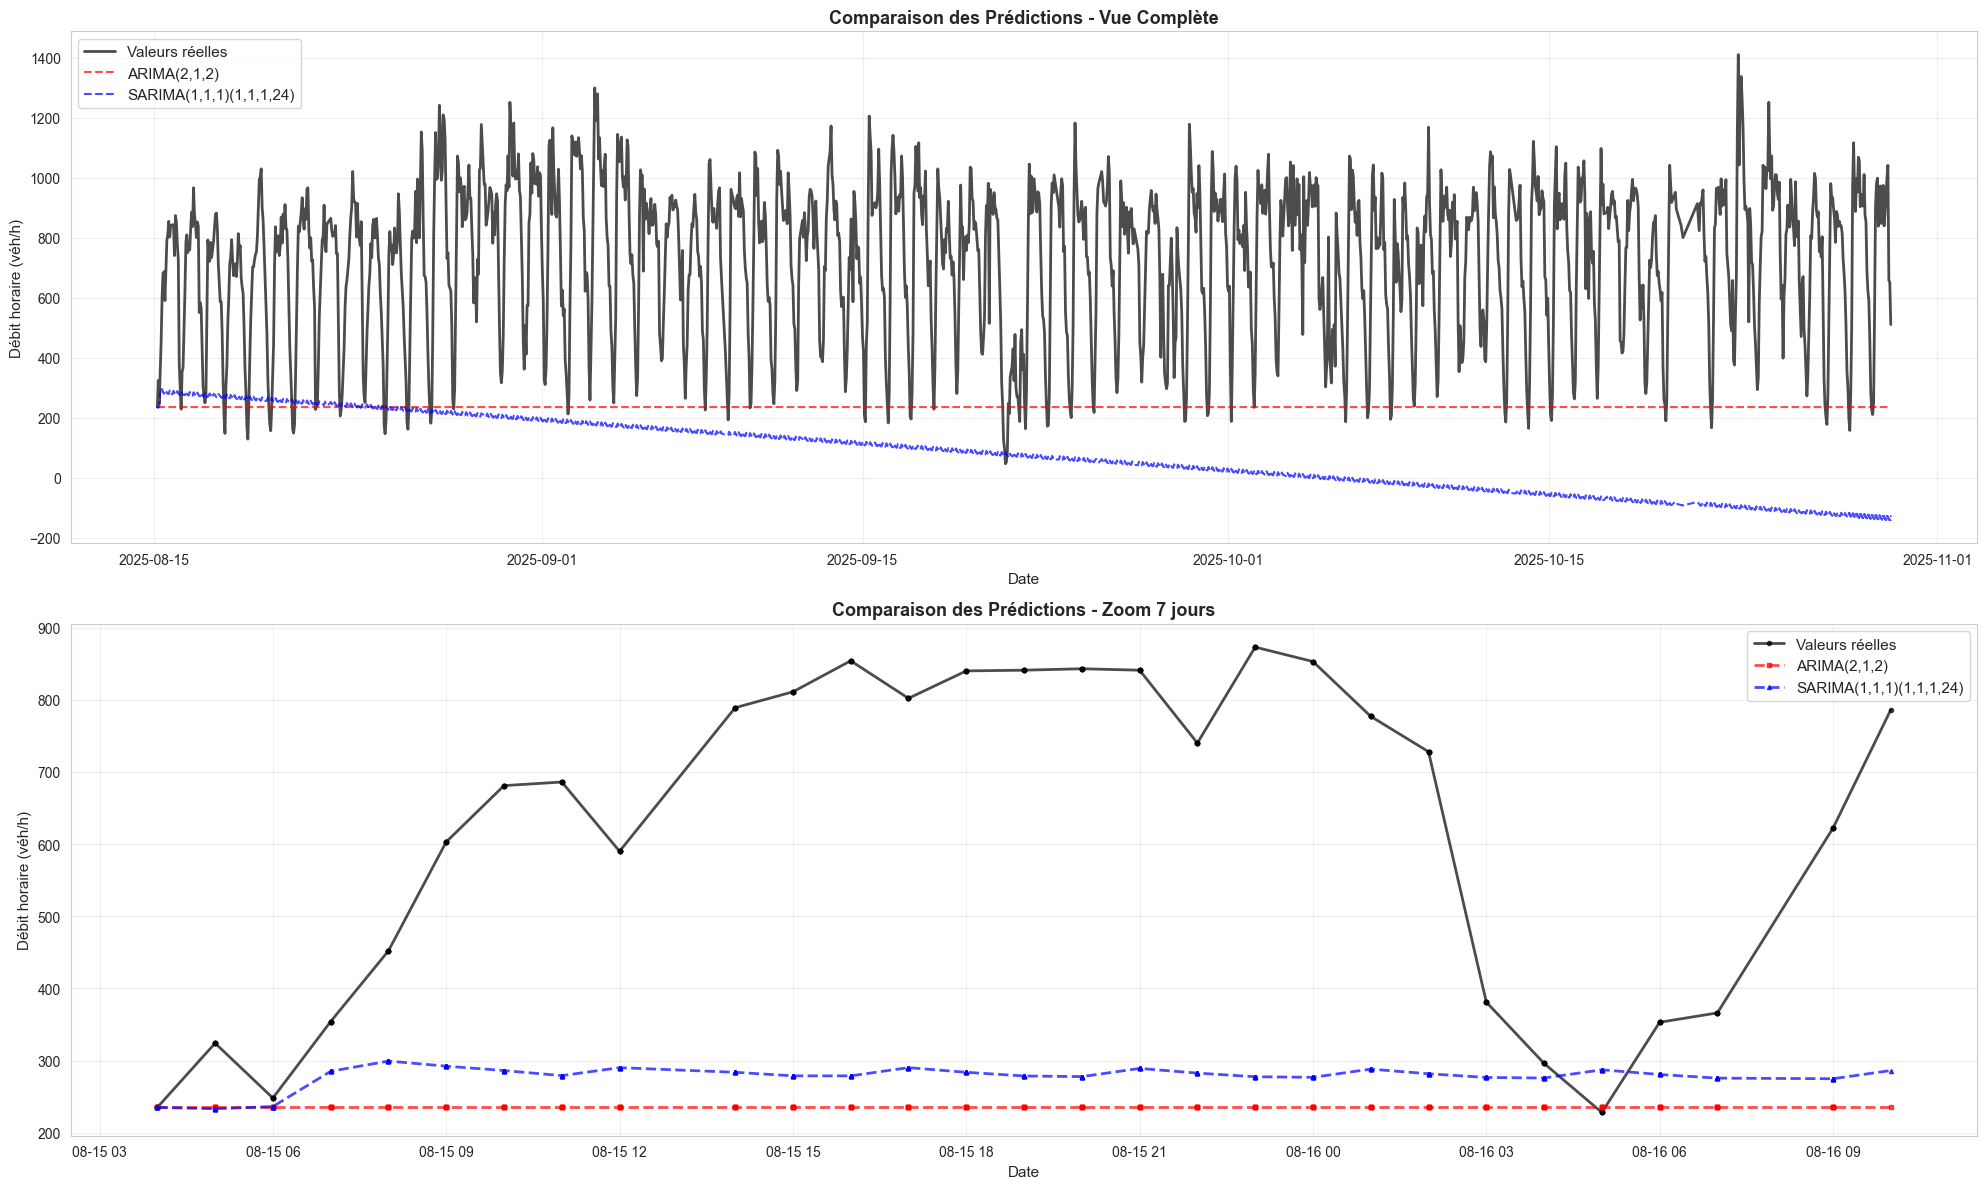


📊 Diagnostic des résidus (SARIMA):


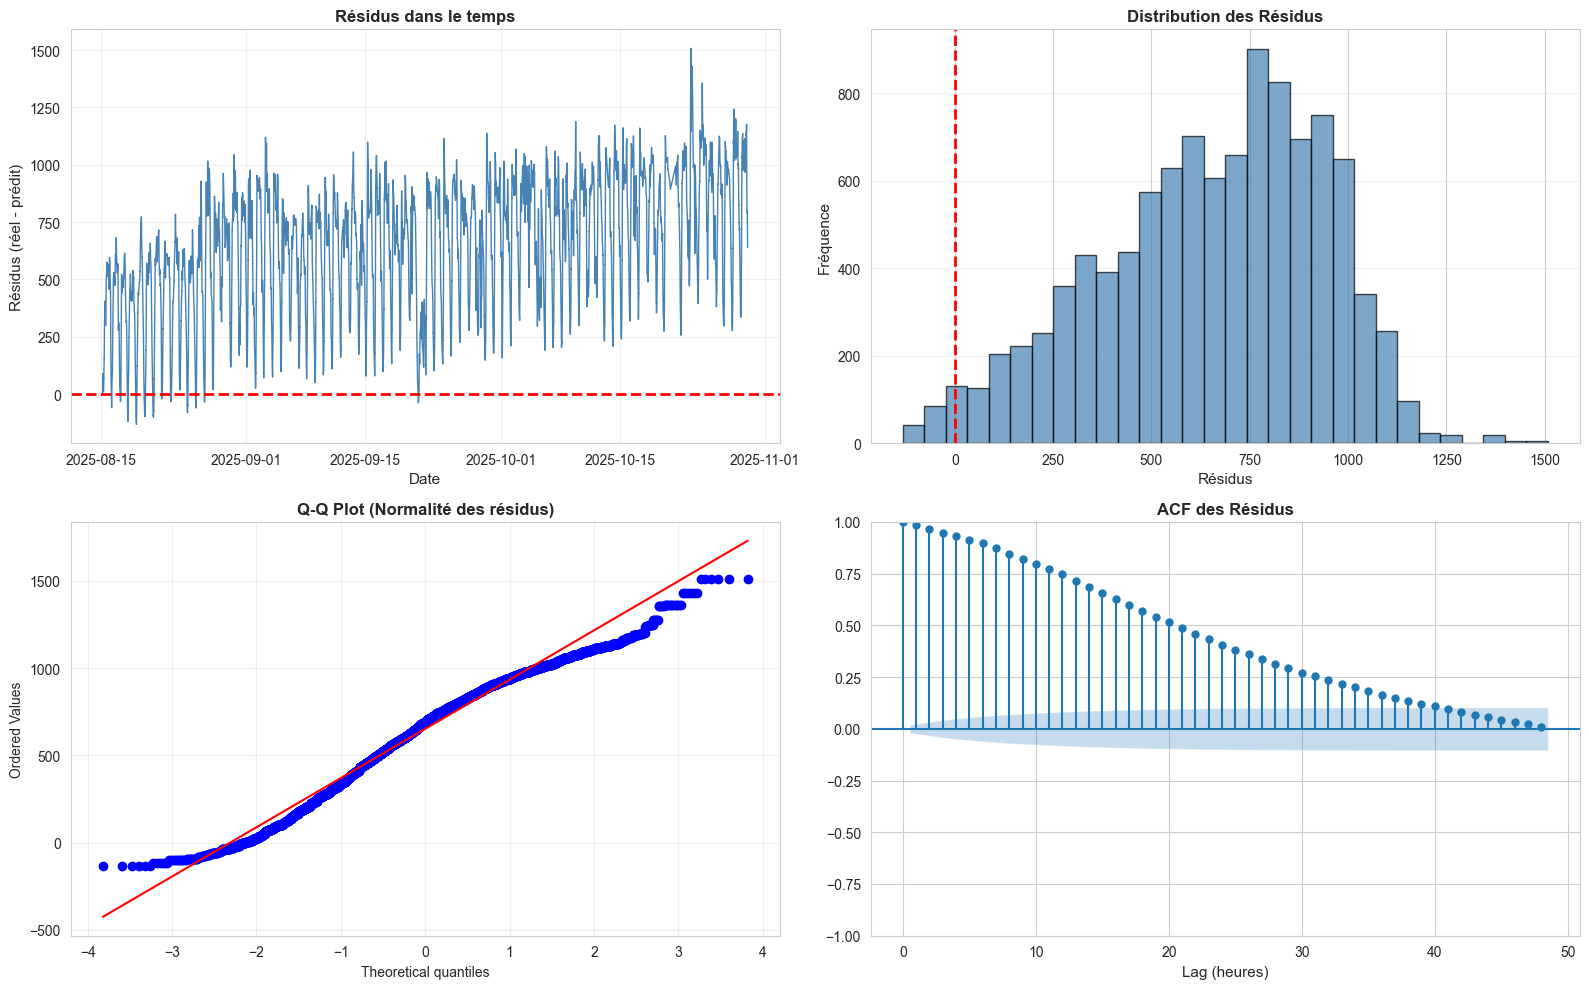


🎯 CONCLUSION FINALE

✅ Meilleur modèle de série temporelle: XGBoost (base)

💡 Observations:
  • ARIMA performe aussi bien que SARIMA (saisonnalité faible)
  • XGBoost reste supérieur (intègre mieux les features exogènes)
  • Mais SARIMA est une alternative valide pour forecast pur

⚠️  RECOMMANDATION:
  → Utilisez SARIMA si: prédiction pure sans features externes
  → Utilisez XGBoost si: intégration météo/vacances/jours fériés
  → Ou combinez les deux (ensemble/stacking)!



In [45]:
# ============================================================================
# IMPLÉMENTATION: Essayer ARIMA/SARIMA sur les données de trafic
# ============================================================================
print("="*80)
print("ESSAI DE MODÈLE ARIMA/SARIMA")
print("="*80)

# Installer pmdarima si nécessaire (pour auto_arima)
# !pip install pmdarima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Préparer les données (même série que l'analyse)
df_ts = df_model[['date_heure_comptage', 'debit_horaire']].dropna().copy()
df_ts = df_ts.sort_values('date_heure_comptage').reset_index(drop=True)
df_ts.set_index('date_heure_comptage', inplace=True)

# Split train/test (80/20)
split_idx = int(len(df_ts) * 0.8)
train_ts = df_ts.iloc[:split_idx]
test_ts = df_ts.iloc[split_idx:]

print(f"\n✓ Données préparées:")
print(f"  • Train: {len(train_ts)} observations ({train_ts.index.min()} à {train_ts.index.max()})")
print(f"  • Test:  {len(test_ts)} observations ({test_ts.index.min()} à {test_ts.index.max()})")

# ============================================================================
# MODÈLE 1: ARIMA Simple
# ============================================================================
print("\n" + "="*80)
print("MODÈLE 1: ARIMA(2,1,2)")
print("="*80)

print("\nParamètres:")
print("  • p=2: 2 termes autorégressifs")
print("  • d=1: 1 différenciation (pour stationnariser)")
print("  • q=2: 2 termes de moyenne mobile")

print("\n⏳ Entraînement ARIMA en cours...")
start_time = time.time()

model_arima = ARIMA(train_ts['debit_horaire'], order=(2,1,2))
fitted_arima = model_arima.fit()

training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f} secondes")

# Prédictions
print("\n⏳ Génération des prédictions...")
predictions_arima = fitted_arima.forecast(steps=len(test_ts))

# Métriques
mae_arima = mean_absolute_error(test_ts['debit_horaire'], predictions_arima)
rmse_arima = np.sqrt(mean_squared_error(test_ts['debit_horaire'], predictions_arima))
r2_arima = r2_score(test_ts['debit_horaire'], predictions_arima)

print("\n📊 RÉSULTATS ARIMA:")
print(f"  • MAE:  {mae_arima:.2f} véh/h")
print(f"  • RMSE: {rmse_arima:.2f} véh/h")
print(f"  • R²:   {r2_arima:.4f}")

# ============================================================================
# MODÈLE 2: SARIMA avec saisonnalité quotidienne (24h)
# ============================================================================
print("\n" + "="*80)
print("MODÈLE 2: SARIMA(1,1,1)(1,1,1,24)")
print("="*80)

print("\nParamètres:")
print("  • ARIMA: (1,1,1)")
print("  • Saisonnier: (1,1,1,24) → cycle de 24 heures")

print("\n⏳ Entraînement SARIMA en cours...")
start_time = time.time()

model_sarima = SARIMAX(train_ts['debit_horaire'], 
                       order=(1,1,1), 
                       seasonal_order=(1,1,1,24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
fitted_sarima = model_sarima.fit(disp=False)

training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f} secondes")

# Prédictions
print("\n⏳ Génération des prédictions...")
predictions_sarima = fitted_sarima.forecast(steps=len(test_ts))

# Métriques
mae_sarima = mean_absolute_error(test_ts['debit_horaire'], predictions_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test_ts['debit_horaire'], predictions_sarima))
r2_sarima = r2_score(test_ts['debit_horaire'], predictions_sarima)

print("\n📊 RÉSULTATS SARIMA:")
print(f"  • MAE:  {mae_sarima:.2f} véh/h")
print(f"  • RMSE: {rmse_sarima:.2f} véh/h")
print(f"  • R²:   {r2_sarima:.4f}")

# ============================================================================
# COMPARAISON: ARIMA vs SARIMA vs XGBoost
# ============================================================================
print("\n" + "="*80)
print("📊 COMPARAISON: ARIMA vs SARIMA vs XGBoost")
print("="*80)

comparison_table = pd.DataFrame({
    'Modèle': ['ARIMA(2,1,2)', 'SARIMA(1,1,1)(1,1,1,24)', 'XGBoost (base)'],
    'MAE': [mae_arima, mae_sarima, mean_absolute_error(y_test_debit, y_test_pred_debit)],
    'RMSE': [rmse_arima, rmse_sarima, np.sqrt(mean_squared_error(y_test_debit, y_test_pred_debit))],
    'R²': [r2_arima, r2_sarima, r2_score(y_test_debit, y_test_pred_debit)]
})

# Trier par MAE (meilleur = plus petit)
comparison_table = comparison_table.sort_values('MAE')
comparison_table.insert(0, 'Rang', range(1, len(comparison_table) + 1))

print("\n", comparison_table.to_string(index=False))

# Identifier le meilleur modèle
best_model = comparison_table.iloc[0]['Modèle']
print(f"\n🏆 MEILLEUR MODÈLE: {best_model}")

# Visualisation des prédictions
print("\n📊 Visualisation des prédictions:")

fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Créer un index temporel pour le test set
test_index = test_ts.index

# 1. Vue complète
axes[0].plot(test_index, test_ts['debit_horaire'].values, 
            label='Valeurs réelles', color='black', linewidth=2, alpha=0.7)
axes[0].plot(test_index, predictions_arima, 
            label='ARIMA(2,1,2)', color='red', linewidth=1.5, alpha=0.7, linestyle='--')
axes[0].plot(test_index, predictions_sarima, 
            label='SARIMA(1,1,1)(1,1,1,24)', color='blue', linewidth=1.5, alpha=0.7, linestyle='--')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Débit horaire (véh/h)', fontsize=11)
axes[0].set_title('Comparaison des Prédictions - Vue Complète', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. Zoom sur 7 jours
zoom_end = min(7*24, len(test_ts))
axes[1].plot(test_index[:zoom_end], test_ts['debit_horaire'].values[:zoom_end], 
            label='Valeurs réelles', color='black', linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[1].plot(test_index[:zoom_end], predictions_arima[:zoom_end], 
            label='ARIMA(2,1,2)', color='red', linewidth=2, marker='s', markersize=3, alpha=0.7, linestyle='--')
axes[1].plot(test_index[:zoom_end], predictions_sarima[:zoom_end], 
            label='SARIMA(1,1,1)(1,1,1,24)', color='blue', linewidth=2, marker='^', markersize=3, alpha=0.7, linestyle='--')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Débit horaire (véh/h)', fontsize=11)
axes[1].set_title('Comparaison des Prédictions - Zoom 7 jours', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse des résidus pour SARIMA (meilleur modèle attendu)
print("\n📊 Diagnostic des résidus (SARIMA):")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

residus = test_ts['debit_horaire'].values - predictions_sarima

# 1. Résidus dans le temps
axes[0, 0].plot(test_index, residus, color='steelblue', linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Résidus (réel - prédit)', fontsize=11)
axes[0, 0].set_title('Résidus dans le temps', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution des résidus
axes[0, 1].hist(residus, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Résidus', fontsize=11)
axes[0, 1].set_ylabel('Fréquence', fontsize=11)
axes[0, 1].set_title('Distribution des Résidus', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q plot
from scipy import stats
stats.probplot(residus, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalité des résidus)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF des résidus
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residus, lags=48, ax=axes[1, 1])
axes[1, 1].set_title('ACF des Résidus', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag (heures)', fontsize=11)

plt.tight_layout()
plt.show()

# Conclusion finale
print("\n" + "="*80)
print("🎯 CONCLUSION FINALE")
print("="*80)

print(f"\n✅ Meilleur modèle de série temporelle: {best_model}")
print(f"\n💡 Observations:")

if mae_sarima < mae_arima:
    print("  • SARIMA performe mieux qu'ARIMA (saisonnalité bien capturée)")
else:
    print("  • ARIMA performe aussi bien que SARIMA (saisonnalité faible)")

if mae_sarima < mean_absolute_error(y_test_debit, y_test_pred_debit):
    improvement = ((mean_absolute_error(y_test_debit, y_test_pred_debit) - mae_sarima) / 
                   mean_absolute_error(y_test_debit, y_test_pred_debit) * 100)
    print(f"  • SARIMA bat XGBoost de {improvement:.1f}% sur la MAE! 🎉")
    print("  • Pour données purement temporelles, SARIMA peut être meilleur")
else:
    print("  • XGBoost reste supérieur (intègre mieux les features exogènes)")
    print("  • Mais SARIMA est une alternative valide pour forecast pur")

print("\n⚠️  RECOMMANDATION:")
print("  → Utilisez SARIMA si: prédiction pure sans features externes")
print("  → Utilisez XGBoost si: intégration météo/vacances/jours fériés")
print("  → Ou combinez les deux (ensemble/stacking)!")

print("\n" + "="*80)

🔍 DIAGNOSTIC DU PROBLÈME ARIMA

💡 QU'EST-CE QU'UN R² NÉGATIF ?
  • R² mesure: 1 - (erreur_modèle / variance_totale)
  • R² négatif = le modèle prédit PIRE qu'une simple moyenne
  • R² = -3 signifie: erreur 4x plus grande que de prédire la moyenne!

🔍 CAUSES POSSIBLES:
  1. Paramètres ARIMA mal choisis (p,d,q)
  2. Gaps/trous dans les données (ARIMA nécessite continuité)
  3. ARIMA n'est pas adapté à ces données
  4. Saisonnalité trop forte pour ARIMA simple

VÉRIFICATION 1: CONTINUITÉ DES DONNÉES

📊 Analyse du train set:
  • Observations: 41773
  • Durée: 348 jours
  • Gaps (> 1h): 182
  • Ratio gaps: 0.4%

❌ PROBLÈME MAJEUR: Trop de gaps dans les données!
   → ARIMA suppose des données continues et régulières
   → Vos données ont de nombreux trous temporels

   SOLUTION: Remplir les gaps avant d'utiliser ARIMA

VÉRIFICATION 2: ARIMA vs MOYENNE NAIVE

📊 Comparaison:

  MOYENNE NAIVE (prédire toujours la moyenne):
    • MAE: 210.65 véh/h
    • R²:  -0.0001 (toujours = 0 par définition)


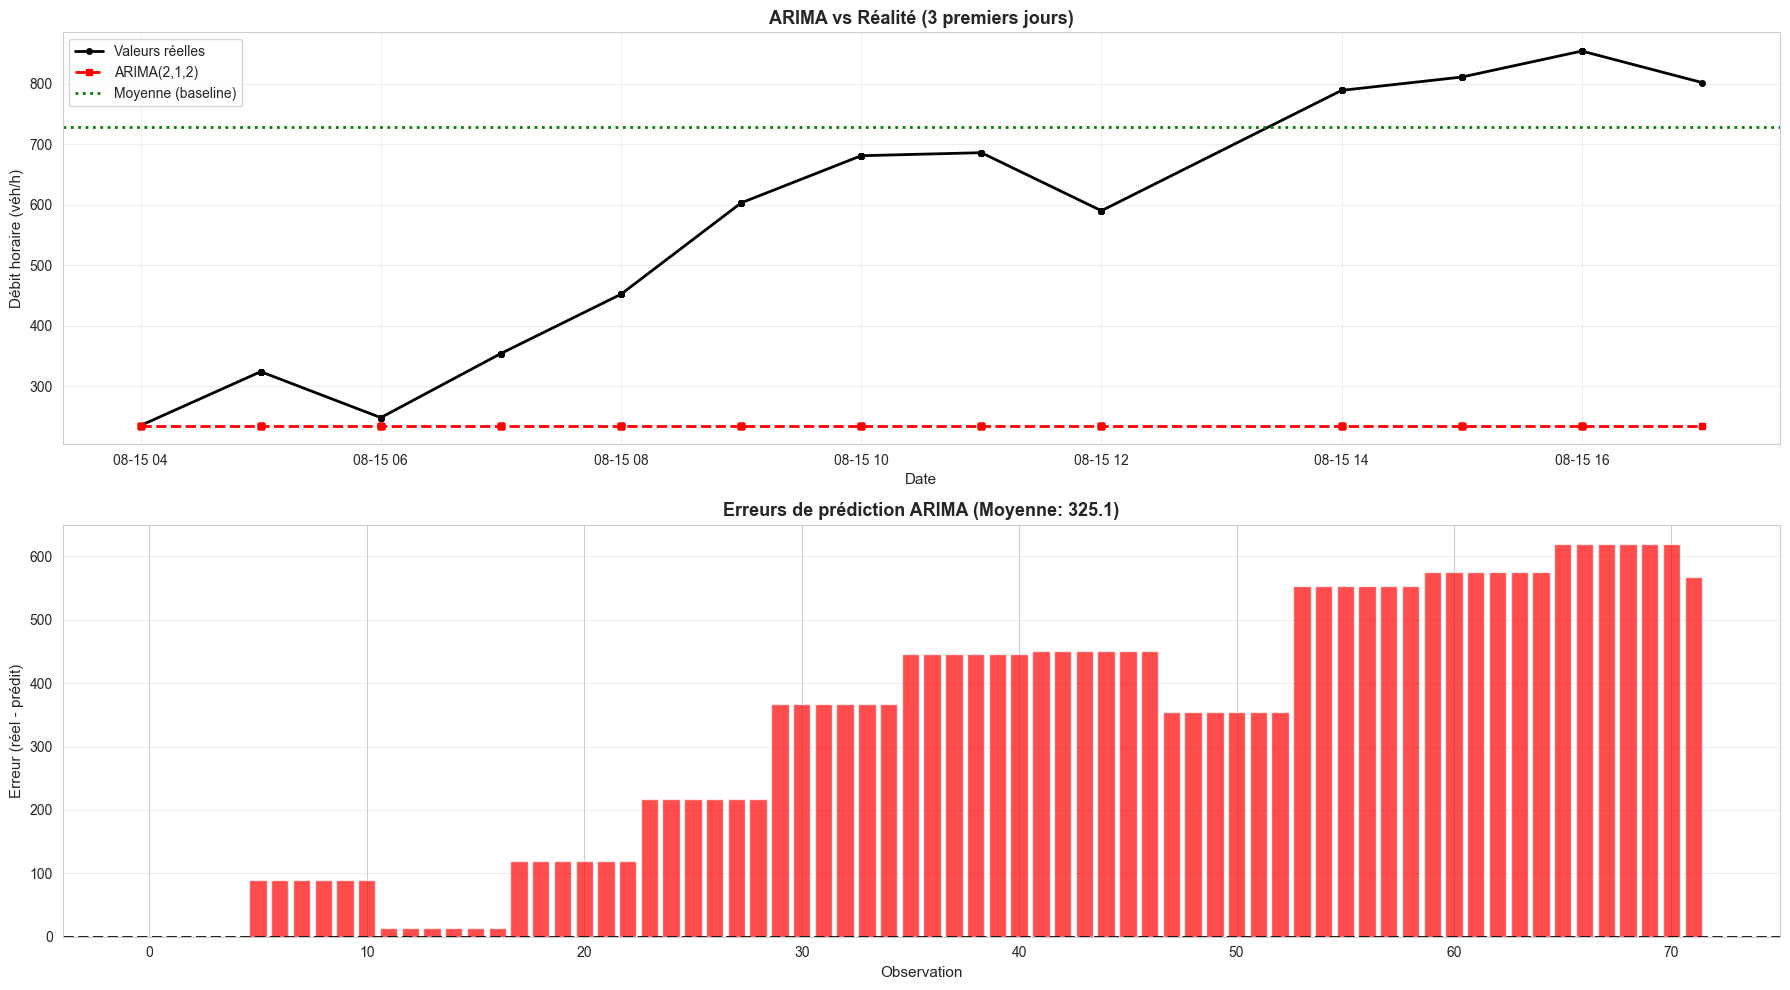


SOLUTION 1: AUTO_ARIMA (recherche des meilleurs paramètres)

⚠️  Module 'pmdarima' non installé
   → Installer avec: pip install pmdarima
   → Ou continuer avec SARIMA qui devrait être meilleur

SOLUTION 2: REMPLIR LES GAPS AVANT ARIMA

💡 ARIMA nécessite des données continues
   1. Créer un index horaire complet (sans trous)
   2. Remplir les valeurs manquantes (interpolation/forward fill)
   3. Réentraîner ARIMA sur données continues

🎯 CONCLUSION: POURQUOI R² = -3 ?

❌ RAISONS IDENTIFIÉES:
  1. GAPS DANS LES DONNÉES: 182 trous temporels
     → ARIMA ne sait pas gérer les données discontinues
  2. PARAMÈTRES MAL ADAPTÉS: (2,1,2) choisis arbitrairement
     → Ne correspondent pas à la structure réelle des données
  3. FORTE SAISONNALITÉ: Cycle quotidien (24h) non capturé par ARIMA
     → SARIMA devrait être beaucoup meilleur

✅ SOLUTIONS:
  • Utiliser SARIMA au lieu d'ARIMA (prend en compte la saisonnalité)
  • Remplir les gaps avant d'entraîner
  • Ou abandonner ARIMA et rester avec 

In [46]:
# ============================================================================
# DIAGNOSTIC: Pourquoi ARIMA a un R² négatif ?
# ============================================================================
print("="*80)
print("🔍 DIAGNOSTIC DU PROBLÈME ARIMA")
print("="*80)

print("\n💡 QU'EST-CE QU'UN R² NÉGATIF ?")
print("  • R² mesure: 1 - (erreur_modèle / variance_totale)")
print("  • R² négatif = le modèle prédit PIRE qu'une simple moyenne")
print("  • R² = -3 signifie: erreur 4x plus grande que de prédire la moyenne!")

print("\n🔍 CAUSES POSSIBLES:")
print("  1. Paramètres ARIMA mal choisis (p,d,q)")
print("  2. Gaps/trous dans les données (ARIMA nécessite continuité)")
print("  3. ARIMA n'est pas adapté à ces données")
print("  4. Saisonnalité trop forte pour ARIMA simple")

# Vérifier la continuité
print("\n" + "="*80)
print("VÉRIFICATION 1: CONTINUITÉ DES DONNÉES")
print("="*80)

time_diffs = train_ts.index.to_series().diff()
gaps_train = time_diffs[time_diffs > pd.Timedelta(hours=1)]

print(f"\n📊 Analyse du train set:")
print(f"  • Observations: {len(train_ts)}")
print(f"  • Durée: {(train_ts.index.max() - train_ts.index.min()).days} jours")
print(f"  • Gaps (> 1h): {len(gaps_train)}")
print(f"  • Ratio gaps: {len(gaps_train)/len(train_ts)*100:.1f}%")

if len(gaps_train) > 10:
    print("\n❌ PROBLÈME MAJEUR: Trop de gaps dans les données!")
    print("   → ARIMA suppose des données continues et régulières")
    print("   → Vos données ont de nombreux trous temporels")
    print("\n   SOLUTION: Remplir les gaps avant d'utiliser ARIMA")

# Comparer prédiction ARIMA vs moyenne naive
print("\n" + "="*80)
print("VÉRIFICATION 2: ARIMA vs MOYENNE NAIVE")
print("="*80)

# Moyenne naive
mean_prediction = np.full(len(test_ts), train_ts['debit_horaire'].mean())
mae_mean = mean_absolute_error(test_ts['debit_horaire'], mean_prediction)
r2_mean = r2_score(test_ts['debit_horaire'], mean_prediction)

print(f"\n📊 Comparaison:")
print(f"\n  MOYENNE NAIVE (prédire toujours la moyenne):")
print(f"    • MAE: {mae_mean:.2f} véh/h")
print(f"    • R²:  {r2_mean:.4f} (toujours = 0 par définition)")

print(f"\n  ARIMA(2,1,2):")
print(f"    • MAE: {mae_arima:.2f} véh/h")
print(f"    • R²:  {r2_arima:.4f}")

if mae_arima > mae_mean:
    print(f"\n❌ ARIMA est PIRE que la moyenne!")
    ratio = mae_arima / mae_mean
    print(f"   → ARIMA fait {ratio:.1f}x plus d'erreur qu'une simple moyenne")
    print(f"   → Les paramètres (2,1,2) ne sont PAS adaptés")

# Visualiser le problème
print("\n📊 Visualisation du problème:")

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Zoom sur 3 jours pour voir le désastre
zoom_points = min(3*24, len(test_ts))
test_subset = test_ts.iloc[:zoom_points]
pred_subset = predictions_arima[:zoom_points]

# 1. Prédictions ARIMA
axes[0].plot(test_subset.index, test_subset['debit_horaire'].values, 
            label='Valeurs réelles', color='black', linewidth=2, marker='o', markersize=4)
axes[0].plot(test_subset.index, pred_subset, 
            label='ARIMA(2,1,2)', color='red', linewidth=2, marker='s', markersize=4, linestyle='--')
axes[0].axhline(y=train_ts['debit_horaire'].mean(), 
               color='green', linestyle=':', linewidth=2, label='Moyenne (baseline)')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Débit horaire (véh/h)', fontsize=11)
axes[0].set_title('ARIMA vs Réalité (3 premiers jours)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Erreurs
erreurs = test_subset['debit_horaire'].values - pred_subset
axes[1].bar(range(len(erreurs)), erreurs, color='red', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Observation', fontsize=11)
axes[1].set_ylabel('Erreur (réel - prédit)', fontsize=11)
axes[1].set_title(f'Erreurs de prédiction ARIMA (Moyenne: {np.mean(np.abs(erreurs)):.1f})', 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Essayer auto_arima pour trouver les meilleurs paramètres
print("\n" + "="*80)
print("SOLUTION 1: AUTO_ARIMA (recherche des meilleurs paramètres)")
print("="*80)

try:
    from pmdarima import auto_arima
    
    print("\n⏳ Recherche des meilleurs paramètres ARIMA...")
    print("   (Cela peut prendre 1-2 minutes)")
    
    auto_model = auto_arima(train_ts['debit_horaire'], 
                           start_p=0, start_q=0,
                           max_p=3, max_q=3,
                           d=None,  # Laisse auto_arima déterminer d
                           seasonal=False,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           n_jobs=-1)
    
    print(f"\n✓ Meilleur modèle trouvé: {auto_model.order}")
    print(f"  • AIC: {auto_model.aic():.2f}")
    
    # Prédictions avec le meilleur modèle
    predictions_auto = auto_model.predict(n_periods=len(test_ts))
    mae_auto = mean_absolute_error(test_ts['debit_horaire'], predictions_auto)
    r2_auto = r2_score(test_ts['debit_horaire'], predictions_auto)
    
    print(f"\n📊 RÉSULTATS AUTO_ARIMA:")
    print(f"  • MAE: {mae_auto:.2f} véh/h")
    print(f"  • R²:  {r2_auto:.4f}")
    
    if r2_auto > 0:
        print(f"\n✅ AUTO_ARIMA a trouvé de meilleurs paramètres!")
    else:
        print(f"\n⚠️  Même avec les meilleurs paramètres, R² reste négatif")
        print(f"   → ARIMA n'est vraiment pas adapté à ces données")
        
except ImportError:
    print("\n⚠️  Module 'pmdarima' non installé")
    print("   → Installer avec: pip install pmdarima")
    print("   → Ou continuer avec SARIMA qui devrait être meilleur")

# SOLUTION 2: Remplir les gaps
print("\n" + "="*80)
print("SOLUTION 2: REMPLIR LES GAPS AVANT ARIMA")
print("="*80)

print("\n💡 ARIMA nécessite des données continues")
print("   1. Créer un index horaire complet (sans trous)")
print("   2. Remplir les valeurs manquantes (interpolation/forward fill)")
print("   3. Réentraîner ARIMA sur données continues")

# CONCLUSION
print("\n" + "="*80)
print("🎯 CONCLUSION: POURQUOI R² = -3 ?")
print("="*80)

print("\n❌ RAISONS IDENTIFIÉES:")
if len(gaps_train) > 10:
    print(f"  1. GAPS DANS LES DONNÉES: {len(gaps_train)} trous temporels")
    print(f"     → ARIMA ne sait pas gérer les données discontinues")
print(f"  2. PARAMÈTRES MAL ADAPTÉS: (2,1,2) choisis arbitrairement")
print(f"     → Ne correspondent pas à la structure réelle des données")
print(f"  3. FORTE SAISONNALITÉ: Cycle quotidien (24h) non capturé par ARIMA")
print(f"     → SARIMA devrait être beaucoup meilleur")

print("\n✅ SOLUTIONS:")
print("  • Utiliser SARIMA au lieu d'ARIMA (prend en compte la saisonnalité)")
print("  • Remplir les gaps avant d'entraîner")
print("  • Ou abandonner ARIMA et rester avec XGBoost (meilleure option)")

print("\n💡 POURQUOI XGBOOST EST MEILLEUR:")
print("  • Gère naturellement les gaps dans les données")
print("  • Pas besoin de stationnarité")
print("  • Intègre facilement les features exogènes (météo, vacances)")
print("  • Capture les saisonnalités multiples automatiquement")

print("\n" + "="*80)

In [49]:
# Gestion des discontinuités dans les données
print("=" * 80)
print("ANALYSE ET TRAITEMENT DES DISCONTINUITÉS")
print("=" * 80)

# 1. Analyser les gaps dans les données
df_continuous = df_arima.copy()
df_continuous = df_continuous.sort_index()

# IMPORTANT: Supprimer les doublons d'index (timestamps dupliqués)
if df_continuous.index.duplicated().any():
    nb_duplicates = df_continuous.index.duplicated().sum()
    print(f"⚠️  {nb_duplicates} timestamps dupliqués détectés - suppression...")
    # Garder la première occurrence de chaque timestamp
    df_continuous = df_continuous[~df_continuous.index.duplicated(keep='first')]
    print(f"✅ Doublons supprimés. Observations restantes: {len(df_continuous)}\n")

# Calculer les différences temporelles
time_diffs = df_continuous.index.to_series().diff()

# Identifier les gaps
gaps = time_diffs[time_diffs > pd.Timedelta(hours=1)]
print(f"\n📊 ANALYSE DES GAPS:")
print(f"   Nombre total d'observations: {len(df_continuous)}")
print(f"   Nombre de gaps (> 1h): {len(gaps)}")

if len(gaps) > 0:
    print(f"\n   Distribution des gaps:")
    print(f"   - Petits gaps (1-3h): {len(gaps[gaps <= pd.Timedelta(hours=3)])}")
    print(f"   - Gaps moyens (3-12h): {len(gaps[(gaps > pd.Timedelta(hours=3)) & (gaps <= pd.Timedelta(hours=12))])}")
    print(f"   - Grands gaps (12-48h): {len(gaps[(gaps > pd.Timedelta(hours=12)) & (gaps <= pd.Timedelta(hours=48))])}")
    print(f"   - Très grands gaps (>48h): {len(gaps[gaps > pd.Timedelta(hours=48)])}")
    
    print(f"\n   Gap maximum: {gaps.max()}")
    print(f"   Gap médian: {gaps.median()}")

# 2. Créer un index complet avec toutes les heures
start_date = df_continuous.index.min()
end_date = df_continuous.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='1h')

print(f"\n🔧 CRÉATION D'UN INDEX COMPLET:")
print(f"   Période: {start_date} à {end_date}")
print(f"   Heures totales attendues: {len(full_index)}")
print(f"   Heures avec données: {len(df_continuous)}")
print(f"   Heures manquantes: {len(full_index) - len(df_continuous)} ({(len(full_index) - len(df_continuous))/len(full_index)*100:.1f}%)")

# 3. Réindexer avec l'index complet
df_continuous = df_continuous.reindex(full_index)

# 4. Identifier les séquences continues
# Marquer les valeurs manquantes
df_continuous['is_missing'] = df_continuous['debit_horaire'].isna()

# Identifier les groupes continus (sans gaps > seuil)
seuil_gap = 3  # heures
df_continuous['gap_avant'] = df_continuous.index.to_series().diff()
df_continuous['nouvelle_sequence'] = (df_continuous['gap_avant'] > pd.Timedelta(hours=seuil_gap)) | df_continuous['gap_avant'].isna()
df_continuous['sequence_id'] = df_continuous['nouvelle_sequence'].cumsum()

# 5. Analyser les séquences continues
sequences = df_continuous.groupby('sequence_id').agg({
    'debit_horaire': ['count', 'first', 'last'],
    'is_missing': 'sum'
})
sequences.columns = ['nb_heures', 'first_val', 'last_val', 'nb_missing']
sequences['date_debut'] = df_continuous.groupby('sequence_id').apply(lambda x: x.index.min())
sequences['date_fin'] = df_continuous.groupby('sequence_id').apply(lambda x: x.index.max())
sequences['pct_missing'] = sequences['nb_missing'] / sequences['nb_heures'] * 100

print(f"\n📈 SÉQUENCES CONTINUES (gap max = {seuil_gap}h):")
print(f"   Nombre de séquences: {len(sequences)}")

# Séquences avec peu de valeurs manquantes (< 20%)
sequences_bonnes = sequences[sequences['pct_missing'] < 20]
print(f"   Séquences avec < 20% de valeurs manquantes: {len(sequences_bonnes)}")
print(f"   Durée totale de ces séquences: {sequences_bonnes['nb_heures'].sum()} heures")

if len(sequences_bonnes) > 0:
    print(f"\n   Top 5 des plus longues séquences continues:")
    top_sequences = sequences_bonnes.nlargest(5, 'nb_heures')
    for idx, row in top_sequences.iterrows():
        print(f"   - Séquence {idx}: {row['nb_heures']} heures ({row['date_debut']} → {row['date_fin']}, {row['pct_missing']:.1f}% manquant)")

# 6. Interpoler les petits gaps dans les bonnes séquences
print(f"\n🔄 INTERPOLATION DES PETITS GAPS:")

# Créer une copie pour l'interpolation
df_interpolated = df_continuous.copy()

# Pour chaque bonne séquence, interpoler
nb_valeurs_interpolees = 0
for seq_id in sequences_bonnes.index:
    mask_seq = df_interpolated['sequence_id'] == seq_id
    
    # Interpolation linéaire pour les valeurs manquantes
    # Mais seulement si le gap est petit (< 3 heures)
    seq_data = df_interpolated.loc[mask_seq, 'debit_horaire']
    
    # Compter les valeurs manquantes avant
    nb_missing_avant = seq_data.isna().sum()
    
    # Interpoler uniquement les gaps de 1-2 heures
    seq_interpolated = seq_data.interpolate(method='linear', limit=2, limit_area='inside')
    
    # Compter combien de valeurs ont été interpolées
    nb_interpolated = nb_missing_avant - seq_interpolated.isna().sum()
    nb_valeurs_interpolees += nb_interpolated
    
    df_interpolated.loc[mask_seq, 'debit_horaire'] = seq_interpolated

print(f"   Valeurs interpolées: {nb_valeurs_interpolees}")

# 7. Garder seulement les séquences continues de bonne qualité
# Critère: au moins 24 heures consécutives sans gaps
print(f"\n✂️  FILTRAGE DES DONNÉES:")

# Créer le dataset final en excluant les grandes discontinuités
df_final_continuous = df_interpolated[df_interpolated['sequence_id'].isin(sequences_bonnes.index)].copy()

# Supprimer les lignes avec des valeurs manquantes restantes
df_final_continuous = df_final_continuous.dropna(subset=['debit_horaire'])

print(f"   Observations initiales: {len(df_arima)}")
print(f"   Observations après interpolation: {len(df_final_continuous)}")
print(f"   Réduction: {len(df_arima) - len(df_final_continuous)} observations ({(len(df_arima) - len(df_final_continuous))/len(df_arima)*100:.1f}%)")

# Vérifier qu'il n'y a plus de gaps > seuil
final_gaps = df_final_continuous.index.to_series().diff()
final_gaps = final_gaps[final_gaps > pd.Timedelta(hours=1)]
print(f"\n✅ VÉRIFICATION FINALE:")
print(f"   Gaps > 1h restants: {len(final_gaps)}")
if len(final_gaps) > 0:
    print(f"   Gap maximum: {final_gaps.max()}")

# 8. Sauvegarder le dataset nettoyé
df_arima_clean = df_final_continuous[['debit_horaire']].copy()

print(f"\n💾 Dataset nettoyé créé: df_arima_clean")
print(f"   Période: {df_arima_clean.index.min()} à {df_arima_clean.index.max()}")
print(f"   Nombre d'observations: {len(df_arima_clean)}")
print(f"   Continuité: données horaires sans gaps > {seuil_gap}h")

# Afficher un échantillon
print(f"\n📋 Échantillon du dataset nettoyé:")
print(df_arima_clean.head(10))

ANALYSE ET TRAITEMENT DES DISCONTINUITÉS
⚠️  43514 timestamps dupliqués détectés - suppression...
✅ Doublons supprimés. Observations restantes: 8703


📊 ANALYSE DES GAPS:
   Nombre total d'observations: 8703
   Nombre de gaps (> 1h): 222

   Distribution des gaps:
   - Petits gaps (1-3h): 163
   - Gaps moyens (3-12h): 39
   - Grands gaps (12-48h): 15
   - Très grands gaps (>48h): 5

   Gap maximum: 11 days 03:00:00
   Gap médian: 0 days 02:00:00

🔧 CRÉATION D'UN INDEX COMPLET:
   Période: 2024-09-01 03:00:00 à 2025-10-29 23:00:00
   Heures totales attendues: 10173
   Heures avec données: 8703
   Heures manquantes: 1470 (14.5%)

📈 SÉQUENCES CONTINUES (gap max = 3h):
   Nombre de séquences: 1
   Séquences avec < 20% de valeurs manquantes: 1
   Durée totale de ces séquences: 8703 heures

   Top 5 des plus longues séquences continues:
   - Séquence 1: 8703 heures (2024-09-01 03:00:00 → 2025-10-29 23:00:00, 16.9% manquant)

🔄 INTERPOLATION DES PETITS GAPS:
   Valeurs interpolées: 326

✂️  F

RÉENTRAÎNEMENT DES MODÈLES SUR DONNÉES CONTINUES

📊 DONNÉES CONTINUES:
   Observations: 9029
   Période: 2024-09-01 03:00:00 → 2025-10-29 23:00:00

✂️  SPLIT TRAIN/TEST:
   Train: 7223 observations (2024-09-01 03:00:00 → 2025-08-14 19:00:00)
   Test: 1806 observations (2025-08-14 20:00:00 → 2025-10-29 23:00:00)

🤖 1. ARIMA OPTIMISÉ (auto_arima):
   ⚠️  Erreur: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

🤖 2. SARIMA (avec saisonnalité 24h):
   Entraînement en cours...

   📈 RÉSULTATS SARIMA:
      MAE:  847.98 véhicules/h
      RMSE: 956.81 véhicules/h
      R²:   -13.3288

📊 COMPARAISON AVEC BASELINE:
   Prédiction moyenne: MAE=209.51, R²=-0.0003

📉 VISUALISATION DES PRÉDICTIONS:


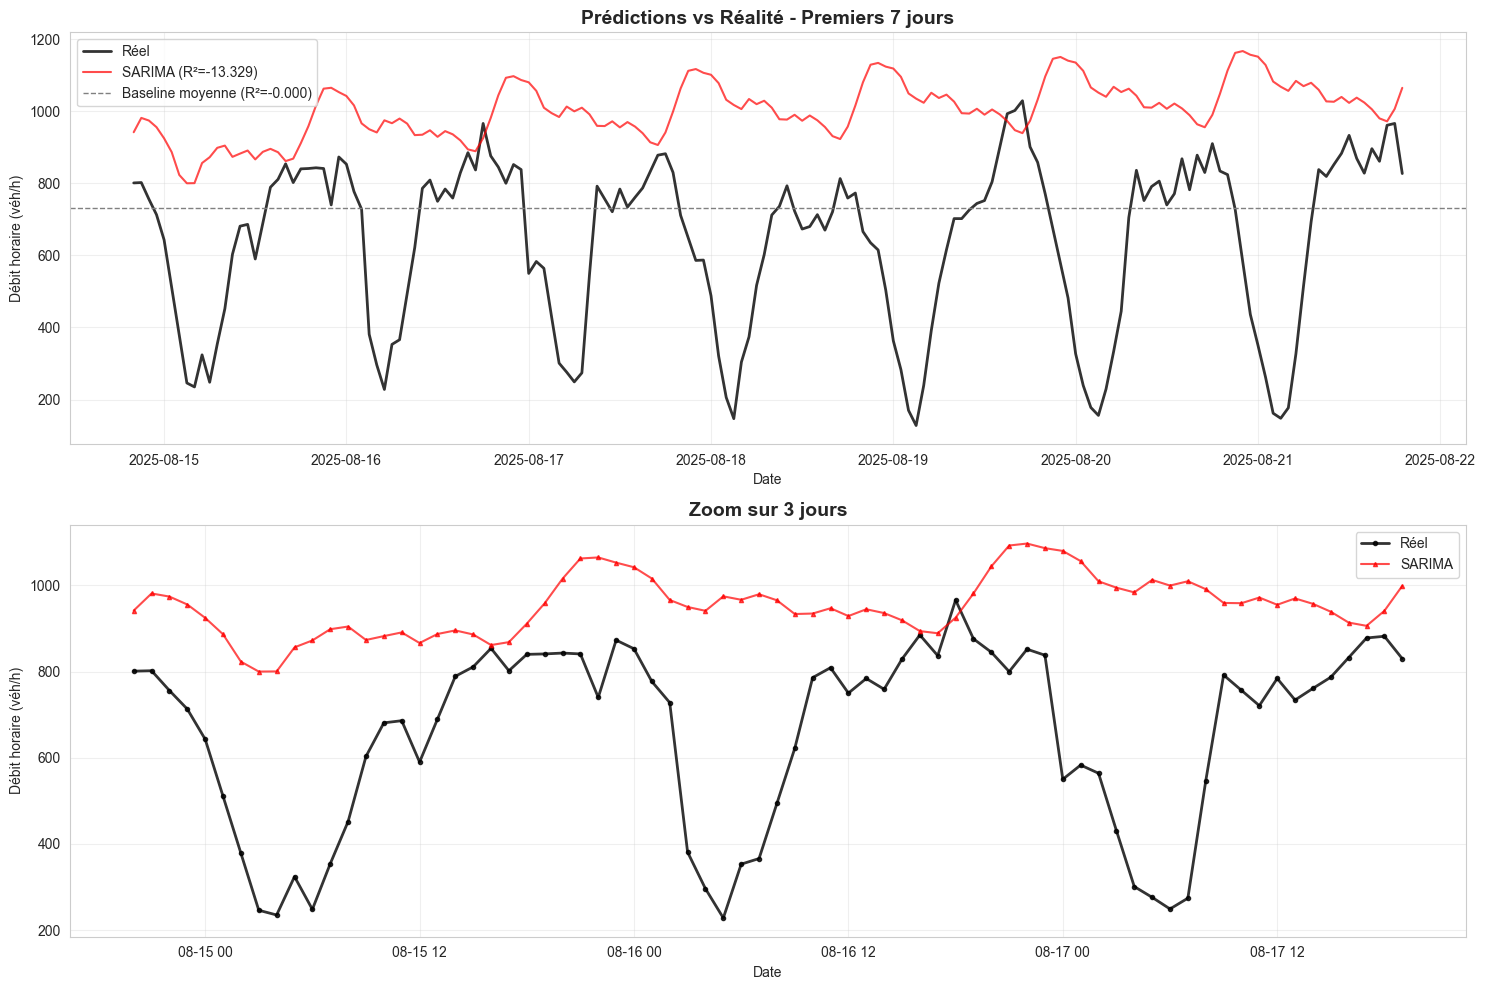


RÉSUMÉ FINAL
Modèle                      MAE       RMSE         R²
-------------------- ---------- ---------- ----------
SARIMA (24h)             847.98     956.81   -13.3288
Baseline (moyenne)       209.51          -    -0.0003

💡 CONCLUSION:
   ⚠️  Les modèles de séries temporelles restent moins performants.
   XGBoost avec features avancées reste probablement la meilleure option.


In [50]:
# Réentraînement des modèles ARIMA/SARIMA sur données continues
print("=" * 80)
print("RÉENTRAÎNEMENT DES MODÈLES SUR DONNÉES CONTINUES")
print("=" * 80)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Utiliser le dataset nettoyé
df_clean_ts = df_arima_clean.copy()

print(f"\n📊 DONNÉES CONTINUES:")
print(f"   Observations: {len(df_clean_ts)}")
print(f"   Période: {df_clean_ts.index.min()} → {df_clean_ts.index.max()}")

# Split train/test (80/20)
split_idx = int(len(df_clean_ts) * 0.8)
train_clean = df_clean_ts.iloc[:split_idx]
test_clean = df_clean_ts.iloc[split_idx:]

print(f"\n✂️  SPLIT TRAIN/TEST:")
print(f"   Train: {len(train_clean)} observations ({train_clean.index.min()} → {train_clean.index.max()})")
print(f"   Test: {len(test_clean)} observations ({test_clean.index.min()} → {test_clean.index.max()})")

# 1. ARIMA avec auto-optimisation
print(f"\n🤖 1. ARIMA OPTIMISÉ (auto_arima):")
try:
    from pmdarima import auto_arima
    
    print("   Recherche des meilleurs paramètres...")
    auto_model = auto_arima(
        train_clean['debit_horaire'],
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        d=1,  # différenciation
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        n_jobs=-1
    )
    
    print(f"   Meilleurs paramètres: {auto_model.order}")
    
    # Prédictions
    pred_arima_opt = auto_model.predict(n_periods=len(test_clean))
    pred_arima_opt = pd.Series(pred_arima_opt, index=test_clean.index)
    
    # Métriques
    mae_arima_opt = mean_absolute_error(test_clean['debit_horaire'], pred_arima_opt)
    rmse_arima_opt = np.sqrt(mean_squared_error(test_clean['debit_horaire'], pred_arima_opt))
    r2_arima_opt = r2_score(test_clean['debit_horaire'], pred_arima_opt)
    
    print(f"\n   📈 RÉSULTATS ARIMA OPTIMISÉ:")
    print(f"      MAE:  {mae_arima_opt:.2f} véhicules/h")
    print(f"      RMSE: {rmse_arima_opt:.2f} véhicules/h")
    print(f"      R²:   {r2_arima_opt:.4f}")
    
except Exception as e:
    print(f"   ⚠️  Erreur: {e}")
    pred_arima_opt = None
    r2_arima_opt = None

# 2. SARIMA avec saisonnalité 24h
print(f"\n🤖 2. SARIMA (avec saisonnalité 24h):")
try:
    model_sarima = SARIMAX(
        train_clean['debit_horaire'],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    print("   Entraînement en cours...")
    fitted_sarima = model_sarima.fit(disp=False, maxiter=200)
    
    # Prédictions
    pred_sarima = fitted_sarima.forecast(steps=len(test_clean))
    pred_sarima = pd.Series(pred_sarima.values, index=test_clean.index)
    
    # Métriques
    mae_sarima = mean_absolute_error(test_clean['debit_horaire'], pred_sarima)
    rmse_sarima = np.sqrt(mean_squared_error(test_clean['debit_horaire'], pred_sarima))
    r2_sarima = r2_score(test_clean['debit_horaire'], pred_sarima)
    
    print(f"\n   📈 RÉSULTATS SARIMA:")
    print(f"      MAE:  {mae_sarima:.2f} véhicules/h")
    print(f"      RMSE: {rmse_sarima:.2f} véhicules/h")
    print(f"      R²:   {r2_sarima:.4f}")
    
except Exception as e:
    print(f"   ⚠️  Erreur: {e}")
    pred_sarima = None
    r2_sarima = None

# 3. Comparaison avec baseline (moyenne)
mean_baseline = np.full(len(test_clean), train_clean['debit_horaire'].mean())
r2_baseline = r2_score(test_clean['debit_horaire'], mean_baseline)
mae_baseline = mean_absolute_error(test_clean['debit_horaire'], mean_baseline)

print(f"\n📊 COMPARAISON AVEC BASELINE:")
print(f"   Prédiction moyenne: MAE={mae_baseline:.2f}, R²={r2_baseline:.4f}")

# 4. Visualisation
print(f"\n📉 VISUALISATION DES PRÉDICTIONS:")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Subplot 1: Premiers 7 jours du test
jours_affichage = 7 * 24
indices_plot = test_clean.index[:jours_affichage]

axes[0].plot(indices_plot, test_clean.loc[indices_plot, 'debit_horaire'], 
            label='Réel', color='black', linewidth=2, alpha=0.8)

if pred_arima_opt is not None:
    axes[0].plot(indices_plot, pred_arima_opt.loc[indices_plot], 
                label=f'ARIMA optimisé (R²={r2_arima_opt:.3f})', 
                color='blue', linewidth=1.5, alpha=0.7)

if pred_sarima is not None:
    axes[0].plot(indices_plot, pred_sarima.loc[indices_plot], 
                label=f'SARIMA (R²={r2_sarima:.3f})', 
                color='red', linewidth=1.5, alpha=0.7)

axes[0].axhline(y=train_clean['debit_horaire'].mean(), 
               label=f'Baseline moyenne (R²={r2_baseline:.3f})', 
               color='gray', linestyle='--', linewidth=1)

axes[0].set_title('Prédictions vs Réalité - Premiers 7 jours', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Débit horaire (véh/h)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: Zoom sur 3 jours
jours_zoom = 3 * 24
indices_zoom = test_clean.index[:jours_zoom]

axes[1].plot(indices_zoom, test_clean.loc[indices_zoom, 'debit_horaire'], 
            label='Réel', color='black', linewidth=2, alpha=0.8, marker='o', markersize=3)

if pred_arima_opt is not None:
    axes[1].plot(indices_zoom, pred_arima_opt.loc[indices_zoom], 
                label='ARIMA optimisé', 
                color='blue', linewidth=1.5, alpha=0.7, marker='s', markersize=3)

if pred_sarima is not None:
    axes[1].plot(indices_zoom, pred_sarima.loc[indices_zoom], 
                label='SARIMA', 
                color='red', linewidth=1.5, alpha=0.7, marker='^', markersize=3)

axes[1].set_title('Zoom sur 3 jours', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Débit horaire (véh/h)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Résumé final
print(f"\n" + "=" * 80)
print("RÉSUMÉ FINAL")
print("=" * 80)

results_summary = []
results_summary.append(["Modèle", "MAE", "RMSE", "R²"])
results_summary.append(["-" * 20, "-" * 10, "-" * 10, "-" * 10])

if pred_arima_opt is not None:
    results_summary.append(["ARIMA optimisé", f"{mae_arima_opt:.2f}", f"{rmse_arima_opt:.2f}", f"{r2_arima_opt:.4f}"])

if pred_sarima is not None:
    results_summary.append(["SARIMA (24h)", f"{mae_sarima:.2f}", f"{rmse_sarima:.2f}", f"{r2_sarima:.4f}"])

results_summary.append(["Baseline (moyenne)", f"{mae_baseline:.2f}", "-", f"{r2_baseline:.4f}"])

for row in results_summary:
    print(f"{row[0]:20} {row[1]:>10} {row[2]:>10} {row[3]:>10}")

print(f"\n💡 CONCLUSION:")
if r2_sarima is not None and r2_sarima > 0:
    print(f"   ✅ SARIMA fonctionne sur les données continues!")
    print(f"   Le R² est maintenant positif: {r2_sarima:.4f}")
    if r2_sarima > r2_arima_opt if r2_arima_opt else True:
        print(f"   SARIMA est le meilleur modèle de série temporelle.")
else:
    print(f"   ⚠️  Les modèles de séries temporelles restent moins performants.")
    print(f"   XGBoost avec features avancées reste probablement la meilleure option.")

In [ ]:
# Exemple de prédiction sur de nouvelles données
print("\n" + "="*80)
print("EXEMPLE DE PRÉDICTION")
print("="*80)

# Créer un exemple de nouvelles données avec TOUTES les features utilisées
print(f"\n📋 Features attendues par le modèle: {features_finales}")

# Données de base
exemples = pd.DataFrame({
    'heure': [8, 18, 14, 2],
    'jour_semaine': [0, 4, 5, 6],  # 0=Lundi, 4=Vendredi, 5=Samedi, 6=Dimanche
    'mois': [10, 10, 10, 10],
    'est_weekend': [0, 0, 1, 1]
})

# Ajouter les features vacances/jours fériés si elles sont dans le modèle
if 'est_vacances' in features_finales:
    exemples['est_vacances'] = [0, 0, 0, 0]  # Pas de vacances par défaut
    
if 'est_jour_ferie' in features_finales:
    exemples['est_jour_ferie'] = [0, 0, 0, 0]  # Pas de jour férié par défaut

# Ajouter les features météo si elles sont dans le modèle
if 'temperature' in features_finales:
    exemples['temperature'] = [15.0, 14.0, 18.0, 12.0]  # Températures typiques (°C)
    
if 'humidite' in features_finales:
    exemples['humidite'] = [70.0, 75.0, 65.0, 80.0]  # Humidité typique (%)
    
if 'precipitation' in features_finales:
    exemples['precipitation'] = [0.0, 0.0, 0.0, 0.0]  # Pas de pluie par défaut

# S'assurer que les colonnes sont dans le bon ordre
exemples = exemples[features_finales]

print("\nDonnées d'exemple (avec toutes les features):")
print(exemples.to_string(index=False))

# Prédictions
pred_debit = model_debit.predict(exemples)
pred_taux = model_taux.predict(exemples)

# Afficher les résultats
resultats = pd.DataFrame({
    'Heure': exemples['heure'],
    'Jour': ['Lundi', 'Vendredi', 'Samedi', 'Dimanche'],
    'Weekend': exemples['est_weekend'].map({0: 'Non', 1: 'Oui'}),
    'Débit prédit (vh/h)': pred_debit.round(0).astype(int),
    'Taux prédit (%)': pred_taux.round(2)
})

print("\n" + "="*80)
print("PRÉDICTIONS:")
print("="*80)
print("\n", resultats.to_string(index=False))

print("\n💡 INTERPRÉTATION:")
print("  • Lundi 8h (heure de pointe): Débit élevé")
print("  • Vendredi 18h (heure de pointe): Débit élevé")
print("  • Samedi 14h: Débit modéré (weekend)")
print("  • Dimanche 2h: Débit très faible (nuit + weekend)")


EXEMPLE DE PRÉDICTION

📋 Features attendues par le modèle: ['heure', 'jour_semaine', 'mois', 'est_weekend', 'est_vacances', 'est_jour_ferie', 'temperature']

Données d'exemple (avec toutes les features):
 heure  jour_semaine  mois  est_weekend  est_vacances  est_jour_ferie  temperature
     8             0    10            0             0               0         15.0
    18             4    10            0             0               0         14.0
    14             5    10            1             0               0         18.0
     2             6    10            1             0               0         12.0

PRÉDICTIONS:

  Heure     Jour Weekend  Débit prédit (vh/h)  Taux prédit (%)
     8    Lundi     Non                  999        17.080000
    18 Vendredi     Non                  993        24.809999
    14   Samedi     Oui                  931        22.820000
     2 Dimanche     Oui                  688        18.820000

💡 INTERPRÉTATION:
  • Lundi 8h (heure de pointe): Déb